# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:08<00:00, 7.19kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

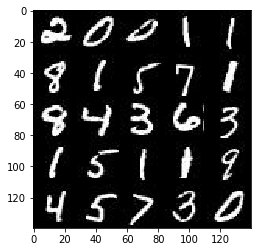

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

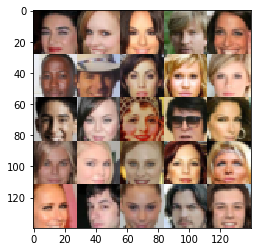

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    #width, height, channel
    input_real_images = tf.placeholder(tf.float32,[None, image_width, image_height, image_channels], name='input_real_images')

    
    z_data = tf.placeholder(tf.float32,[None, z_dim], name='z_data')
    
    learning_rate = tf.placeholder(tf.float32)

    return input_real_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    
    with tf.variable_scope('discriminator',reuse=reuse):
      
      x = tf.layers.conv2d(images,64,5,strides=2, padding='same')
      x_active = tf.maximum(alpha*x, x)
      
      x2 = tf.layers.conv2d(x_active,128,5,strides=2, padding='same')
      x2_normalization = tf.layers.batch_normalization(x2, training=True)
      x2_active = tf.maximum(alpha*x2_normalization, x2_normalization)
      
      x3 = tf.layers.conv2d(x2_active,256,5,strides=2, padding='same')
      x3_normalization = tf.layers.batch_normalization(x3, training=True)
      x3_active = tf.maximum(alpha*x3_normalization, x3_normalization)
      
      
      x3_active = tf.reshape(x3_active,(-1, 4*4*256))
      
      logits = tf.layers.dense(x3_active,1)
      
      out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [36]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    
    alpha=0.2
    with tf.variable_scope('generator',reuse=not is_train):

        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x,(-1,7,7,512))
        x_normalization = tf.layers.batch_normalization(x, training=is_train)
        x_active = tf.maximum(alpha*x_normalization,x_normalization)
        
        x1 = tf.layers.conv2d_transpose(x_active,256,5,strides=2, padding='same')
        x1_normalization = tf.layers.batch_normalization(x1, training=is_train)
        x1_active = tf.maximum(alpha*x1_normalization,x1_normalization)
        
        x2 = tf.layers.conv2d_transpose(x1_active,128,5,strides=2, padding='same')
        x2_normalization = tf.layers.batch_normalization(x2, training=is_train )
        x2_active = tf.maximum(alpha*x2_normalization,x2_normalization)
        
        logits = tf.layers.conv2d_transpose(x2_active,out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [37]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    generator_model = generator(input_z,out_channel_dim)
    
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)
    
    discriminator_loss_real = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)*0.9))
    discriminator_loss_fake = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    
    generator_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake))
    )
    
    sum_discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    return sum_discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [38]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
      train_vars = tf.trainable_variables()
      discriminator_vars = [var for var in train_vars if var.name.startswith('discriminator')]
      generator_vars = [var for var in train_vars if var.name.startswith('generator')]
      discriminator_train_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
      generator_train_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
    
    return discriminator_train_optimizer, generator_train_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_fake, learning_rate_var = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    discriminator_loss, generator_loss = model_loss(input_real, input_fake, data_shape[3])
    discriminator_opt, generator_opt = model_opt(discriminator_loss, generator_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            stp = 0
            for stp, batch_images in enumerate(get_batches(batch_size),1):
                # TODO: Train Model
                batch_fake =np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                _ = sess.run(discriminator_opt, feed_dict={input_real: batch_images, input_fake: batch_fake, learning_rate_var: learning_rate })
                _ = sess.run(generator_opt, feed_dict={input_real: batch_images, input_fake: batch_fake, learning_rate_var: learning_rate})
                
                train_loss_discriminator = sess.run(discriminator_loss, feed_dict={input_real: batch_images, input_fake: batch_fake})
                train_generator_loss = generator_loss.eval({input_fake: batch_fake})
                
                print('Epoch {}/{}'.format(epoch_i+1, epochs),
                      'Discriminator Loss: {:.4f}'.format(train_loss_discriminator),
                      'Generator loss: {:.4f}'.format(train_generator_loss))
                
                if stp%40==0:
                  show_generator_output(sess, 4, input_fake, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Discriminator Loss: 8.1481 Generator loss: 0.0350
Epoch 1/2 Discriminator Loss: 0.7015 Generator loss: 16.0316
Epoch 1/2 Discriminator Loss: 0.7518 Generator loss: 18.1169
Epoch 1/2 Discriminator Loss: 0.6739 Generator loss: 20.7805
Epoch 1/2 Discriminator Loss: 0.5314 Generator loss: 21.9730
Epoch 1/2 Discriminator Loss: 0.4162 Generator loss: 21.8217
Epoch 1/2 Discriminator Loss: 0.4005 Generator loss: 21.5181
Epoch 1/2 Discriminator Loss: 0.3754 Generator loss: 21.3655
Epoch 1/2 Discriminator Loss: 0.3612 Generator loss: 21.1451
Epoch 1/2 Discriminator Loss: 0.5635 Generator loss: 19.0979
Epoch 1/2 Discriminator Loss: 0.3801 Generator loss: 14.5392
Epoch 1/2 Discriminator Loss: 0.4734 Generator loss: 14.5881
Epoch 1/2 Discriminator Loss: 1.0074 Generator loss: 6.7156
Epoch 1/2 Discriminator Loss: 0.9528 Generator loss: 6.8641
Epoch 1/2 Discriminator Loss: 0.8515 Generator loss: 4.2325
Epoch 1/2 Discriminator Loss: 0.6150 Generator loss: 12.3514
Epoch 1/2 Discriminator Loss

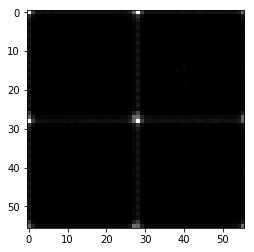

Epoch 1/2 Discriminator Loss: 0.4323 Generator loss: 10.2193
Epoch 1/2 Discriminator Loss: 0.4003 Generator loss: 9.5744
Epoch 1/2 Discriminator Loss: 0.3641 Generator loss: 9.3991
Epoch 1/2 Discriminator Loss: 0.3804 Generator loss: 8.7793
Epoch 1/2 Discriminator Loss: 0.3678 Generator loss: 8.5700
Epoch 1/2 Discriminator Loss: 0.3506 Generator loss: 8.5063
Epoch 1/2 Discriminator Loss: 0.3602 Generator loss: 8.4115
Epoch 1/2 Discriminator Loss: 0.3452 Generator loss: 8.3353
Epoch 1/2 Discriminator Loss: 0.3382 Generator loss: 7.9592
Epoch 1/2 Discriminator Loss: 0.3417 Generator loss: 7.3702
Epoch 1/2 Discriminator Loss: 0.3420 Generator loss: 7.1373
Epoch 1/2 Discriminator Loss: 0.3506 Generator loss: 6.7985
Epoch 1/2 Discriminator Loss: 0.3394 Generator loss: 6.7027
Epoch 1/2 Discriminator Loss: 0.3432 Generator loss: 6.3385
Epoch 1/2 Discriminator Loss: 0.3444 Generator loss: 5.8126
Epoch 1/2 Discriminator Loss: 0.3953 Generator loss: 3.4988
Epoch 1/2 Discriminator Loss: 0.6053 Ge

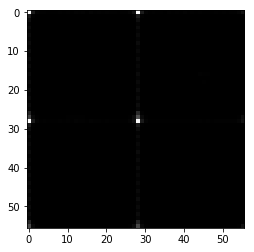

Epoch 1/2 Discriminator Loss: 1.1306 Generator loss: 0.9401
Epoch 1/2 Discriminator Loss: 1.8514 Generator loss: 5.6545
Epoch 1/2 Discriminator Loss: 1.2039 Generator loss: 0.9442
Epoch 1/2 Discriminator Loss: 0.4052 Generator loss: 3.6608
Epoch 1/2 Discriminator Loss: 0.4889 Generator loss: 4.4836
Epoch 1/2 Discriminator Loss: 0.5841 Generator loss: 2.0313
Epoch 1/2 Discriminator Loss: 0.7867 Generator loss: 1.4296
Epoch 1/2 Discriminator Loss: 0.8196 Generator loss: 2.4522
Epoch 1/2 Discriminator Loss: 1.6627 Generator loss: 0.6084
Epoch 1/2 Discriminator Loss: 2.3542 Generator loss: 6.6234
Epoch 1/2 Discriminator Loss: 1.5608 Generator loss: 1.2199
Epoch 1/2 Discriminator Loss: 0.7414 Generator loss: 1.6784
Epoch 1/2 Discriminator Loss: 0.7799 Generator loss: 3.3687
Epoch 1/2 Discriminator Loss: 0.6719 Generator loss: 1.7139
Epoch 1/2 Discriminator Loss: 0.9342 Generator loss: 1.0300
Epoch 1/2 Discriminator Loss: 1.4532 Generator loss: 2.9386
Epoch 1/2 Discriminator Loss: 3.3153 Gen

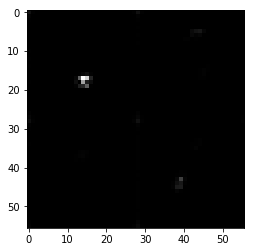

Epoch 1/2 Discriminator Loss: 2.2341 Generator loss: 0.3183
Epoch 1/2 Discriminator Loss: 2.5740 Generator loss: 9.3699
Epoch 1/2 Discriminator Loss: 0.5613 Generator loss: 2.6952
Epoch 1/2 Discriminator Loss: 0.9576 Generator loss: 1.1599
Epoch 1/2 Discriminator Loss: 0.5630 Generator loss: 3.0218
Epoch 1/2 Discriminator Loss: 1.1933 Generator loss: 0.6955
Epoch 1/2 Discriminator Loss: 1.2067 Generator loss: 4.2483
Epoch 1/2 Discriminator Loss: 0.4973 Generator loss: 2.7176
Epoch 1/2 Discriminator Loss: 0.5835 Generator loss: 2.0329
Epoch 1/2 Discriminator Loss: 0.4213 Generator loss: 3.7520
Epoch 1/2 Discriminator Loss: 0.3963 Generator loss: 4.0224
Epoch 1/2 Discriminator Loss: 0.3826 Generator loss: 3.7035
Epoch 1/2 Discriminator Loss: 0.3910 Generator loss: 3.4391
Epoch 1/2 Discriminator Loss: 0.4017 Generator loss: 3.3333
Epoch 1/2 Discriminator Loss: 0.4070 Generator loss: 3.1479
Epoch 1/2 Discriminator Loss: 0.3907 Generator loss: 3.3687
Epoch 1/2 Discriminator Loss: 0.3758 Gen

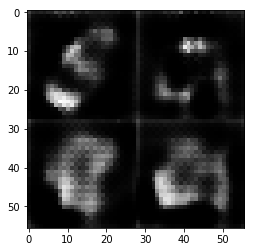

Epoch 1/2 Discriminator Loss: 0.4381 Generator loss: 2.8729
Epoch 1/2 Discriminator Loss: 0.3721 Generator loss: 4.9401
Epoch 1/2 Discriminator Loss: 0.9343 Generator loss: 1.0545
Epoch 1/2 Discriminator Loss: 4.0708 Generator loss: 7.0064
Epoch 1/2 Discriminator Loss: 1.5995 Generator loss: 0.7542
Epoch 1/2 Discriminator Loss: 0.3868 Generator loss: 6.8259
Epoch 1/2 Discriminator Loss: 0.8512 Generator loss: 5.5316
Epoch 1/2 Discriminator Loss: 0.5267 Generator loss: 3.3989
Epoch 1/2 Discriminator Loss: 0.8567 Generator loss: 1.2705
Epoch 1/2 Discriminator Loss: 2.3433 Generator loss: 0.2379
Epoch 1/2 Discriminator Loss: 3.4514 Generator loss: 2.3718
Epoch 1/2 Discriminator Loss: 2.0851 Generator loss: 1.4020
Epoch 1/2 Discriminator Loss: 1.3055 Generator loss: 0.7290
Epoch 1/2 Discriminator Loss: 1.0903 Generator loss: 1.6068
Epoch 1/2 Discriminator Loss: 1.1293 Generator loss: 1.0397
Epoch 1/2 Discriminator Loss: 1.2203 Generator loss: 0.9628
Epoch 1/2 Discriminator Loss: 1.0770 Gen

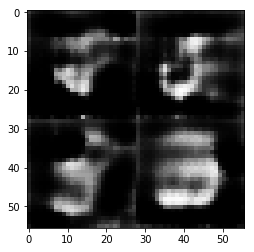

Epoch 1/2 Discriminator Loss: 0.4211 Generator loss: 2.9945
Epoch 1/2 Discriminator Loss: 0.4200 Generator loss: 3.2134
Epoch 1/2 Discriminator Loss: 0.4334 Generator loss: 2.7210
Epoch 1/2 Discriminator Loss: 0.4078 Generator loss: 3.8266
Epoch 1/2 Discriminator Loss: 0.6097 Generator loss: 1.8464
Epoch 1/2 Discriminator Loss: 0.7089 Generator loss: 4.8493
Epoch 1/2 Discriminator Loss: 2.7238 Generator loss: 0.2333
Epoch 1/2 Discriminator Loss: 4.3684 Generator loss: 7.9464
Epoch 1/2 Discriminator Loss: 0.9282 Generator loss: 2.2155
Epoch 1/2 Discriminator Loss: 3.4842 Generator loss: 0.1273
Epoch 1/2 Discriminator Loss: 1.3419 Generator loss: 3.4795
Epoch 1/2 Discriminator Loss: 1.0032 Generator loss: 3.3014
Epoch 1/2 Discriminator Loss: 0.6404 Generator loss: 1.4297
Epoch 1/2 Discriminator Loss: 0.8459 Generator loss: 1.0656
Epoch 1/2 Discriminator Loss: 0.6499 Generator loss: 1.8851
Epoch 1/2 Discriminator Loss: 0.6530 Generator loss: 2.1989
Epoch 1/2 Discriminator Loss: 0.5502 Gen

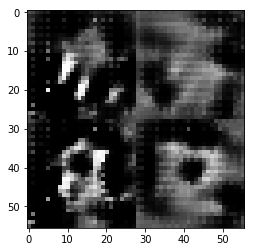

Epoch 1/2 Discriminator Loss: 0.7976 Generator loss: 3.7616
Epoch 1/2 Discriminator Loss: 0.9335 Generator loss: 0.9079
Epoch 1/2 Discriminator Loss: 0.7050 Generator loss: 4.0250
Epoch 1/2 Discriminator Loss: 0.4410 Generator loss: 2.6927
Epoch 1/2 Discriminator Loss: 0.7262 Generator loss: 1.3650
Epoch 1/2 Discriminator Loss: 0.4426 Generator loss: 3.3567
Epoch 1/2 Discriminator Loss: 0.5125 Generator loss: 2.2241
Epoch 1/2 Discriminator Loss: 0.4378 Generator loss: 2.8305
Epoch 1/2 Discriminator Loss: 0.3384 Generator loss: 6.6499
Epoch 1/2 Discriminator Loss: 0.3416 Generator loss: 5.6452
Epoch 1/2 Discriminator Loss: 0.3547 Generator loss: 4.5774
Epoch 1/2 Discriminator Loss: 0.4076 Generator loss: 2.9415
Epoch 1/2 Discriminator Loss: 0.4075 Generator loss: 3.4957
Epoch 1/2 Discriminator Loss: 0.3509 Generator loss: 4.3745
Epoch 1/2 Discriminator Loss: 0.5921 Generator loss: 1.7590
Epoch 1/2 Discriminator Loss: 0.4344 Generator loss: 2.9729
Epoch 1/2 Discriminator Loss: 0.4358 Gen

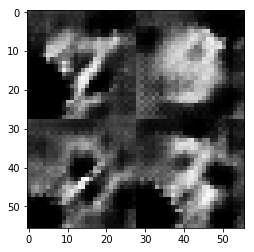

Epoch 1/2 Discriminator Loss: 0.4317 Generator loss: 3.3065
Epoch 1/2 Discriminator Loss: 0.7226 Generator loss: 1.5873
Epoch 1/2 Discriminator Loss: 2.1423 Generator loss: 6.5631
Epoch 1/2 Discriminator Loss: 3.0117 Generator loss: 0.1603
Epoch 1/2 Discriminator Loss: 1.0266 Generator loss: 2.2229
Epoch 1/2 Discriminator Loss: 1.8737 Generator loss: 2.3299
Epoch 1/2 Discriminator Loss: 1.4074 Generator loss: 0.5332
Epoch 1/2 Discriminator Loss: 0.9553 Generator loss: 3.5271
Epoch 1/2 Discriminator Loss: 0.5351 Generator loss: 2.5037
Epoch 1/2 Discriminator Loss: 0.5652 Generator loss: 2.0263
Epoch 1/2 Discriminator Loss: 0.5683 Generator loss: 1.8655
Epoch 1/2 Discriminator Loss: 0.6407 Generator loss: 1.7385
Epoch 1/2 Discriminator Loss: 0.6207 Generator loss: 2.2468
Epoch 1/2 Discriminator Loss: 0.5148 Generator loss: 2.4568
Epoch 1/2 Discriminator Loss: 0.5205 Generator loss: 2.1520
Epoch 1/2 Discriminator Loss: 0.5100 Generator loss: 2.3351
Epoch 1/2 Discriminator Loss: 0.4922 Gen

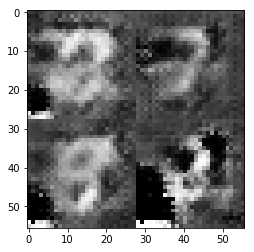

Epoch 1/2 Discriminator Loss: 0.4395 Generator loss: 4.0742
Epoch 1/2 Discriminator Loss: 0.4111 Generator loss: 4.3007
Epoch 1/2 Discriminator Loss: 0.4027 Generator loss: 3.8210
Epoch 1/2 Discriminator Loss: 0.4351 Generator loss: 4.3477
Epoch 1/2 Discriminator Loss: 0.4153 Generator loss: 3.7766
Epoch 1/2 Discriminator Loss: 0.3730 Generator loss: 4.3050
Epoch 1/2 Discriminator Loss: 0.3505 Generator loss: 5.2927
Epoch 1/2 Discriminator Loss: 0.3613 Generator loss: 4.6977
Epoch 1/2 Discriminator Loss: 0.4004 Generator loss: 3.6985
Epoch 1/2 Discriminator Loss: 0.4313 Generator loss: 3.4650
Epoch 1/2 Discriminator Loss: 0.5852 Generator loss: 2.4387
Epoch 1/2 Discriminator Loss: 0.4890 Generator loss: 5.0175
Epoch 1/2 Discriminator Loss: 0.6895 Generator loss: 2.1959
Epoch 1/2 Discriminator Loss: 0.4325 Generator loss: 3.9309
Epoch 1/2 Discriminator Loss: 0.4663 Generator loss: 4.0136
Epoch 1/2 Discriminator Loss: 0.4514 Generator loss: 3.5934
Epoch 1/2 Discriminator Loss: 0.4250 Gen

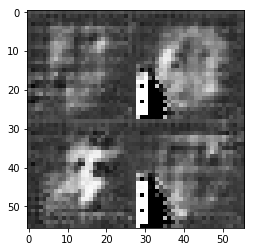

Epoch 1/2 Discriminator Loss: 0.3922 Generator loss: 4.5753
Epoch 1/2 Discriminator Loss: 0.3974 Generator loss: 4.4878
Epoch 1/2 Discriminator Loss: 0.5138 Generator loss: 3.0966
Epoch 1/2 Discriminator Loss: 0.3882 Generator loss: 4.9518
Epoch 1/2 Discriminator Loss: 0.3698 Generator loss: 6.0319
Epoch 1/2 Discriminator Loss: 0.3751 Generator loss: 4.9173
Epoch 1/2 Discriminator Loss: 0.4340 Generator loss: 3.9797
Epoch 1/2 Discriminator Loss: 0.3941 Generator loss: 4.6041
Epoch 1/2 Discriminator Loss: 0.4039 Generator loss: 4.1692
Epoch 1/2 Discriminator Loss: 0.3979 Generator loss: 4.3391
Epoch 1/2 Discriminator Loss: 0.3495 Generator loss: 5.9763
Epoch 1/2 Discriminator Loss: 0.3602 Generator loss: 5.1356
Epoch 1/2 Discriminator Loss: 0.3766 Generator loss: 4.5112
Epoch 1/2 Discriminator Loss: 0.3483 Generator loss: 6.0308
Epoch 1/2 Discriminator Loss: 0.3613 Generator loss: 5.2341
Epoch 1/2 Discriminator Loss: 0.4092 Generator loss: 4.1755
Epoch 1/2 Discriminator Loss: 0.3596 Gen

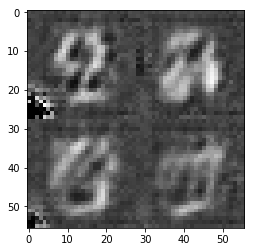

Epoch 1/2 Discriminator Loss: 1.1060 Generator loss: 1.4165
Epoch 1/2 Discriminator Loss: 1.7517 Generator loss: 0.3403
Epoch 1/2 Discriminator Loss: 1.1706 Generator loss: 2.4219
Epoch 1/2 Discriminator Loss: 0.9032 Generator loss: 1.3017
Epoch 1/2 Discriminator Loss: 1.2794 Generator loss: 0.7402
Epoch 1/2 Discriminator Loss: 1.2617 Generator loss: 1.5210
Epoch 1/2 Discriminator Loss: 1.2114 Generator loss: 0.8225
Epoch 1/2 Discriminator Loss: 0.9710 Generator loss: 1.0709
Epoch 1/2 Discriminator Loss: 0.7195 Generator loss: 1.9886
Epoch 1/2 Discriminator Loss: 0.8845 Generator loss: 1.1430
Epoch 1/2 Discriminator Loss: 0.7339 Generator loss: 2.4723
Epoch 1/2 Discriminator Loss: 0.9391 Generator loss: 1.2879
Epoch 1/2 Discriminator Loss: 0.9237 Generator loss: 1.7636
Epoch 1/2 Discriminator Loss: 1.0629 Generator loss: 0.9451
Epoch 1/2 Discriminator Loss: 1.7431 Generator loss: 3.4889
Epoch 1/2 Discriminator Loss: 2.6966 Generator loss: 0.3509
Epoch 1/2 Discriminator Loss: 0.5440 Gen

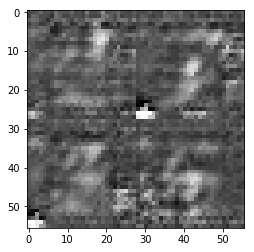

Epoch 1/2 Discriminator Loss: 0.3847 Generator loss: 4.3652
Epoch 1/2 Discriminator Loss: 0.3666 Generator loss: 5.2125
Epoch 1/2 Discriminator Loss: 0.4090 Generator loss: 4.0448
Epoch 1/2 Discriminator Loss: 0.4741 Generator loss: 3.2116
Epoch 1/2 Discriminator Loss: 0.4334 Generator loss: 3.9883
Epoch 1/2 Discriminator Loss: 0.4595 Generator loss: 4.0326
Epoch 1/2 Discriminator Loss: 0.4985 Generator loss: 3.0600
Epoch 1/2 Discriminator Loss: 0.4394 Generator loss: 3.6005
Epoch 1/2 Discriminator Loss: 0.4445 Generator loss: 4.2563
Epoch 1/2 Discriminator Loss: 0.7882 Generator loss: 2.3462
Epoch 1/2 Discriminator Loss: 0.7071 Generator loss: 5.1208
Epoch 1/2 Discriminator Loss: 0.3572 Generator loss: 6.5956
Epoch 1/2 Discriminator Loss: 0.4853 Generator loss: 3.8706
Epoch 1/2 Discriminator Loss: 0.3976 Generator loss: 4.3384
Epoch 1/2 Discriminator Loss: 0.4427 Generator loss: 6.6957
Epoch 1/2 Discriminator Loss: 0.4276 Generator loss: 4.4706
Epoch 1/2 Discriminator Loss: 0.4050 Gen

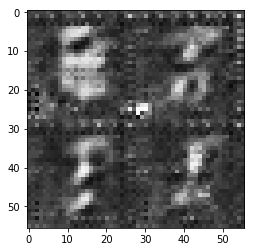

Epoch 1/2 Discriminator Loss: 0.3866 Generator loss: 4.5583
Epoch 1/2 Discriminator Loss: 0.3579 Generator loss: 5.3693
Epoch 1/2 Discriminator Loss: 0.3655 Generator loss: 4.5812
Epoch 1/2 Discriminator Loss: 0.3940 Generator loss: 4.2111
Epoch 1/2 Discriminator Loss: 0.4166 Generator loss: 4.0984
Epoch 1/2 Discriminator Loss: 0.3870 Generator loss: 4.4870
Epoch 1/2 Discriminator Loss: 0.3576 Generator loss: 5.2056
Epoch 1/2 Discriminator Loss: 0.3548 Generator loss: 5.2808
Epoch 1/2 Discriminator Loss: 0.3865 Generator loss: 4.4164
Epoch 1/2 Discriminator Loss: 0.4410 Generator loss: 3.7027
Epoch 1/2 Discriminator Loss: 0.3954 Generator loss: 4.1061
Epoch 1/2 Discriminator Loss: 0.3477 Generator loss: 5.7501
Epoch 1/2 Discriminator Loss: 0.3327 Generator loss: 7.8059
Epoch 1/2 Discriminator Loss: 0.3494 Generator loss: 5.6919
Epoch 1/2 Discriminator Loss: 0.3494 Generator loss: 5.4562
Epoch 1/2 Discriminator Loss: 0.3513 Generator loss: 5.0674
Epoch 1/2 Discriminator Loss: 0.3437 Gen

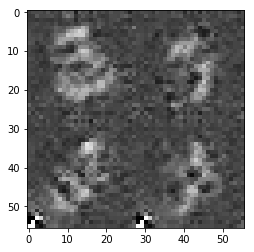

Epoch 1/2 Discriminator Loss: 0.3735 Generator loss: 3.9206
Epoch 1/2 Discriminator Loss: 0.3546 Generator loss: 5.9297
Epoch 1/2 Discriminator Loss: 0.5097 Generator loss: 2.8447
Epoch 1/2 Discriminator Loss: 0.3488 Generator loss: 5.3985
Epoch 1/2 Discriminator Loss: 0.3750 Generator loss: 6.0146
Epoch 1/2 Discriminator Loss: 0.3673 Generator loss: 4.8637
Epoch 1/2 Discriminator Loss: 0.3604 Generator loss: 5.9027
Epoch 1/2 Discriminator Loss: 0.5062 Generator loss: 3.3949
Epoch 1/2 Discriminator Loss: 0.3657 Generator loss: 5.1545
Epoch 1/2 Discriminator Loss: 0.4884 Generator loss: 5.1146
Epoch 1/2 Discriminator Loss: 0.7039 Generator loss: 2.7563
Epoch 1/2 Discriminator Loss: 1.8117 Generator loss: 0.8758
Epoch 1/2 Discriminator Loss: 7.9529 Generator loss: 10.0358
Epoch 1/2 Discriminator Loss: 0.8556 Generator loss: 1.5211
Epoch 1/2 Discriminator Loss: 0.8639 Generator loss: 1.2662
Epoch 1/2 Discriminator Loss: 1.1104 Generator loss: 2.5456
Epoch 1/2 Discriminator Loss: 1.3131 Ge

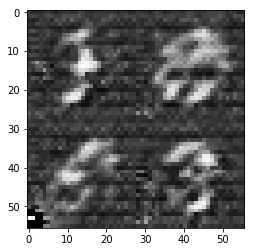

Epoch 1/2 Discriminator Loss: 0.7568 Generator loss: 1.3237
Epoch 1/2 Discriminator Loss: 0.6171 Generator loss: 2.8419
Epoch 1/2 Discriminator Loss: 0.6562 Generator loss: 1.6969
Epoch 1/2 Discriminator Loss: 0.5622 Generator loss: 2.0954
Epoch 1/2 Discriminator Loss: 0.5381 Generator loss: 2.5593
Epoch 1/2 Discriminator Loss: 0.3853 Generator loss: 4.4378
Epoch 1/2 Discriminator Loss: 0.4717 Generator loss: 2.8527
Epoch 1/2 Discriminator Loss: 0.4490 Generator loss: 2.9596
Epoch 1/2 Discriminator Loss: 0.5202 Generator loss: 2.3869
Epoch 1/2 Discriminator Loss: 0.5221 Generator loss: 3.6224
Epoch 1/2 Discriminator Loss: 0.6297 Generator loss: 2.0227
Epoch 1/2 Discriminator Loss: 0.4033 Generator loss: 3.8577
Epoch 1/2 Discriminator Loss: 0.4404 Generator loss: 3.4207
Epoch 1/2 Discriminator Loss: 0.4460 Generator loss: 3.0292
Epoch 1/2 Discriminator Loss: 0.4410 Generator loss: 3.1410
Epoch 1/2 Discriminator Loss: 0.4702 Generator loss: 3.0030
Epoch 1/2 Discriminator Loss: 0.3807 Gen

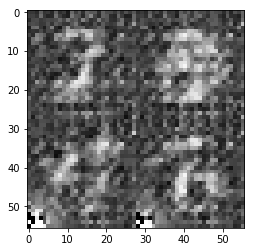

Epoch 1/2 Discriminator Loss: 0.4378 Generator loss: 3.1328
Epoch 1/2 Discriminator Loss: 0.3989 Generator loss: 4.8806
Epoch 1/2 Discriminator Loss: 0.3349 Generator loss: 6.6053
Epoch 1/2 Discriminator Loss: 0.3446 Generator loss: 5.4456
Epoch 1/2 Discriminator Loss: 0.3616 Generator loss: 4.5074
Epoch 1/2 Discriminator Loss: 0.3556 Generator loss: 4.4919
Epoch 1/2 Discriminator Loss: 0.3414 Generator loss: 6.0159
Epoch 1/2 Discriminator Loss: 0.3601 Generator loss: 4.1102
Epoch 1/2 Discriminator Loss: 0.3661 Generator loss: 4.3694
Epoch 1/2 Discriminator Loss: 0.3546 Generator loss: 4.6118
Epoch 1/2 Discriminator Loss: 0.3832 Generator loss: 3.5747
Epoch 1/2 Discriminator Loss: 0.3844 Generator loss: 4.4222
Epoch 1/2 Discriminator Loss: 0.3761 Generator loss: 4.2164
Epoch 1/2 Discriminator Loss: 0.3685 Generator loss: 4.0835
Epoch 1/2 Discriminator Loss: 0.3829 Generator loss: 3.9569
Epoch 1/2 Discriminator Loss: 0.3400 Generator loss: 6.2120
Epoch 1/2 Discriminator Loss: 0.3420 Gen

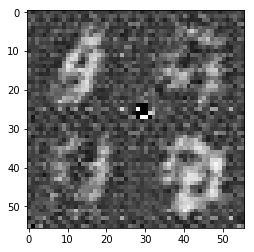

Epoch 1/2 Discriminator Loss: 0.4346 Generator loss: 3.0355
Epoch 1/2 Discriminator Loss: 0.3603 Generator loss: 4.8864
Epoch 1/2 Discriminator Loss: 0.3676 Generator loss: 3.9216
Epoch 1/2 Discriminator Loss: 0.3836 Generator loss: 3.8741
Epoch 1/2 Discriminator Loss: 0.3870 Generator loss: 3.7657
Epoch 1/2 Discriminator Loss: 0.4202 Generator loss: 2.8163
Epoch 1/2 Discriminator Loss: 0.3715 Generator loss: 4.2501
Epoch 1/2 Discriminator Loss: 0.3579 Generator loss: 4.7794
Epoch 1/2 Discriminator Loss: 0.3898 Generator loss: 3.7492
Epoch 1/2 Discriminator Loss: 0.3817 Generator loss: 3.8796
Epoch 1/2 Discriminator Loss: 0.3500 Generator loss: 5.4342
Epoch 1/2 Discriminator Loss: 0.3981 Generator loss: 3.2858
Epoch 1/2 Discriminator Loss: 0.3980 Generator loss: 3.4411
Epoch 1/2 Discriminator Loss: 0.3421 Generator loss: 5.5863
Epoch 1/2 Discriminator Loss: 0.3625 Generator loss: 4.5295
Epoch 1/2 Discriminator Loss: 0.3687 Generator loss: 3.9925
Epoch 1/2 Discriminator Loss: 0.3509 Gen

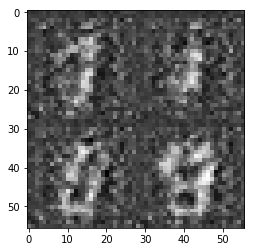

Epoch 1/2 Discriminator Loss: 0.3534 Generator loss: 4.5078
Epoch 1/2 Discriminator Loss: 0.3457 Generator loss: 4.8908
Epoch 1/2 Discriminator Loss: 0.3408 Generator loss: 6.0263
Epoch 1/2 Discriminator Loss: 0.3336 Generator loss: 6.0684
Epoch 1/2 Discriminator Loss: 0.3458 Generator loss: 4.8853
Epoch 1/2 Discriminator Loss: 0.3366 Generator loss: 5.9873
Epoch 1/2 Discriminator Loss: 0.3352 Generator loss: 5.8042
Epoch 1/2 Discriminator Loss: 0.3534 Generator loss: 4.6085
Epoch 1/2 Discriminator Loss: 0.3369 Generator loss: 5.9972
Epoch 1/2 Discriminator Loss: 0.4498 Generator loss: 2.7568
Epoch 1/2 Discriminator Loss: 0.3506 Generator loss: 6.2024
Epoch 1/2 Discriminator Loss: 0.3339 Generator loss: 6.7979
Epoch 1/2 Discriminator Loss: 0.3599 Generator loss: 4.3456
Epoch 1/2 Discriminator Loss: 0.3514 Generator loss: 4.8167
Epoch 1/2 Discriminator Loss: 0.3549 Generator loss: 4.7301
Epoch 1/2 Discriminator Loss: 0.3628 Generator loss: 4.0207
Epoch 1/2 Discriminator Loss: 0.3541 Gen

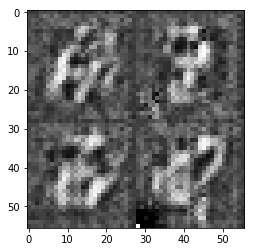

Epoch 1/2 Discriminator Loss: 1.6236 Generator loss: 0.4251
Epoch 1/2 Discriminator Loss: 1.7414 Generator loss: 2.1743
Epoch 1/2 Discriminator Loss: 1.3336 Generator loss: 0.6636
Epoch 1/2 Discriminator Loss: 1.0155 Generator loss: 1.0978
Epoch 1/2 Discriminator Loss: 1.1040 Generator loss: 1.2060
Epoch 1/2 Discriminator Loss: 1.1445 Generator loss: 0.9867
Epoch 1/2 Discriminator Loss: 1.0655 Generator loss: 1.1794
Epoch 1/2 Discriminator Loss: 1.1433 Generator loss: 1.0230
Epoch 1/2 Discriminator Loss: 1.0610 Generator loss: 1.1566
Epoch 1/2 Discriminator Loss: 0.9962 Generator loss: 0.9590
Epoch 1/2 Discriminator Loss: 0.9823 Generator loss: 2.9638
Epoch 1/2 Discriminator Loss: 1.4613 Generator loss: 0.8061
Epoch 1/2 Discriminator Loss: 1.5110 Generator loss: 4.3217
Epoch 1/2 Discriminator Loss: 1.5574 Generator loss: 0.7882
Epoch 1/2 Discriminator Loss: 0.7214 Generator loss: 2.5514
Epoch 1/2 Discriminator Loss: 1.6410 Generator loss: 0.4972
Epoch 1/2 Discriminator Loss: 1.3134 Gen

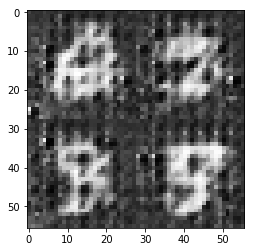

Epoch 1/2 Discriminator Loss: 0.5258 Generator loss: 2.0934
Epoch 1/2 Discriminator Loss: 0.4233 Generator loss: 3.2833
Epoch 1/2 Discriminator Loss: 0.4579 Generator loss: 3.3806
Epoch 1/2 Discriminator Loss: 0.3829 Generator loss: 3.8151
Epoch 1/2 Discriminator Loss: 0.3928 Generator loss: 3.9064
Epoch 1/2 Discriminator Loss: 0.3683 Generator loss: 4.2052
Epoch 1/2 Discriminator Loss: 0.3798 Generator loss: 3.8630
Epoch 1/2 Discriminator Loss: 0.4117 Generator loss: 3.1308
Epoch 1/2 Discriminator Loss: 0.4073 Generator loss: 3.0842
Epoch 1/2 Discriminator Loss: 0.5386 Generator loss: 2.3904
Epoch 1/2 Discriminator Loss: 0.4910 Generator loss: 3.3741
Epoch 1/2 Discriminator Loss: 0.4215 Generator loss: 3.7179
Epoch 1/2 Discriminator Loss: 0.4094 Generator loss: 3.9623
Epoch 1/2 Discriminator Loss: 0.4565 Generator loss: 3.0668
Epoch 1/2 Discriminator Loss: 0.3664 Generator loss: 5.8067
Epoch 1/2 Discriminator Loss: 0.4811 Generator loss: 2.6498
Epoch 1/2 Discriminator Loss: 0.4022 Gen

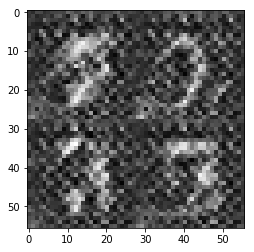

Epoch 1/2 Discriminator Loss: 0.3845 Generator loss: 3.7422
Epoch 1/2 Discriminator Loss: 0.4393 Generator loss: 2.7586
Epoch 1/2 Discriminator Loss: 0.4079 Generator loss: 4.7510
Epoch 1/2 Discriminator Loss: 0.4587 Generator loss: 2.9407
Epoch 1/2 Discriminator Loss: 0.3532 Generator loss: 4.9087
Epoch 1/2 Discriminator Loss: 0.3676 Generator loss: 4.7684
Epoch 1/2 Discriminator Loss: 0.3476 Generator loss: 4.6709
Epoch 1/2 Discriminator Loss: 0.3333 Generator loss: 7.1358
Epoch 1/2 Discriminator Loss: 0.3435 Generator loss: 4.5596
Epoch 1/2 Discriminator Loss: 0.3474 Generator loss: 4.9863
Epoch 1/2 Discriminator Loss: 0.3946 Generator loss: 3.7249
Epoch 1/2 Discriminator Loss: 0.3950 Generator loss: 3.6024
Epoch 1/2 Discriminator Loss: 0.3577 Generator loss: 4.9806
Epoch 1/2 Discriminator Loss: 0.3556 Generator loss: 4.1174
Epoch 1/2 Discriminator Loss: 0.3817 Generator loss: 4.3884
Epoch 1/2 Discriminator Loss: 0.3399 Generator loss: 6.2962
Epoch 1/2 Discriminator Loss: 0.3598 Gen

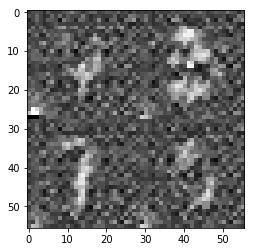

Epoch 1/2 Discriminator Loss: 0.3381 Generator loss: 5.5453
Epoch 1/2 Discriminator Loss: 0.3324 Generator loss: 6.8374
Epoch 1/2 Discriminator Loss: 0.3315 Generator loss: 7.0060
Epoch 1/2 Discriminator Loss: 0.3297 Generator loss: 6.7194
Epoch 1/2 Discriminator Loss: 0.3407 Generator loss: 4.9612
Epoch 1/2 Discriminator Loss: 0.3321 Generator loss: 5.8404
Epoch 1/2 Discriminator Loss: 0.3773 Generator loss: 3.7471
Epoch 1/2 Discriminator Loss: 0.3343 Generator loss: 6.0559
Epoch 1/2 Discriminator Loss: 0.3320 Generator loss: 7.4191
Epoch 1/2 Discriminator Loss: 0.3300 Generator loss: 8.4783
Epoch 1/2 Discriminator Loss: 0.3363 Generator loss: 5.8433
Epoch 1/2 Discriminator Loss: 0.3386 Generator loss: 6.0377
Epoch 1/2 Discriminator Loss: 0.4142 Generator loss: 3.1700
Epoch 1/2 Discriminator Loss: 0.3413 Generator loss: 5.4730
Epoch 1/2 Discriminator Loss: 0.3419 Generator loss: 5.3449
Epoch 1/2 Discriminator Loss: 0.3793 Generator loss: 4.0392
Epoch 1/2 Discriminator Loss: 0.3350 Gen

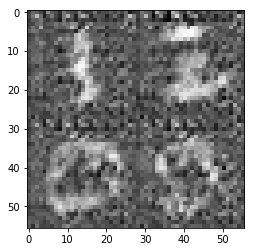

Epoch 1/2 Discriminator Loss: 2.1731 Generator loss: 1.4867
Epoch 1/2 Discriminator Loss: 5.2478 Generator loss: 0.0154
Epoch 1/2 Discriminator Loss: 1.2066 Generator loss: 4.5648
Epoch 1/2 Discriminator Loss: 1.2044 Generator loss: 1.8461
Epoch 1/2 Discriminator Loss: 0.8542 Generator loss: 1.5043
Epoch 1/2 Discriminator Loss: 0.8560 Generator loss: 2.1368
Epoch 1/2 Discriminator Loss: 1.0354 Generator loss: 1.0248
Epoch 1/2 Discriminator Loss: 0.8541 Generator loss: 1.6688
Epoch 1/2 Discriminator Loss: 0.6827 Generator loss: 2.2283
Epoch 1/2 Discriminator Loss: 0.7911 Generator loss: 1.3329
Epoch 1/2 Discriminator Loss: 0.7234 Generator loss: 1.4382
Epoch 1/2 Discriminator Loss: 0.6182 Generator loss: 2.6153
Epoch 1/2 Discriminator Loss: 0.9311 Generator loss: 1.0370
Epoch 1/2 Discriminator Loss: 0.6761 Generator loss: 3.1086
Epoch 1/2 Discriminator Loss: 1.6209 Generator loss: 0.4668
Epoch 1/2 Discriminator Loss: 2.5769 Generator loss: 5.9835
Epoch 1/2 Discriminator Loss: 1.5800 Gen

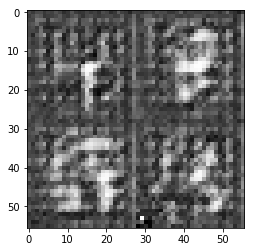

Epoch 1/2 Discriminator Loss: 1.3531 Generator loss: 1.7281
Epoch 1/2 Discriminator Loss: 1.3738 Generator loss: 0.6919
Epoch 1/2 Discriminator Loss: 1.3023 Generator loss: 2.0077
Epoch 2/2 Discriminator Loss: 1.5593 Generator loss: 0.4675
Epoch 2/2 Discriminator Loss: 1.4507 Generator loss: 1.9862
Epoch 2/2 Discriminator Loss: 1.5017 Generator loss: 0.7274
Epoch 2/2 Discriminator Loss: 1.0699 Generator loss: 2.2491
Epoch 2/2 Discriminator Loss: 0.9317 Generator loss: 1.0539
Epoch 2/2 Discriminator Loss: 0.9703 Generator loss: 1.0123
Epoch 2/2 Discriminator Loss: 1.3711 Generator loss: 3.1134
Epoch 2/2 Discriminator Loss: 1.8416 Generator loss: 0.3799
Epoch 2/2 Discriminator Loss: 1.2743 Generator loss: 4.2059
Epoch 2/2 Discriminator Loss: 0.8830 Generator loss: 1.3040
Epoch 2/2 Discriminator Loss: 0.9630 Generator loss: 1.1086
Epoch 2/2 Discriminator Loss: 1.6573 Generator loss: 2.4427
Epoch 2/2 Discriminator Loss: 2.1463 Generator loss: 0.3544
Epoch 2/2 Discriminator Loss: 1.6804 Gen

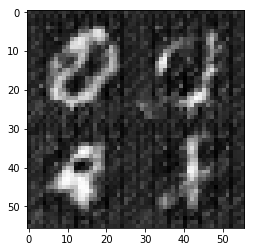

Epoch 2/2 Discriminator Loss: 0.4495 Generator loss: 2.9551
Epoch 2/2 Discriminator Loss: 0.3609 Generator loss: 6.3657
Epoch 2/2 Discriminator Loss: 0.3704 Generator loss: 8.3551
Epoch 2/2 Discriminator Loss: 0.3752 Generator loss: 5.2399
Epoch 2/2 Discriminator Loss: 0.4198 Generator loss: 3.6447
Epoch 2/2 Discriminator Loss: 0.4461 Generator loss: 3.3257
Epoch 2/2 Discriminator Loss: 0.5061 Generator loss: 3.1675
Epoch 2/2 Discriminator Loss: 0.7887 Generator loss: 1.4619
Epoch 2/2 Discriminator Loss: 0.4506 Generator loss: 4.4853
Epoch 2/2 Discriminator Loss: 0.5329 Generator loss: 2.5887
Epoch 2/2 Discriminator Loss: 0.3409 Generator loss: 9.0701
Epoch 2/2 Discriminator Loss: 0.3384 Generator loss: 9.2947
Epoch 2/2 Discriminator Loss: 0.3371 Generator loss: 7.5053
Epoch 2/2 Discriminator Loss: 0.3424 Generator loss: 6.0980
Epoch 2/2 Discriminator Loss: 0.3529 Generator loss: 4.6819
Epoch 2/2 Discriminator Loss: 0.3418 Generator loss: 4.9699
Epoch 2/2 Discriminator Loss: 0.3392 Gen

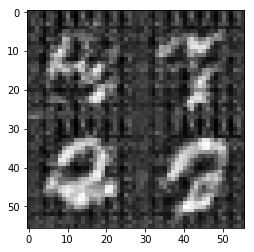

Epoch 2/2 Discriminator Loss: 1.2224 Generator loss: 1.5339
Epoch 2/2 Discriminator Loss: 1.2845 Generator loss: 0.7136
Epoch 2/2 Discriminator Loss: 1.2611 Generator loss: 2.0311
Epoch 2/2 Discriminator Loss: 1.2596 Generator loss: 0.7156
Epoch 2/2 Discriminator Loss: 1.0315 Generator loss: 1.9550
Epoch 2/2 Discriminator Loss: 1.0396 Generator loss: 0.9154
Epoch 2/2 Discriminator Loss: 0.9889 Generator loss: 1.0794
Epoch 2/2 Discriminator Loss: 1.0824 Generator loss: 1.4595
Epoch 2/2 Discriminator Loss: 1.0833 Generator loss: 0.7982
Epoch 2/2 Discriminator Loss: 0.9704 Generator loss: 1.6796
Epoch 2/2 Discriminator Loss: 1.0695 Generator loss: 0.8912
Epoch 2/2 Discriminator Loss: 1.1161 Generator loss: 0.9147
Epoch 2/2 Discriminator Loss: 1.1093 Generator loss: 1.3902
Epoch 2/2 Discriminator Loss: 1.0188 Generator loss: 0.9193
Epoch 2/2 Discriminator Loss: 0.8982 Generator loss: 2.4617
Epoch 2/2 Discriminator Loss: 1.6485 Generator loss: 0.3782
Epoch 2/2 Discriminator Loss: 1.6998 Gen

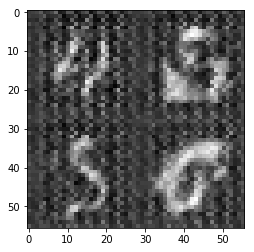

Epoch 2/2 Discriminator Loss: 1.7168 Generator loss: 0.4465
Epoch 2/2 Discriminator Loss: 0.9583 Generator loss: 1.5059
Epoch 2/2 Discriminator Loss: 0.9605 Generator loss: 1.5617
Epoch 2/2 Discriminator Loss: 1.0780 Generator loss: 0.7513
Epoch 2/2 Discriminator Loss: 0.8948 Generator loss: 1.4395
Epoch 2/2 Discriminator Loss: 0.8558 Generator loss: 1.3305
Epoch 2/2 Discriminator Loss: 0.8214 Generator loss: 1.4203
Epoch 2/2 Discriminator Loss: 0.9890 Generator loss: 0.9986
Epoch 2/2 Discriminator Loss: 1.0157 Generator loss: 1.2165
Epoch 2/2 Discriminator Loss: 0.9926 Generator loss: 1.0561
Epoch 2/2 Discriminator Loss: 1.0577 Generator loss: 0.9480
Epoch 2/2 Discriminator Loss: 1.2599 Generator loss: 1.8858
Epoch 2/2 Discriminator Loss: 1.7255 Generator loss: 0.3714
Epoch 2/2 Discriminator Loss: 1.5549 Generator loss: 2.8031
Epoch 2/2 Discriminator Loss: 1.3182 Generator loss: 0.6498
Epoch 2/2 Discriminator Loss: 1.1897 Generator loss: 0.7747
Epoch 2/2 Discriminator Loss: 1.1322 Gen

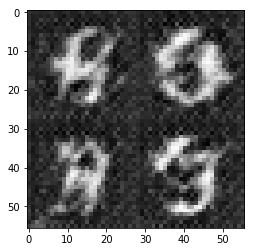

Epoch 2/2 Discriminator Loss: 1.3726 Generator loss: 0.5258
Epoch 2/2 Discriminator Loss: 1.6211 Generator loss: 3.0706
Epoch 2/2 Discriminator Loss: 0.9925 Generator loss: 0.9902
Epoch 2/2 Discriminator Loss: 1.4026 Generator loss: 0.5482
Epoch 2/2 Discriminator Loss: 1.1490 Generator loss: 1.6486
Epoch 2/2 Discriminator Loss: 1.0501 Generator loss: 0.8888
Epoch 2/2 Discriminator Loss: 0.9462 Generator loss: 1.3843
Epoch 2/2 Discriminator Loss: 0.8598 Generator loss: 1.2191
Epoch 2/2 Discriminator Loss: 0.9485 Generator loss: 0.9664
Epoch 2/2 Discriminator Loss: 0.9283 Generator loss: 1.7106
Epoch 2/2 Discriminator Loss: 1.0090 Generator loss: 0.8062
Epoch 2/2 Discriminator Loss: 1.0850 Generator loss: 1.5616
Epoch 2/2 Discriminator Loss: 1.1747 Generator loss: 0.7000
Epoch 2/2 Discriminator Loss: 1.0227 Generator loss: 1.5600
Epoch 2/2 Discriminator Loss: 1.1137 Generator loss: 0.7519
Epoch 2/2 Discriminator Loss: 1.0332 Generator loss: 1.3720
Epoch 2/2 Discriminator Loss: 0.9828 Gen

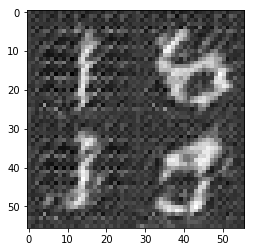

Epoch 2/2 Discriminator Loss: 0.4774 Generator loss: 2.5192
Epoch 2/2 Discriminator Loss: 0.4754 Generator loss: 2.4280
Epoch 2/2 Discriminator Loss: 0.3736 Generator loss: 3.9485
Epoch 2/2 Discriminator Loss: 0.3740 Generator loss: 3.6184
Epoch 2/2 Discriminator Loss: 0.7369 Generator loss: 1.2415
Epoch 2/2 Discriminator Loss: 0.6012 Generator loss: 4.5982
Epoch 2/2 Discriminator Loss: 0.8439 Generator loss: 1.3061
Epoch 2/2 Discriminator Loss: 0.6710 Generator loss: 4.6203
Epoch 2/2 Discriminator Loss: 0.4335 Generator loss: 5.5976
Epoch 2/2 Discriminator Loss: 0.3913 Generator loss: 3.3965
Epoch 2/2 Discriminator Loss: 0.5255 Generator loss: 1.9862
Epoch 2/2 Discriminator Loss: 0.4918 Generator loss: 2.4847
Epoch 2/2 Discriminator Loss: 0.5701 Generator loss: 1.7034
Epoch 2/2 Discriminator Loss: 0.7566 Generator loss: 1.3406
Epoch 2/2 Discriminator Loss: 0.4499 Generator loss: 4.4405
Epoch 2/2 Discriminator Loss: 0.4035 Generator loss: 6.7436
Epoch 2/2 Discriminator Loss: 0.3650 Gen

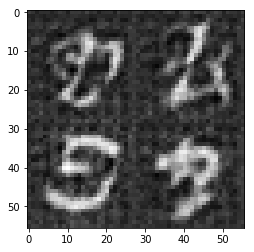

Epoch 2/2 Discriminator Loss: 0.8332 Generator loss: 1.5664
Epoch 2/2 Discriminator Loss: 1.7497 Generator loss: 0.3326
Epoch 2/2 Discriminator Loss: 2.0551 Generator loss: 4.2047
Epoch 2/2 Discriminator Loss: 1.5073 Generator loss: 0.4958
Epoch 2/2 Discriminator Loss: 0.8131 Generator loss: 1.4166
Epoch 2/2 Discriminator Loss: 0.8220 Generator loss: 1.8405
Epoch 2/2 Discriminator Loss: 1.0883 Generator loss: 0.7158
Epoch 2/2 Discriminator Loss: 0.7944 Generator loss: 1.5373
Epoch 2/2 Discriminator Loss: 0.8888 Generator loss: 1.0487
Epoch 2/2 Discriminator Loss: 0.6050 Generator loss: 1.8821
Epoch 2/2 Discriminator Loss: 0.8427 Generator loss: 1.0807
Epoch 2/2 Discriminator Loss: 0.7255 Generator loss: 2.4600
Epoch 2/2 Discriminator Loss: 1.7950 Generator loss: 0.3305
Epoch 2/2 Discriminator Loss: 1.4898 Generator loss: 3.5496
Epoch 2/2 Discriminator Loss: 1.2640 Generator loss: 0.7035
Epoch 2/2 Discriminator Loss: 0.8399 Generator loss: 2.0547
Epoch 2/2 Discriminator Loss: 0.9510 Gen

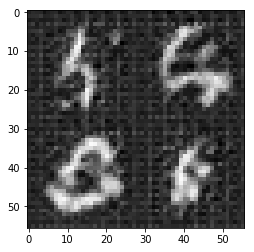

Epoch 2/2 Discriminator Loss: 0.4670 Generator loss: 2.6971
Epoch 2/2 Discriminator Loss: 0.3669 Generator loss: 4.0175
Epoch 2/2 Discriminator Loss: 0.5079 Generator loss: 2.4406
Epoch 2/2 Discriminator Loss: 0.8230 Generator loss: 1.1462
Epoch 2/2 Discriminator Loss: 1.2505 Generator loss: 5.5030
Epoch 2/2 Discriminator Loss: 0.7540 Generator loss: 2.3436
Epoch 2/2 Discriminator Loss: 3.0108 Generator loss: 0.1538
Epoch 2/2 Discriminator Loss: 3.1203 Generator loss: 5.0011
Epoch 2/2 Discriminator Loss: 1.1684 Generator loss: 1.1212
Epoch 2/2 Discriminator Loss: 1.2650 Generator loss: 0.7119
Epoch 2/2 Discriminator Loss: 1.2138 Generator loss: 2.3815
Epoch 2/2 Discriminator Loss: 1.0996 Generator loss: 0.7565
Epoch 2/2 Discriminator Loss: 0.8268 Generator loss: 1.5884
Epoch 2/2 Discriminator Loss: 0.9203 Generator loss: 1.1907
Epoch 2/2 Discriminator Loss: 0.9276 Generator loss: 0.9815
Epoch 2/2 Discriminator Loss: 0.8444 Generator loss: 1.9454
Epoch 2/2 Discriminator Loss: 0.8862 Gen

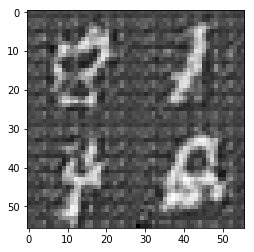

Epoch 2/2 Discriminator Loss: 1.0438 Generator loss: 0.8465
Epoch 2/2 Discriminator Loss: 1.9973 Generator loss: 2.8098
Epoch 2/2 Discriminator Loss: 3.8093 Generator loss: 0.0991
Epoch 2/2 Discriminator Loss: 1.0443 Generator loss: 4.0501
Epoch 2/2 Discriminator Loss: 1.0209 Generator loss: 1.6465
Epoch 2/2 Discriminator Loss: 1.4792 Generator loss: 0.5443
Epoch 2/2 Discriminator Loss: 0.8485 Generator loss: 2.8999
Epoch 2/2 Discriminator Loss: 0.9148 Generator loss: 1.0749
Epoch 2/2 Discriminator Loss: 1.0193 Generator loss: 0.8649
Epoch 2/2 Discriminator Loss: 0.7754 Generator loss: 2.1210
Epoch 2/2 Discriminator Loss: 0.8698 Generator loss: 1.0595
Epoch 2/2 Discriminator Loss: 0.5971 Generator loss: 1.8174
Epoch 2/2 Discriminator Loss: 0.6689 Generator loss: 1.5944
Epoch 2/2 Discriminator Loss: 0.7181 Generator loss: 1.4270
Epoch 2/2 Discriminator Loss: 1.0411 Generator loss: 0.7739
Epoch 2/2 Discriminator Loss: 0.8410 Generator loss: 2.2607
Epoch 2/2 Discriminator Loss: 1.0418 Gen

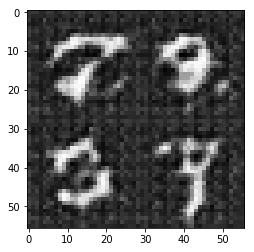

Epoch 2/2 Discriminator Loss: 0.3552 Generator loss: 4.2703
Epoch 2/2 Discriminator Loss: 0.3685 Generator loss: 3.6758
Epoch 2/2 Discriminator Loss: 0.5294 Generator loss: 1.8808
Epoch 2/2 Discriminator Loss: 0.4547 Generator loss: 2.5226
Epoch 2/2 Discriminator Loss: 0.3521 Generator loss: 6.1828
Epoch 2/2 Discriminator Loss: 0.3995 Generator loss: 3.4462
Epoch 2/2 Discriminator Loss: 0.5720 Generator loss: 1.7798
Epoch 2/2 Discriminator Loss: 0.8693 Generator loss: 1.0451
Epoch 2/2 Discriminator Loss: 0.6200 Generator loss: 5.5459
Epoch 2/2 Discriminator Loss: 0.6668 Generator loss: 1.5003
Epoch 2/2 Discriminator Loss: 1.3684 Generator loss: 1.0150
Epoch 2/2 Discriminator Loss: 1.3798 Generator loss: 0.5394
Epoch 2/2 Discriminator Loss: 0.4339 Generator loss: 3.9879
Epoch 2/2 Discriminator Loss: 0.4709 Generator loss: 2.4887
Epoch 2/2 Discriminator Loss: 0.6001 Generator loss: 1.7287
Epoch 2/2 Discriminator Loss: 0.5467 Generator loss: 1.9317
Epoch 2/2 Discriminator Loss: 0.5077 Gen

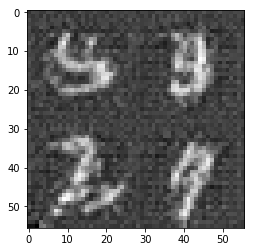

Epoch 2/2 Discriminator Loss: 0.8741 Generator loss: 1.8491
Epoch 2/2 Discriminator Loss: 1.9249 Generator loss: 0.3690
Epoch 2/2 Discriminator Loss: 1.3624 Generator loss: 3.0624
Epoch 2/2 Discriminator Loss: 0.9200 Generator loss: 0.9878
Epoch 2/2 Discriminator Loss: 0.8734 Generator loss: 1.1869
Epoch 2/2 Discriminator Loss: 0.8053 Generator loss: 1.6582
Epoch 2/2 Discriminator Loss: 0.8410 Generator loss: 1.2131
Epoch 2/2 Discriminator Loss: 0.8485 Generator loss: 1.0362
Epoch 2/2 Discriminator Loss: 0.7013 Generator loss: 1.6675
Epoch 2/2 Discriminator Loss: 0.7237 Generator loss: 1.4153
Epoch 2/2 Discriminator Loss: 0.7103 Generator loss: 1.3877
Epoch 2/2 Discriminator Loss: 0.4564 Generator loss: 3.6340
Epoch 2/2 Discriminator Loss: 0.6476 Generator loss: 1.5257
Epoch 2/2 Discriminator Loss: 0.6087 Generator loss: 1.6582
Epoch 2/2 Discriminator Loss: 0.7046 Generator loss: 1.9474
Epoch 2/2 Discriminator Loss: 0.4566 Generator loss: 2.3141
Epoch 2/2 Discriminator Loss: 0.6722 Gen

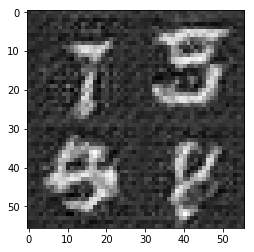

Epoch 2/2 Discriminator Loss: 0.7379 Generator loss: 1.5182
Epoch 2/2 Discriminator Loss: 0.8494 Generator loss: 1.0661
Epoch 2/2 Discriminator Loss: 0.7134 Generator loss: 1.7854
Epoch 2/2 Discriminator Loss: 0.9126 Generator loss: 0.9917
Epoch 2/2 Discriminator Loss: 0.7203 Generator loss: 1.4790
Epoch 2/2 Discriminator Loss: 0.6474 Generator loss: 1.8241
Epoch 2/2 Discriminator Loss: 0.6713 Generator loss: 1.4556
Epoch 2/2 Discriminator Loss: 0.5885 Generator loss: 1.7189
Epoch 2/2 Discriminator Loss: 0.4422 Generator loss: 3.0204
Epoch 2/2 Discriminator Loss: 0.5492 Generator loss: 1.8651
Epoch 2/2 Discriminator Loss: 0.7275 Generator loss: 1.3394
Epoch 2/2 Discriminator Loss: 0.6038 Generator loss: 1.7855
Epoch 2/2 Discriminator Loss: 0.5766 Generator loss: 1.6532
Epoch 2/2 Discriminator Loss: 0.4931 Generator loss: 2.2315
Epoch 2/2 Discriminator Loss: 0.4179 Generator loss: 3.2624
Epoch 2/2 Discriminator Loss: 0.9783 Generator loss: 0.8660
Epoch 2/2 Discriminator Loss: 0.6962 Gen

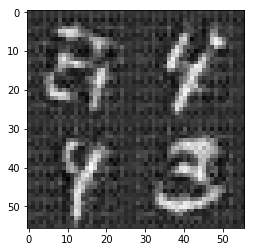

Epoch 2/2 Discriminator Loss: 0.4824 Generator loss: 2.1976
Epoch 2/2 Discriminator Loss: 0.3942 Generator loss: 3.6640
Epoch 2/2 Discriminator Loss: 0.3666 Generator loss: 4.2539
Epoch 2/2 Discriminator Loss: 0.4588 Generator loss: 2.5182
Epoch 2/2 Discriminator Loss: 0.6910 Generator loss: 1.5370
Epoch 2/2 Discriminator Loss: 1.8828 Generator loss: 0.3198
Epoch 2/2 Discriminator Loss: 7.5297 Generator loss: 9.8885
Epoch 2/2 Discriminator Loss: 0.6582 Generator loss: 3.2535
Epoch 2/2 Discriminator Loss: 1.7010 Generator loss: 0.4554
Epoch 2/2 Discriminator Loss: 1.3054 Generator loss: 3.2708
Epoch 2/2 Discriminator Loss: 1.7230 Generator loss: 0.4145
Epoch 2/2 Discriminator Loss: 1.4515 Generator loss: 1.0921
Epoch 2/2 Discriminator Loss: 1.1649 Generator loss: 0.7977
Epoch 2/2 Discriminator Loss: 1.0088 Generator loss: 2.2261
Epoch 2/2 Discriminator Loss: 0.8778 Generator loss: 1.1570
Epoch 2/2 Discriminator Loss: 0.9222 Generator loss: 1.0535
Epoch 2/2 Discriminator Loss: 0.8597 Gen

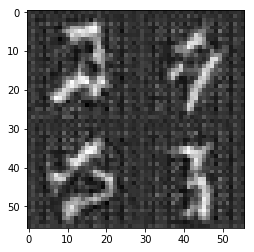

Epoch 2/2 Discriminator Loss: 0.6146 Generator loss: 1.6354
Epoch 2/2 Discriminator Loss: 0.5166 Generator loss: 4.8893
Epoch 2/2 Discriminator Loss: 0.7816 Generator loss: 1.1965
Epoch 2/2 Discriminator Loss: 0.8468 Generator loss: 1.3095
Epoch 2/2 Discriminator Loss: 1.0034 Generator loss: 1.6099
Epoch 2/2 Discriminator Loss: 2.3701 Generator loss: 0.1996
Epoch 2/2 Discriminator Loss: 2.0592 Generator loss: 5.0437
Epoch 2/2 Discriminator Loss: 0.6215 Generator loss: 1.9255
Epoch 2/2 Discriminator Loss: 1.6744 Generator loss: 0.4131
Epoch 2/2 Discriminator Loss: 1.0979 Generator loss: 2.5590
Epoch 2/2 Discriminator Loss: 1.1550 Generator loss: 0.7143
Epoch 2/2 Discriminator Loss: 0.7113 Generator loss: 1.8326
Epoch 2/2 Discriminator Loss: 0.8640 Generator loss: 1.1586
Epoch 2/2 Discriminator Loss: 0.7912 Generator loss: 1.2081
Epoch 2/2 Discriminator Loss: 0.4741 Generator loss: 2.3823
Epoch 2/2 Discriminator Loss: 0.4811 Generator loss: 2.2336
Epoch 2/2 Discriminator Loss: 0.7321 Gen

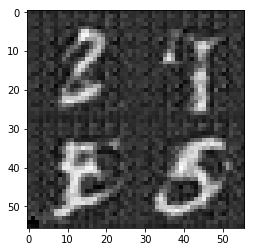

Epoch 2/2 Discriminator Loss: 0.9491 Generator loss: 0.8755
Epoch 2/2 Discriminator Loss: 0.5932 Generator loss: 1.8801
Epoch 2/2 Discriminator Loss: 0.5369 Generator loss: 2.0315
Epoch 2/2 Discriminator Loss: 0.4317 Generator loss: 2.5995
Epoch 2/2 Discriminator Loss: 0.3941 Generator loss: 3.0806
Epoch 2/2 Discriminator Loss: 0.4080 Generator loss: 2.8442
Epoch 2/2 Discriminator Loss: 0.6353 Generator loss: 1.5988
Epoch 2/2 Discriminator Loss: 0.6020 Generator loss: 1.5849
Epoch 2/2 Discriminator Loss: 0.4403 Generator loss: 2.7386
Epoch 2/2 Discriminator Loss: 0.3768 Generator loss: 3.9393
Epoch 2/2 Discriminator Loss: 0.3825 Generator loss: 3.2817
Epoch 2/2 Discriminator Loss: 0.3454 Generator loss: 5.2436
Epoch 2/2 Discriminator Loss: 0.4107 Generator loss: 2.8032
Epoch 2/2 Discriminator Loss: 0.3710 Generator loss: 4.0236
Epoch 2/2 Discriminator Loss: 0.4811 Generator loss: 2.2393
Epoch 2/2 Discriminator Loss: 0.5329 Generator loss: 1.9540
Epoch 2/2 Discriminator Loss: 0.4956 Gen

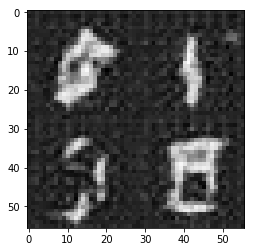

Epoch 2/2 Discriminator Loss: 0.9033 Generator loss: 2.9465
Epoch 2/2 Discriminator Loss: 0.5425 Generator loss: 2.2880
Epoch 2/2 Discriminator Loss: 1.7358 Generator loss: 1.5411
Epoch 2/2 Discriminator Loss: 0.4798 Generator loss: 2.3746
Epoch 2/2 Discriminator Loss: 1.4919 Generator loss: 3.3621
Epoch 2/2 Discriminator Loss: 4.2416 Generator loss: 0.0519
Epoch 2/2 Discriminator Loss: 1.4791 Generator loss: 3.7083
Epoch 2/2 Discriminator Loss: 1.1216 Generator loss: 1.0242
Epoch 2/2 Discriminator Loss: 1.2119 Generator loss: 0.8831
Epoch 2/2 Discriminator Loss: 1.1201 Generator loss: 2.0806
Epoch 2/2 Discriminator Loss: 1.2573 Generator loss: 0.7243
Epoch 2/2 Discriminator Loss: 1.3080 Generator loss: 2.0189
Epoch 2/2 Discriminator Loss: 1.0446 Generator loss: 0.8317
Epoch 2/2 Discriminator Loss: 0.9706 Generator loss: 1.2209
Epoch 2/2 Discriminator Loss: 0.8939 Generator loss: 1.3883
Epoch 2/2 Discriminator Loss: 0.8751 Generator loss: 1.4176
Epoch 2/2 Discriminator Loss: 1.0596 Gen

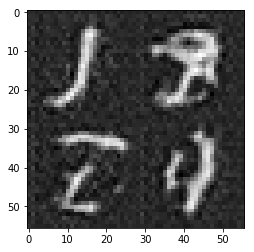

Epoch 2/2 Discriminator Loss: 0.7290 Generator loss: 1.9512
Epoch 2/2 Discriminator Loss: 0.6781 Generator loss: 1.8280
Epoch 2/2 Discriminator Loss: 1.1446 Generator loss: 0.7031
Epoch 2/2 Discriminator Loss: 0.8212 Generator loss: 2.2131
Epoch 2/2 Discriminator Loss: 1.2984 Generator loss: 0.6144
Epoch 2/2 Discriminator Loss: 1.1679 Generator loss: 3.0400
Epoch 2/2 Discriminator Loss: 1.0564 Generator loss: 0.8066
Epoch 2/2 Discriminator Loss: 0.6795 Generator loss: 1.6238
Epoch 2/2 Discriminator Loss: 0.6583 Generator loss: 1.5747
Epoch 2/2 Discriminator Loss: 0.5838 Generator loss: 1.8480
Epoch 2/2 Discriminator Loss: 0.5921 Generator loss: 1.8567
Epoch 2/2 Discriminator Loss: 0.6245 Generator loss: 1.6071
Epoch 2/2 Discriminator Loss: 0.4968 Generator loss: 2.3568
Epoch 2/2 Discriminator Loss: 0.4682 Generator loss: 2.6137
Epoch 2/2 Discriminator Loss: 0.4584 Generator loss: 2.3818
Epoch 2/2 Discriminator Loss: 0.5431 Generator loss: 1.8599
Epoch 2/2 Discriminator Loss: 0.3899 Gen

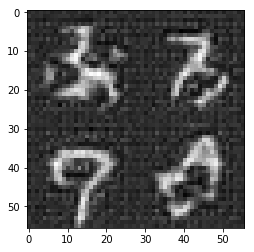

Epoch 2/2 Discriminator Loss: 0.9761 Generator loss: 3.0327
Epoch 2/2 Discriminator Loss: 0.9662 Generator loss: 1.0640
Epoch 2/2 Discriminator Loss: 1.0133 Generator loss: 0.9886
Epoch 2/2 Discriminator Loss: 0.9735 Generator loss: 1.9256
Epoch 2/2 Discriminator Loss: 0.9575 Generator loss: 0.9790
Epoch 2/2 Discriminator Loss: 0.7210 Generator loss: 1.9385
Epoch 2/2 Discriminator Loss: 0.7029 Generator loss: 1.5975
Epoch 2/2 Discriminator Loss: 0.8703 Generator loss: 1.0782
Epoch 2/2 Discriminator Loss: 0.7884 Generator loss: 2.1461
Epoch 2/2 Discriminator Loss: 0.8859 Generator loss: 0.9773
Epoch 2/2 Discriminator Loss: 0.7506 Generator loss: 2.1478
Epoch 2/2 Discriminator Loss: 1.0812 Generator loss: 0.8225
Epoch 2/2 Discriminator Loss: 0.5049 Generator loss: 2.2216
Epoch 2/2 Discriminator Loss: 0.7087 Generator loss: 1.4244
Epoch 2/2 Discriminator Loss: 0.5948 Generator loss: 1.8848
Epoch 2/2 Discriminator Loss: 0.6965 Generator loss: 1.3928
Epoch 2/2 Discriminator Loss: 0.5412 Gen

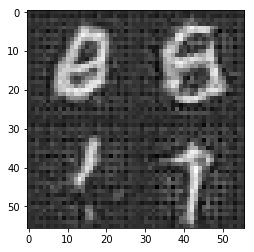

Epoch 2/2 Discriminator Loss: 0.3747 Generator loss: 4.0427
Epoch 2/2 Discriminator Loss: 0.5155 Generator loss: 2.0365
Epoch 2/2 Discriminator Loss: 0.4998 Generator loss: 2.1319
Epoch 2/2 Discriminator Loss: 0.4363 Generator loss: 3.3165
Epoch 2/2 Discriminator Loss: 0.5498 Generator loss: 1.8562
Epoch 2/2 Discriminator Loss: 0.3586 Generator loss: 4.4560
Epoch 2/2 Discriminator Loss: 0.3441 Generator loss: 5.4727
Epoch 2/2 Discriminator Loss: 0.4113 Generator loss: 2.9139
Epoch 2/2 Discriminator Loss: 0.4646 Generator loss: 2.3873
Epoch 2/2 Discriminator Loss: 0.3724 Generator loss: 4.7414
Epoch 2/2 Discriminator Loss: 0.3451 Generator loss: 5.1945
Epoch 2/2 Discriminator Loss: 0.4585 Generator loss: 2.4015
Epoch 2/2 Discriminator Loss: 0.4160 Generator loss: 2.9714
Epoch 2/2 Discriminator Loss: 0.3586 Generator loss: 5.3150
Epoch 2/2 Discriminator Loss: 0.4130 Generator loss: 2.8755
Epoch 2/2 Discriminator Loss: 0.5329 Generator loss: 1.9369
Epoch 2/2 Discriminator Loss: 0.3535 Gen

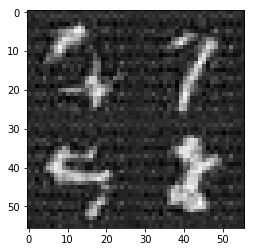

Epoch 2/2 Discriminator Loss: 0.3676 Generator loss: 4.1802
Epoch 2/2 Discriminator Loss: 0.3392 Generator loss: 5.7350
Epoch 2/2 Discriminator Loss: 0.3896 Generator loss: 3.2675
Epoch 2/2 Discriminator Loss: 0.3656 Generator loss: 3.8951
Epoch 2/2 Discriminator Loss: 0.4817 Generator loss: 2.1740
Epoch 2/2 Discriminator Loss: 0.3644 Generator loss: 5.0543
Epoch 2/2 Discriminator Loss: 0.4318 Generator loss: 2.7038
Epoch 2/2 Discriminator Loss: 0.3409 Generator loss: 6.4798
Epoch 2/2 Discriminator Loss: 0.4656 Generator loss: 2.3409
Epoch 2/2 Discriminator Loss: 0.3561 Generator loss: 5.2141
Epoch 2/2 Discriminator Loss: 0.6384 Generator loss: 1.5503
Epoch 2/2 Discriminator Loss: 0.3676 Generator loss: 7.3023
Epoch 2/2 Discriminator Loss: 0.3583 Generator loss: 4.4701
Epoch 2/2 Discriminator Loss: 0.4033 Generator loss: 3.0616
Epoch 2/2 Discriminator Loss: 0.4585 Generator loss: 2.4100
Epoch 2/2 Discriminator Loss: 0.3936 Generator loss: 3.1388
Epoch 2/2 Discriminator Loss: 0.3754 Gen

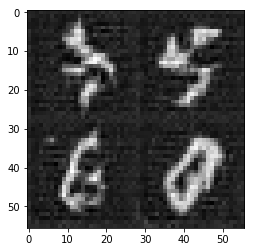

Epoch 2/2 Discriminator Loss: 0.6437 Generator loss: 1.6254
Epoch 2/2 Discriminator Loss: 0.8323 Generator loss: 1.1232
Epoch 2/2 Discriminator Loss: 0.9427 Generator loss: 2.5685
Epoch 2/2 Discriminator Loss: 1.1514 Generator loss: 0.8082
Epoch 2/2 Discriminator Loss: 1.0856 Generator loss: 2.1809
Epoch 2/2 Discriminator Loss: 1.1502 Generator loss: 0.7582
Epoch 2/2 Discriminator Loss: 0.8832 Generator loss: 1.6096
Epoch 2/2 Discriminator Loss: 1.0103 Generator loss: 0.8936
Epoch 2/2 Discriminator Loss: 0.9128 Generator loss: 1.4717
Epoch 2/2 Discriminator Loss: 1.0033 Generator loss: 0.9295
Epoch 2/2 Discriminator Loss: 0.9972 Generator loss: 1.7019
Epoch 2/2 Discriminator Loss: 1.6375 Generator loss: 0.4416
Epoch 2/2 Discriminator Loss: 2.2158 Generator loss: 3.9843
Epoch 2/2 Discriminator Loss: 0.9874 Generator loss: 0.9414
Epoch 2/2 Discriminator Loss: 0.9932 Generator loss: 0.8632
Epoch 2/2 Discriminator Loss: 1.0872 Generator loss: 2.3038
Epoch 2/2 Discriminator Loss: 1.1552 Gen

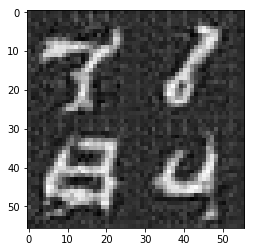

Epoch 2/2 Discriminator Loss: 1.2324 Generator loss: 0.6942
Epoch 2/2 Discriminator Loss: 0.8560 Generator loss: 2.5158
Epoch 2/2 Discriminator Loss: 0.8844 Generator loss: 1.0527
Epoch 2/2 Discriminator Loss: 0.6095 Generator loss: 1.8435
Epoch 2/2 Discriminator Loss: 0.7247 Generator loss: 1.3510
Epoch 2/2 Discriminator Loss: 0.6986 Generator loss: 1.5414
Epoch 2/2 Discriminator Loss: 0.6602 Generator loss: 1.5324
Epoch 2/2 Discriminator Loss: 0.6964 Generator loss: 1.5150
Epoch 2/2 Discriminator Loss: 0.8026 Generator loss: 1.2394
Epoch 2/2 Discriminator Loss: 0.7964 Generator loss: 1.1530
Epoch 2/2 Discriminator Loss: 0.5946 Generator loss: 2.9377
Epoch 2/2 Discriminator Loss: 1.3817 Generator loss: 0.5711
Epoch 2/2 Discriminator Loss: 1.1876 Generator loss: 3.4193
Epoch 2/2 Discriminator Loss: 1.6090 Generator loss: 0.4651
Epoch 2/2 Discriminator Loss: 0.8474 Generator loss: 2.4987
Epoch 2/2 Discriminator Loss: 0.5481 Generator loss: 2.3016
Epoch 2/2 Discriminator Loss: 0.8931 Gen

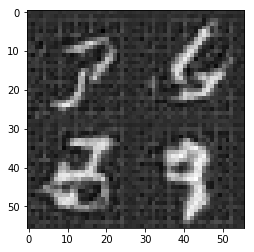

Epoch 2/2 Discriminator Loss: 0.5423 Generator loss: 1.9145
Epoch 2/2 Discriminator Loss: 1.0125 Generator loss: 0.8863
Epoch 2/2 Discriminator Loss: 1.7806 Generator loss: 3.3369
Epoch 2/2 Discriminator Loss: 3.2420 Generator loss: 0.1478
Epoch 2/2 Discriminator Loss: 6.0070 Generator loss: 6.9033
Epoch 2/2 Discriminator Loss: 0.4423 Generator loss: 3.3513
Epoch 2/2 Discriminator Loss: 0.6351 Generator loss: 1.7376
Epoch 2/2 Discriminator Loss: 0.5993 Generator loss: 2.1827
Epoch 2/2 Discriminator Loss: 0.6469 Generator loss: 2.0988
Epoch 2/2 Discriminator Loss: 0.7008 Generator loss: 1.4381
Epoch 2/2 Discriminator Loss: 0.7379 Generator loss: 1.7177
Epoch 2/2 Discriminator Loss: 0.9702 Generator loss: 0.9224
Epoch 2/2 Discriminator Loss: 1.2057 Generator loss: 1.2590
Epoch 2/2 Discriminator Loss: 1.9515 Generator loss: 0.3127
Epoch 2/2 Discriminator Loss: 1.9259 Generator loss: 3.2915
Epoch 2/2 Discriminator Loss: 1.7985 Generator loss: 0.3972
Epoch 2/2 Discriminator Loss: 1.0164 Gen

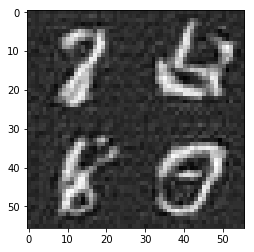

Epoch 2/2 Discriminator Loss: 0.7939 Generator loss: 2.0295
Epoch 2/2 Discriminator Loss: 0.6234 Generator loss: 1.7136
Epoch 2/2 Discriminator Loss: 0.6367 Generator loss: 1.5217


In [43]:
batch_size = 65
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Discriminator Loss: 12.0485 Generator loss: 0.0001
Epoch 1/1 Discriminator Loss: 1.2102 Generator loss: 17.9770
Epoch 1/1 Discriminator Loss: 1.6485 Generator loss: 19.8152
Epoch 1/1 Discriminator Loss: 1.3944 Generator loss: 15.2080
Epoch 1/1 Discriminator Loss: 1.4883 Generator loss: 2.1199
Epoch 1/1 Discriminator Loss: 0.9862 Generator loss: 13.7873
Epoch 1/1 Discriminator Loss: 0.8169 Generator loss: 8.4513
Epoch 1/1 Discriminator Loss: 0.4772 Generator loss: 5.2074
Epoch 1/1 Discriminator Loss: 0.5058 Generator loss: 4.1739
Epoch 1/1 Discriminator Loss: 0.8241 Generator loss: 1.6610
Epoch 1/1 Discriminator Loss: 1.2437 Generator loss: 21.8585
Epoch 1/1 Discriminator Loss: 0.8767 Generator loss: 17.4873
Epoch 1/1 Discriminator Loss: 0.8889 Generator loss: 10.3936
Epoch 1/1 Discriminator Loss: 2.2713 Generator loss: 1.8412
Epoch 1/1 Discriminator Loss: 2.9483 Generator loss: 9.1036
Epoch 1/1 Discriminator Loss: 4.5366 Generator loss: 0.1873
Epoch 1/1 Discriminator Loss: 1.

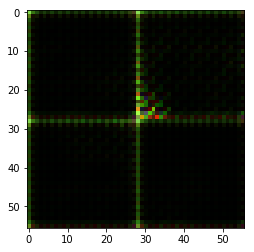

Epoch 1/1 Discriminator Loss: 0.8975 Generator loss: 1.4186
Epoch 1/1 Discriminator Loss: 0.4432 Generator loss: 4.3549
Epoch 1/1 Discriminator Loss: 0.5060 Generator loss: 3.8278
Epoch 1/1 Discriminator Loss: 0.7851 Generator loss: 1.5930
Epoch 1/1 Discriminator Loss: 0.5857 Generator loss: 2.2564
Epoch 1/1 Discriminator Loss: 0.4933 Generator loss: 3.4796
Epoch 1/1 Discriminator Loss: 0.4682 Generator loss: 3.0655
Epoch 1/1 Discriminator Loss: 1.0714 Generator loss: 0.9276
Epoch 1/1 Discriminator Loss: 1.7988 Generator loss: 12.2154
Epoch 1/1 Discriminator Loss: 0.5196 Generator loss: 3.7261
Epoch 1/1 Discriminator Loss: 2.6907 Generator loss: 0.1766
Epoch 1/1 Discriminator Loss: 1.7467 Generator loss: 5.6607
Epoch 1/1 Discriminator Loss: 0.6816 Generator loss: 2.0542
Epoch 1/1 Discriminator Loss: 1.1696 Generator loss: 0.8326
Epoch 1/1 Discriminator Loss: 0.5920 Generator loss: 2.6110
Epoch 1/1 Discriminator Loss: 0.5765 Generator loss: 2.3765
Epoch 1/1 Discriminator Loss: 0.8860 Ge

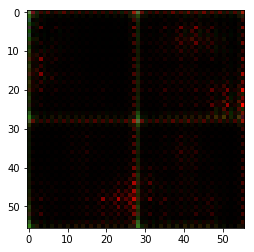

Epoch 1/1 Discriminator Loss: 0.6699 Generator loss: 3.4189
Epoch 1/1 Discriminator Loss: 0.4674 Generator loss: 2.9389
Epoch 1/1 Discriminator Loss: 0.6215 Generator loss: 1.6002
Epoch 1/1 Discriminator Loss: 0.3778 Generator loss: 4.2068
Epoch 1/1 Discriminator Loss: 0.3762 Generator loss: 4.4206
Epoch 1/1 Discriminator Loss: 0.3852 Generator loss: 3.9227
Epoch 1/1 Discriminator Loss: 0.3798 Generator loss: 3.6661
Epoch 1/1 Discriminator Loss: 0.4486 Generator loss: 2.6224
Epoch 1/1 Discriminator Loss: 0.3982 Generator loss: 4.0374
Epoch 1/1 Discriminator Loss: 0.3935 Generator loss: 3.5159
Epoch 1/1 Discriminator Loss: 0.3709 Generator loss: 4.0464
Epoch 1/1 Discriminator Loss: 0.3542 Generator loss: 4.8708
Epoch 1/1 Discriminator Loss: 0.3711 Generator loss: 3.8236
Epoch 1/1 Discriminator Loss: 0.4088 Generator loss: 2.9713
Epoch 1/1 Discriminator Loss: 0.3789 Generator loss: 3.8646
Epoch 1/1 Discriminator Loss: 0.3681 Generator loss: 4.2460
Epoch 1/1 Discriminator Loss: 0.3751 Gen

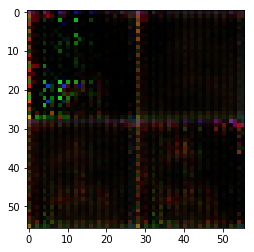

Epoch 1/1 Discriminator Loss: 0.3840 Generator loss: 3.3599
Epoch 1/1 Discriminator Loss: 0.3762 Generator loss: 3.5949
Epoch 1/1 Discriminator Loss: 0.3703 Generator loss: 3.9132
Epoch 1/1 Discriminator Loss: 0.3790 Generator loss: 3.3327
Epoch 1/1 Discriminator Loss: 0.3918 Generator loss: 5.4724
Epoch 1/1 Discriminator Loss: 0.5772 Generator loss: 2.5932
Epoch 1/1 Discriminator Loss: 0.5683 Generator loss: 1.8791
Epoch 1/1 Discriminator Loss: 0.6842 Generator loss: 4.2346
Epoch 1/1 Discriminator Loss: 2.6516 Generator loss: 0.1735
Epoch 1/1 Discriminator Loss: 4.1220 Generator loss: 8.4792
Epoch 1/1 Discriminator Loss: 1.2809 Generator loss: 3.9467
Epoch 1/1 Discriminator Loss: 1.5174 Generator loss: 1.0239
Epoch 1/1 Discriminator Loss: 1.3413 Generator loss: 1.0190
Epoch 1/1 Discriminator Loss: 0.6553 Generator loss: 2.3053
Epoch 1/1 Discriminator Loss: 0.8104 Generator loss: 1.7334
Epoch 1/1 Discriminator Loss: 0.7890 Generator loss: 1.3933
Epoch 1/1 Discriminator Loss: 0.9325 Gen

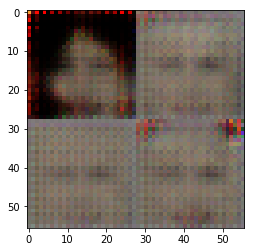

Epoch 1/1 Discriminator Loss: 2.7081 Generator loss: 0.5303
Epoch 1/1 Discriminator Loss: 1.4050 Generator loss: 0.8941
Epoch 1/1 Discriminator Loss: 1.1089 Generator loss: 2.1644
Epoch 1/1 Discriminator Loss: 0.8747 Generator loss: 1.6796
Epoch 1/1 Discriminator Loss: 0.8805 Generator loss: 1.2156
Epoch 1/1 Discriminator Loss: 0.6727 Generator loss: 1.6968
Epoch 1/1 Discriminator Loss: 0.7359 Generator loss: 1.5993
Epoch 1/1 Discriminator Loss: 0.7159 Generator loss: 1.4586
Epoch 1/1 Discriminator Loss: 0.7088 Generator loss: 1.5633
Epoch 1/1 Discriminator Loss: 0.5820 Generator loss: 2.4902
Epoch 1/1 Discriminator Loss: 0.6981 Generator loss: 1.4082
Epoch 1/1 Discriminator Loss: 0.5935 Generator loss: 2.1296
Epoch 1/1 Discriminator Loss: 0.5063 Generator loss: 2.9484
Epoch 1/1 Discriminator Loss: 0.7316 Generator loss: 1.3202
Epoch 1/1 Discriminator Loss: 0.5419 Generator loss: 2.9263
Epoch 1/1 Discriminator Loss: 0.5869 Generator loss: 1.7842
Epoch 1/1 Discriminator Loss: 0.4742 Gen

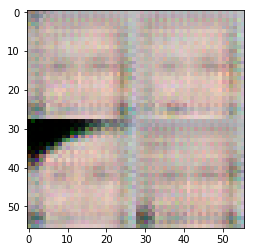

Epoch 1/1 Discriminator Loss: 4.6308 Generator loss: 5.5805
Epoch 1/1 Discriminator Loss: 1.9727 Generator loss: 2.9925
Epoch 1/1 Discriminator Loss: 1.8126 Generator loss: 0.4248
Epoch 1/1 Discriminator Loss: 1.2602 Generator loss: 0.9279
Epoch 1/1 Discriminator Loss: 1.0282 Generator loss: 1.9102
Epoch 1/1 Discriminator Loss: 1.0226 Generator loss: 1.0845
Epoch 1/1 Discriminator Loss: 1.0084 Generator loss: 1.0790
Epoch 1/1 Discriminator Loss: 0.7452 Generator loss: 1.8876
Epoch 1/1 Discriminator Loss: 0.8102 Generator loss: 1.7902
Epoch 1/1 Discriminator Loss: 0.8411 Generator loss: 1.3155
Epoch 1/1 Discriminator Loss: 0.7821 Generator loss: 1.4899
Epoch 1/1 Discriminator Loss: 0.9365 Generator loss: 0.9605
Epoch 1/1 Discriminator Loss: 0.7917 Generator loss: 2.0406
Epoch 1/1 Discriminator Loss: 0.5095 Generator loss: 2.7036
Epoch 1/1 Discriminator Loss: 0.6258 Generator loss: 1.7094
Epoch 1/1 Discriminator Loss: 0.5881 Generator loss: 2.6975
Epoch 1/1 Discriminator Loss: 0.7288 Gen

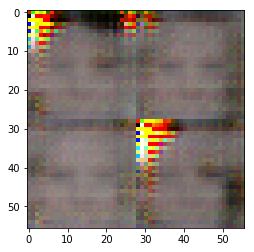

Epoch 1/1 Discriminator Loss: 0.4020 Generator loss: 3.4231
Epoch 1/1 Discriminator Loss: 0.4285 Generator loss: 4.7415
Epoch 1/1 Discriminator Loss: 1.0641 Generator loss: 0.9789
Epoch 1/1 Discriminator Loss: 1.1042 Generator loss: 4.3882
Epoch 1/1 Discriminator Loss: 4.5357 Generator loss: 0.0381
Epoch 1/1 Discriminator Loss: 3.0317 Generator loss: 3.1884
Epoch 1/1 Discriminator Loss: 0.8074 Generator loss: 2.6507
Epoch 1/1 Discriminator Loss: 0.6241 Generator loss: 1.9304
Epoch 1/1 Discriminator Loss: 0.6634 Generator loss: 1.7075
Epoch 1/1 Discriminator Loss: 0.9835 Generator loss: 1.0915
Epoch 1/1 Discriminator Loss: 0.9640 Generator loss: 1.2013
Epoch 1/1 Discriminator Loss: 1.5187 Generator loss: 0.5567
Epoch 1/1 Discriminator Loss: 1.3838 Generator loss: 2.9298
Epoch 1/1 Discriminator Loss: 0.5757 Generator loss: 2.5566
Epoch 1/1 Discriminator Loss: 0.6572 Generator loss: 1.8988
Epoch 1/1 Discriminator Loss: 0.7149 Generator loss: 1.9105
Epoch 1/1 Discriminator Loss: 0.9209 Gen

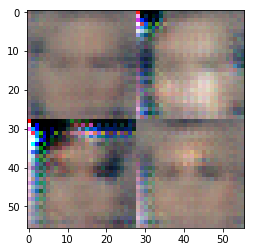

Epoch 1/1 Discriminator Loss: 0.6090 Generator loss: 1.8239
Epoch 1/1 Discriminator Loss: 0.8399 Generator loss: 1.1224
Epoch 1/1 Discriminator Loss: 0.6190 Generator loss: 2.1004
Epoch 1/1 Discriminator Loss: 0.6925 Generator loss: 1.6803
Epoch 1/1 Discriminator Loss: 0.5945 Generator loss: 2.1396
Epoch 1/1 Discriminator Loss: 0.7781 Generator loss: 1.4387
Epoch 1/1 Discriminator Loss: 0.5958 Generator loss: 2.9852
Epoch 1/1 Discriminator Loss: 0.4421 Generator loss: 2.9587
Epoch 1/1 Discriminator Loss: 0.7286 Generator loss: 1.3917
Epoch 1/1 Discriminator Loss: 0.5155 Generator loss: 2.1185
Epoch 1/1 Discriminator Loss: 0.7645 Generator loss: 4.2663
Epoch 1/1 Discriminator Loss: 0.4730 Generator loss: 3.0821
Epoch 1/1 Discriminator Loss: 0.4571 Generator loss: 3.6416
Epoch 1/1 Discriminator Loss: 0.4665 Generator loss: 3.5017
Epoch 1/1 Discriminator Loss: 0.9252 Generator loss: 1.7555
Epoch 1/1 Discriminator Loss: 1.3297 Generator loss: 4.7093
Epoch 1/1 Discriminator Loss: 1.3559 Gen

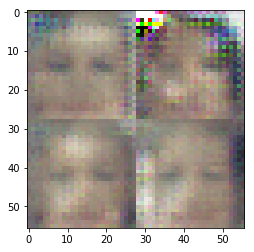

Epoch 1/1 Discriminator Loss: 0.4946 Generator loss: 2.6607
Epoch 1/1 Discriminator Loss: 0.4690 Generator loss: 2.8016
Epoch 1/1 Discriminator Loss: 0.6136 Generator loss: 2.0403
Epoch 1/1 Discriminator Loss: 0.4520 Generator loss: 2.9687
Epoch 1/1 Discriminator Loss: 0.4305 Generator loss: 3.7597
Epoch 1/1 Discriminator Loss: 0.4177 Generator loss: 3.2322
Epoch 1/1 Discriminator Loss: 0.4241 Generator loss: 3.5236
Epoch 1/1 Discriminator Loss: 0.4416 Generator loss: 3.6997
Epoch 1/1 Discriminator Loss: 0.5145 Generator loss: 3.1498
Epoch 1/1 Discriminator Loss: 0.4876 Generator loss: 3.2653
Epoch 1/1 Discriminator Loss: 0.3911 Generator loss: 4.2824
Epoch 1/1 Discriminator Loss: 0.5695 Generator loss: 2.2847
Epoch 1/1 Discriminator Loss: 0.4189 Generator loss: 3.6055
Epoch 1/1 Discriminator Loss: 0.4771 Generator loss: 3.3599
Epoch 1/1 Discriminator Loss: 0.6002 Generator loss: 2.9785
Epoch 1/1 Discriminator Loss: 0.3813 Generator loss: 5.1362
Epoch 1/1 Discriminator Loss: 0.4440 Gen

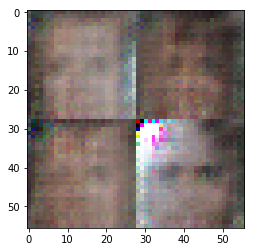

Epoch 1/1 Discriminator Loss: 0.4345 Generator loss: 3.6492
Epoch 1/1 Discriminator Loss: 0.3960 Generator loss: 4.1414
Epoch 1/1 Discriminator Loss: 0.4661 Generator loss: 3.6863
Epoch 1/1 Discriminator Loss: 0.3842 Generator loss: 4.5464
Epoch 1/1 Discriminator Loss: 0.9681 Generator loss: 1.6036
Epoch 1/1 Discriminator Loss: 0.3929 Generator loss: 4.3953
Epoch 1/1 Discriminator Loss: 0.4442 Generator loss: 3.7684
Epoch 1/1 Discriminator Loss: 0.8983 Generator loss: 1.9936
Epoch 1/1 Discriminator Loss: 2.5351 Generator loss: 2.6755
Epoch 1/1 Discriminator Loss: 0.8371 Generator loss: 2.5100
Epoch 1/1 Discriminator Loss: 2.6785 Generator loss: 0.3286
Epoch 1/1 Discriminator Loss: 3.5885 Generator loss: 0.1981
Epoch 1/1 Discriminator Loss: 3.1247 Generator loss: 0.1718
Epoch 1/1 Discriminator Loss: 1.8051 Generator loss: 1.7151
Epoch 1/1 Discriminator Loss: 1.3205 Generator loss: 0.8075
Epoch 1/1 Discriminator Loss: 0.7461 Generator loss: 1.6600
Epoch 1/1 Discriminator Loss: 0.9002 Gen

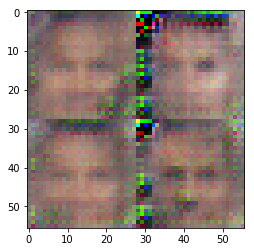

Epoch 1/1 Discriminator Loss: 0.5457 Generator loss: 2.5621
Epoch 1/1 Discriminator Loss: 0.4669 Generator loss: 3.4249
Epoch 1/1 Discriminator Loss: 0.6022 Generator loss: 2.4926
Epoch 1/1 Discriminator Loss: 0.5003 Generator loss: 2.9173
Epoch 1/1 Discriminator Loss: 0.5556 Generator loss: 3.5075
Epoch 1/1 Discriminator Loss: 0.4570 Generator loss: 3.2139
Epoch 1/1 Discriminator Loss: 0.6234 Generator loss: 2.2183
Epoch 1/1 Discriminator Loss: 0.4092 Generator loss: 4.2604
Epoch 1/1 Discriminator Loss: 0.5059 Generator loss: 2.8262
Epoch 1/1 Discriminator Loss: 0.4214 Generator loss: 3.5157
Epoch 1/1 Discriminator Loss: 0.4130 Generator loss: 3.7581
Epoch 1/1 Discriminator Loss: 0.4024 Generator loss: 4.0772
Epoch 1/1 Discriminator Loss: 0.4796 Generator loss: 3.3477
Epoch 1/1 Discriminator Loss: 0.4238 Generator loss: 3.6715
Epoch 1/1 Discriminator Loss: 0.4160 Generator loss: 3.5746
Epoch 1/1 Discriminator Loss: 0.4596 Generator loss: 3.8482
Epoch 1/1 Discriminator Loss: 0.4289 Gen

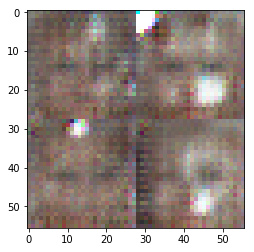

Epoch 1/1 Discriminator Loss: 1.3934 Generator loss: 0.6779
Epoch 1/1 Discriminator Loss: 2.3901 Generator loss: 4.7985
Epoch 1/1 Discriminator Loss: 0.4958 Generator loss: 2.4780
Epoch 1/1 Discriminator Loss: 0.6652 Generator loss: 1.9089
Epoch 1/1 Discriminator Loss: 0.5393 Generator loss: 2.2024
Epoch 1/1 Discriminator Loss: 0.4560 Generator loss: 3.2530
Epoch 1/1 Discriminator Loss: 0.4320 Generator loss: 3.1960
Epoch 1/1 Discriminator Loss: 0.5398 Generator loss: 2.2573
Epoch 1/1 Discriminator Loss: 0.5036 Generator loss: 2.6883
Epoch 1/1 Discriminator Loss: 0.5405 Generator loss: 2.7803
Epoch 1/1 Discriminator Loss: 0.4154 Generator loss: 3.7744
Epoch 1/1 Discriminator Loss: 0.4134 Generator loss: 3.4656
Epoch 1/1 Discriminator Loss: 0.4287 Generator loss: 3.0775
Epoch 1/1 Discriminator Loss: 0.4563 Generator loss: 2.7345
Epoch 1/1 Discriminator Loss: 0.5336 Generator loss: 2.9690
Epoch 1/1 Discriminator Loss: 0.4503 Generator loss: 3.0820
Epoch 1/1 Discriminator Loss: 0.3819 Gen

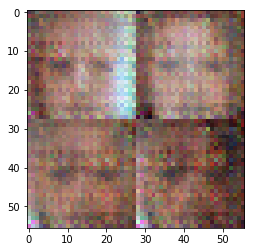

Epoch 1/1 Discriminator Loss: 0.3842 Generator loss: 3.5562
Epoch 1/1 Discriminator Loss: 0.3416 Generator loss: 5.4905
Epoch 1/1 Discriminator Loss: 0.3308 Generator loss: 8.6115
Epoch 1/1 Discriminator Loss: 0.3431 Generator loss: 4.8158
Epoch 1/1 Discriminator Loss: 0.3909 Generator loss: 3.3576
Epoch 1/1 Discriminator Loss: 0.3898 Generator loss: 3.5760
Epoch 1/1 Discriminator Loss: 0.3709 Generator loss: 3.9452
Epoch 1/1 Discriminator Loss: 0.4910 Generator loss: 3.1975
Epoch 1/1 Discriminator Loss: 0.9082 Generator loss: 1.6651
Epoch 1/1 Discriminator Loss: 0.3561 Generator loss: 4.8719
Epoch 1/1 Discriminator Loss: 0.3568 Generator loss: 5.1804
Epoch 1/1 Discriminator Loss: 0.4198 Generator loss: 3.2898
Epoch 1/1 Discriminator Loss: 0.3882 Generator loss: 3.5046
Epoch 1/1 Discriminator Loss: 0.3367 Generator loss: 6.6134
Epoch 1/1 Discriminator Loss: 0.3476 Generator loss: 4.8051
Epoch 1/1 Discriminator Loss: 0.3409 Generator loss: 5.3286
Epoch 1/1 Discriminator Loss: 0.3764 Gen

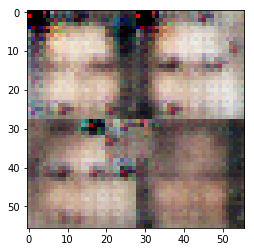

Epoch 1/1 Discriminator Loss: 1.2319 Generator loss: 0.8610
Epoch 1/1 Discriminator Loss: 1.1933 Generator loss: 1.0709
Epoch 1/1 Discriminator Loss: 1.2284 Generator loss: 0.9175
Epoch 1/1 Discriminator Loss: 1.2975 Generator loss: 0.7718
Epoch 1/1 Discriminator Loss: 1.2306 Generator loss: 0.7759
Epoch 1/1 Discriminator Loss: 1.6484 Generator loss: 0.4251
Epoch 1/1 Discriminator Loss: 1.0952 Generator loss: 1.9855
Epoch 1/1 Discriminator Loss: 0.9921 Generator loss: 1.1889
Epoch 1/1 Discriminator Loss: 0.9287 Generator loss: 1.0099
Epoch 1/1 Discriminator Loss: 0.8237 Generator loss: 2.5289
Epoch 1/1 Discriminator Loss: 0.8723 Generator loss: 1.1320
Epoch 1/1 Discriminator Loss: 0.7339 Generator loss: 2.5027
Epoch 1/1 Discriminator Loss: 1.5516 Generator loss: 0.7268
Epoch 1/1 Discriminator Loss: 0.5812 Generator loss: 2.9569
Epoch 1/1 Discriminator Loss: 0.9377 Generator loss: 1.8968
Epoch 1/1 Discriminator Loss: 1.3893 Generator loss: 0.7109
Epoch 1/1 Discriminator Loss: 0.4838 Gen

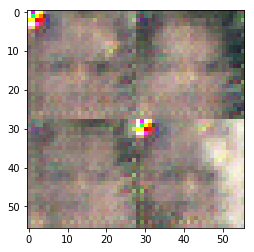

Epoch 1/1 Discriminator Loss: 0.3624 Generator loss: 4.7346
Epoch 1/1 Discriminator Loss: 0.4770 Generator loss: 2.7330
Epoch 1/1 Discriminator Loss: 0.3810 Generator loss: 3.8426
Epoch 1/1 Discriminator Loss: 0.3675 Generator loss: 4.5370
Epoch 1/1 Discriminator Loss: 0.4500 Generator loss: 3.0189
Epoch 1/1 Discriminator Loss: 0.3880 Generator loss: 3.6897
Epoch 1/1 Discriminator Loss: 0.4868 Generator loss: 2.6862
Epoch 1/1 Discriminator Loss: 0.3794 Generator loss: 4.8085
Epoch 1/1 Discriminator Loss: 0.3649 Generator loss: 4.1636
Epoch 1/1 Discriminator Loss: 0.3843 Generator loss: 3.6958
Epoch 1/1 Discriminator Loss: 0.3757 Generator loss: 3.8863
Epoch 1/1 Discriminator Loss: 0.4079 Generator loss: 2.9766
Epoch 1/1 Discriminator Loss: 0.3623 Generator loss: 4.1785
Epoch 1/1 Discriminator Loss: 0.3668 Generator loss: 3.8614
Epoch 1/1 Discriminator Loss: 0.3950 Generator loss: 3.2961
Epoch 1/1 Discriminator Loss: 0.4106 Generator loss: 3.8691
Epoch 1/1 Discriminator Loss: 0.4328 Gen

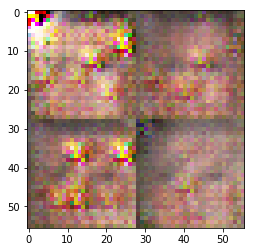

Epoch 1/1 Discriminator Loss: 0.5080 Generator loss: 2.5491
Epoch 1/1 Discriminator Loss: 0.4277 Generator loss: 3.1207
Epoch 1/1 Discriminator Loss: 0.3688 Generator loss: 4.1347
Epoch 1/1 Discriminator Loss: 0.4856 Generator loss: 2.7809
Epoch 1/1 Discriminator Loss: 0.3882 Generator loss: 3.7560
Epoch 1/1 Discriminator Loss: 0.3892 Generator loss: 4.0748
Epoch 1/1 Discriminator Loss: 0.4512 Generator loss: 2.9970
Epoch 1/1 Discriminator Loss: 0.4104 Generator loss: 3.2304
Epoch 1/1 Discriminator Loss: 0.3954 Generator loss: 3.5875
Epoch 1/1 Discriminator Loss: 0.3523 Generator loss: 4.5929
Epoch 1/1 Discriminator Loss: 0.3679 Generator loss: 3.9386
Epoch 1/1 Discriminator Loss: 0.3987 Generator loss: 3.3162
Epoch 1/1 Discriminator Loss: 0.3525 Generator loss: 4.1755
Epoch 1/1 Discriminator Loss: 0.4420 Generator loss: 2.7679
Epoch 1/1 Discriminator Loss: 0.3772 Generator loss: 3.6546
Epoch 1/1 Discriminator Loss: 0.3496 Generator loss: 4.6468
Epoch 1/1 Discriminator Loss: 0.3684 Gen

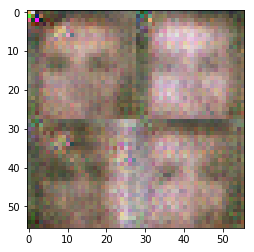

Epoch 1/1 Discriminator Loss: 1.0808 Generator loss: 0.9220
Epoch 1/1 Discriminator Loss: 0.6403 Generator loss: 1.8633
Epoch 1/1 Discriminator Loss: 0.6383 Generator loss: 2.1424
Epoch 1/1 Discriminator Loss: 1.0697 Generator loss: 0.9225
Epoch 1/1 Discriminator Loss: 0.5791 Generator loss: 1.8522
Epoch 1/1 Discriminator Loss: 0.6763 Generator loss: 2.0710
Epoch 1/1 Discriminator Loss: 0.7900 Generator loss: 1.8549
Epoch 1/1 Discriminator Loss: 0.7479 Generator loss: 1.7527
Epoch 1/1 Discriminator Loss: 0.7534 Generator loss: 1.4683
Epoch 1/1 Discriminator Loss: 0.5828 Generator loss: 2.1391
Epoch 1/1 Discriminator Loss: 0.5705 Generator loss: 2.0676
Epoch 1/1 Discriminator Loss: 0.6711 Generator loss: 1.9364
Epoch 1/1 Discriminator Loss: 0.5148 Generator loss: 2.4464
Epoch 1/1 Discriminator Loss: 0.7859 Generator loss: 2.9960
Epoch 1/1 Discriminator Loss: 0.6701 Generator loss: 3.0094
Epoch 1/1 Discriminator Loss: 0.7457 Generator loss: 2.2458
Epoch 1/1 Discriminator Loss: 0.4948 Gen

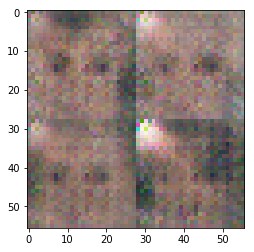

Epoch 1/1 Discriminator Loss: 3.0750 Generator loss: 0.1154
Epoch 1/1 Discriminator Loss: 2.1875 Generator loss: 0.6187
Epoch 1/1 Discriminator Loss: 2.2428 Generator loss: 1.7150
Epoch 1/1 Discriminator Loss: 2.0287 Generator loss: 1.3852
Epoch 1/1 Discriminator Loss: 1.9082 Generator loss: 1.3519
Epoch 1/1 Discriminator Loss: 1.1029 Generator loss: 1.3467
Epoch 1/1 Discriminator Loss: 1.2016 Generator loss: 1.2328
Epoch 1/1 Discriminator Loss: 0.8145 Generator loss: 1.4339
Epoch 1/1 Discriminator Loss: 0.7682 Generator loss: 1.4173
Epoch 1/1 Discriminator Loss: 0.5486 Generator loss: 1.9806
Epoch 1/1 Discriminator Loss: 0.4808 Generator loss: 2.2205
Epoch 1/1 Discriminator Loss: 0.5891 Generator loss: 1.7358
Epoch 1/1 Discriminator Loss: 0.6802 Generator loss: 1.6362
Epoch 1/1 Discriminator Loss: 0.7279 Generator loss: 1.4576
Epoch 1/1 Discriminator Loss: 0.6028 Generator loss: 1.8412
Epoch 1/1 Discriminator Loss: 1.1158 Generator loss: 0.7200
Epoch 1/1 Discriminator Loss: 0.6021 Gen

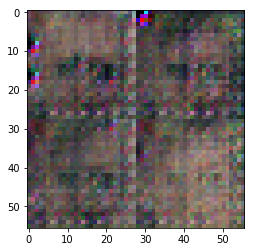

Epoch 1/1 Discriminator Loss: 0.6025 Generator loss: 1.6711
Epoch 1/1 Discriminator Loss: 0.3580 Generator loss: 4.2167
Epoch 1/1 Discriminator Loss: 0.3485 Generator loss: 4.5468
Epoch 1/1 Discriminator Loss: 0.4082 Generator loss: 3.0589
Epoch 1/1 Discriminator Loss: 0.4031 Generator loss: 3.5183
Epoch 1/1 Discriminator Loss: 0.6547 Generator loss: 1.4510
Epoch 1/1 Discriminator Loss: 0.5009 Generator loss: 5.4950
Epoch 1/1 Discriminator Loss: 0.3697 Generator loss: 4.7290
Epoch 1/1 Discriminator Loss: 0.4448 Generator loss: 2.7239
Epoch 1/1 Discriminator Loss: 0.3540 Generator loss: 4.9805
Epoch 1/1 Discriminator Loss: 0.4261 Generator loss: 5.0948
Epoch 1/1 Discriminator Loss: 1.7554 Generator loss: 0.3885
Epoch 1/1 Discriminator Loss: 4.4782 Generator loss: 7.2649
Epoch 1/1 Discriminator Loss: 3.1792 Generator loss: 2.1184
Epoch 1/1 Discriminator Loss: 2.7327 Generator loss: 0.2007
Epoch 1/1 Discriminator Loss: 1.9594 Generator loss: 0.4299
Epoch 1/1 Discriminator Loss: 2.1070 Gen

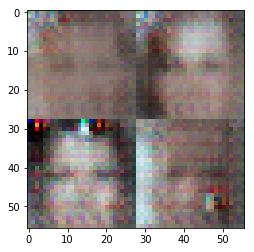

Epoch 1/1 Discriminator Loss: 0.8056 Generator loss: 1.9424
Epoch 1/1 Discriminator Loss: 0.7685 Generator loss: 1.3603
Epoch 1/1 Discriminator Loss: 0.6528 Generator loss: 1.6127
Epoch 1/1 Discriminator Loss: 0.7746 Generator loss: 1.5628
Epoch 1/1 Discriminator Loss: 0.4350 Generator loss: 2.5579
Epoch 1/1 Discriminator Loss: 0.4950 Generator loss: 2.0081
Epoch 1/1 Discriminator Loss: 0.5035 Generator loss: 2.3305
Epoch 1/1 Discriminator Loss: 0.5518 Generator loss: 1.9587
Epoch 1/1 Discriminator Loss: 0.9860 Generator loss: 0.7847
Epoch 1/1 Discriminator Loss: 0.9988 Generator loss: 4.4689
Epoch 1/1 Discriminator Loss: 2.0125 Generator loss: 0.2976
Epoch 1/1 Discriminator Loss: 1.4721 Generator loss: 0.7832
Epoch 1/1 Discriminator Loss: 2.4217 Generator loss: 0.3511
Epoch 1/1 Discriminator Loss: 2.0798 Generator loss: 1.0756
Epoch 1/1 Discriminator Loss: 1.4220 Generator loss: 0.6780
Epoch 1/1 Discriminator Loss: 1.5815 Generator loss: 0.6941
Epoch 1/1 Discriminator Loss: 1.3423 Gen

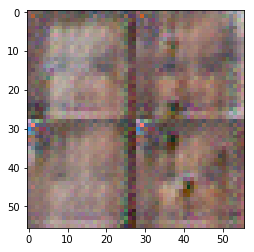

Epoch 1/1 Discriminator Loss: 1.4685 Generator loss: 0.6351
Epoch 1/1 Discriminator Loss: 1.2015 Generator loss: 1.0059
Epoch 1/1 Discriminator Loss: 1.2473 Generator loss: 1.1654
Epoch 1/1 Discriminator Loss: 1.1396 Generator loss: 1.1166
Epoch 1/1 Discriminator Loss: 1.0928 Generator loss: 0.9984
Epoch 1/1 Discriminator Loss: 0.9901 Generator loss: 1.1723
Epoch 1/1 Discriminator Loss: 1.1619 Generator loss: 0.8659
Epoch 1/1 Discriminator Loss: 1.4260 Generator loss: 0.6423
Epoch 1/1 Discriminator Loss: 1.3023 Generator loss: 1.2804
Epoch 1/1 Discriminator Loss: 1.2878 Generator loss: 0.8201
Epoch 1/1 Discriminator Loss: 1.0958 Generator loss: 0.7881
Epoch 1/1 Discriminator Loss: 1.0141 Generator loss: 2.9972
Epoch 1/1 Discriminator Loss: 0.7881 Generator loss: 1.1598
Epoch 1/1 Discriminator Loss: 0.5947 Generator loss: 1.6549
Epoch 1/1 Discriminator Loss: 1.3121 Generator loss: 4.0057
Epoch 1/1 Discriminator Loss: 3.3797 Generator loss: 0.0700
Epoch 1/1 Discriminator Loss: 1.9050 Gen

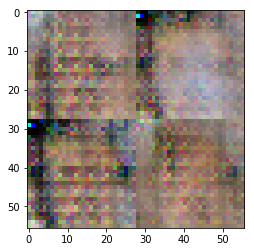

Epoch 1/1 Discriminator Loss: 0.4858 Generator loss: 2.2062
Epoch 1/1 Discriminator Loss: 0.4410 Generator loss: 2.6693
Epoch 1/1 Discriminator Loss: 0.3769 Generator loss: 4.4842
Epoch 1/1 Discriminator Loss: 0.4165 Generator loss: 2.9025
Epoch 1/1 Discriminator Loss: 0.4359 Generator loss: 2.7889
Epoch 1/1 Discriminator Loss: 0.3910 Generator loss: 3.2465
Epoch 1/1 Discriminator Loss: 0.5197 Generator loss: 2.0976
Epoch 1/1 Discriminator Loss: 0.4024 Generator loss: 3.1505
Epoch 1/1 Discriminator Loss: 0.3982 Generator loss: 3.2352
Epoch 1/1 Discriminator Loss: 0.3960 Generator loss: 3.1992
Epoch 1/1 Discriminator Loss: 0.3879 Generator loss: 3.4917
Epoch 1/1 Discriminator Loss: 0.5690 Generator loss: 1.8084
Epoch 1/1 Discriminator Loss: 0.5393 Generator loss: 1.9358
Epoch 1/1 Discriminator Loss: 0.3720 Generator loss: 3.5375
Epoch 1/1 Discriminator Loss: 0.3525 Generator loss: 4.2545
Epoch 1/1 Discriminator Loss: 0.3787 Generator loss: 3.4555
Epoch 1/1 Discriminator Loss: 0.3972 Gen

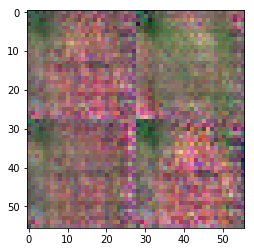

Epoch 1/1 Discriminator Loss: 0.6758 Generator loss: 2.2075
Epoch 1/1 Discriminator Loss: 0.9303 Generator loss: 1.2605
Epoch 1/1 Discriminator Loss: 0.4427 Generator loss: 3.7579
Epoch 1/1 Discriminator Loss: 0.4388 Generator loss: 3.4379
Epoch 1/1 Discriminator Loss: 0.4501 Generator loss: 2.8123
Epoch 1/1 Discriminator Loss: 0.4511 Generator loss: 2.8905
Epoch 1/1 Discriminator Loss: 0.4171 Generator loss: 3.6388
Epoch 1/1 Discriminator Loss: 0.8776 Generator loss: 1.7115
Epoch 1/1 Discriminator Loss: 0.5433 Generator loss: 2.6601
Epoch 1/1 Discriminator Loss: 0.4626 Generator loss: 3.5030
Epoch 1/1 Discriminator Loss: 0.4215 Generator loss: 3.0657
Epoch 1/1 Discriminator Loss: 0.5298 Generator loss: 2.1233
Epoch 1/1 Discriminator Loss: 0.4388 Generator loss: 3.5584
Epoch 1/1 Discriminator Loss: 0.4635 Generator loss: 3.9667
Epoch 1/1 Discriminator Loss: 0.6332 Generator loss: 2.0885
Epoch 1/1 Discriminator Loss: 0.7062 Generator loss: 6.8469
Epoch 1/1 Discriminator Loss: 0.3672 Gen

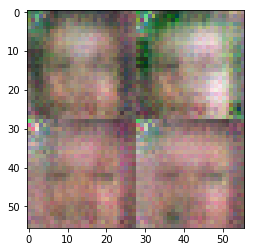

Epoch 1/1 Discriminator Loss: 0.3932 Generator loss: 3.6885
Epoch 1/1 Discriminator Loss: 1.1955 Generator loss: 0.8325
Epoch 1/1 Discriminator Loss: 0.5059 Generator loss: 3.2857
Epoch 1/1 Discriminator Loss: 0.4485 Generator loss: 3.7915
Epoch 1/1 Discriminator Loss: 0.5439 Generator loss: 2.1709
Epoch 1/1 Discriminator Loss: 0.3826 Generator loss: 4.0340
Epoch 1/1 Discriminator Loss: 0.3964 Generator loss: 4.0112
Epoch 1/1 Discriminator Loss: 0.3591 Generator loss: 4.2572
Epoch 1/1 Discriminator Loss: 0.4316 Generator loss: 2.7383
Epoch 1/1 Discriminator Loss: 0.4644 Generator loss: 2.5997
Epoch 1/1 Discriminator Loss: 0.6019 Generator loss: 3.1093
Epoch 1/1 Discriminator Loss: 0.4698 Generator loss: 3.8257
Epoch 1/1 Discriminator Loss: 0.6758 Generator loss: 1.7238
Epoch 1/1 Discriminator Loss: 0.4055 Generator loss: 3.0651
Epoch 1/1 Discriminator Loss: 0.7040 Generator loss: 1.3843
Epoch 1/1 Discriminator Loss: 1.8255 Generator loss: 0.2730
Epoch 1/1 Discriminator Loss: 1.0550 Gen

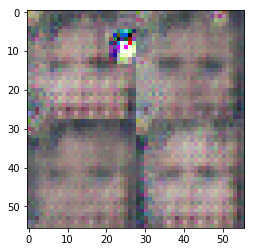

Epoch 1/1 Discriminator Loss: 0.3914 Generator loss: 3.2303
Epoch 1/1 Discriminator Loss: 0.7277 Generator loss: 1.3521
Epoch 1/1 Discriminator Loss: 0.3903 Generator loss: 4.4320
Epoch 1/1 Discriminator Loss: 0.3641 Generator loss: 4.4402
Epoch 1/1 Discriminator Loss: 0.4270 Generator loss: 3.0019
Epoch 1/1 Discriminator Loss: 0.3726 Generator loss: 4.0933
Epoch 1/1 Discriminator Loss: 0.4291 Generator loss: 2.7292
Epoch 1/1 Discriminator Loss: 0.3952 Generator loss: 3.0459
Epoch 1/1 Discriminator Loss: 0.3904 Generator loss: 3.5752
Epoch 1/1 Discriminator Loss: 0.3695 Generator loss: 3.6632
Epoch 1/1 Discriminator Loss: 0.3764 Generator loss: 3.5296
Epoch 1/1 Discriminator Loss: 0.3972 Generator loss: 3.1779
Epoch 1/1 Discriminator Loss: 0.3891 Generator loss: 3.3928
Epoch 1/1 Discriminator Loss: 0.3553 Generator loss: 4.8912
Epoch 1/1 Discriminator Loss: 3.5297 Generator loss: 0.0510
Epoch 1/1 Discriminator Loss: 4.8176 Generator loss: 6.5922
Epoch 1/1 Discriminator Loss: 0.3737 Gen

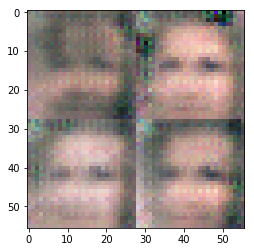

Epoch 1/1 Discriminator Loss: 2.6552 Generator loss: 0.1425
Epoch 1/1 Discriminator Loss: 1.2987 Generator loss: 5.4637
Epoch 1/1 Discriminator Loss: 0.5480 Generator loss: 1.9727
Epoch 1/1 Discriminator Loss: 0.5568 Generator loss: 1.8961
Epoch 1/1 Discriminator Loss: 0.4919 Generator loss: 2.2481
Epoch 1/1 Discriminator Loss: 0.9842 Generator loss: 2.4255
Epoch 1/1 Discriminator Loss: 0.5342 Generator loss: 1.9581
Epoch 1/1 Discriminator Loss: 0.5309 Generator loss: 2.1322
Epoch 1/1 Discriminator Loss: 0.6682 Generator loss: 1.4736
Epoch 1/1 Discriminator Loss: 0.4268 Generator loss: 3.5128
Epoch 1/1 Discriminator Loss: 0.5562 Generator loss: 1.8612
Epoch 1/1 Discriminator Loss: 0.7574 Generator loss: 1.2292
Epoch 1/1 Discriminator Loss: 0.5211 Generator loss: 2.5509
Epoch 1/1 Discriminator Loss: 0.4273 Generator loss: 2.7894
Epoch 1/1 Discriminator Loss: 0.6745 Generator loss: 1.4824
Epoch 1/1 Discriminator Loss: 0.9501 Generator loss: 1.1057
Epoch 1/1 Discriminator Loss: 0.7114 Gen

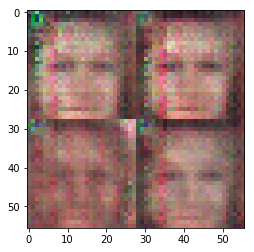

Epoch 1/1 Discriminator Loss: 0.3915 Generator loss: 3.6514
Epoch 1/1 Discriminator Loss: 0.4995 Generator loss: 2.2068
Epoch 1/1 Discriminator Loss: 0.4782 Generator loss: 2.4655
Epoch 1/1 Discriminator Loss: 0.6161 Generator loss: 3.3089
Epoch 1/1 Discriminator Loss: 0.6972 Generator loss: 1.7323
Epoch 1/1 Discriminator Loss: 0.6324 Generator loss: 1.8718
Epoch 1/1 Discriminator Loss: 2.5415 Generator loss: 6.3403
Epoch 1/1 Discriminator Loss: 3.8524 Generator loss: 0.1096
Epoch 1/1 Discriminator Loss: 1.0007 Generator loss: 1.8024
Epoch 1/1 Discriminator Loss: 0.7700 Generator loss: 1.8088
Epoch 1/1 Discriminator Loss: 1.1573 Generator loss: 1.0419
Epoch 1/1 Discriminator Loss: 0.8272 Generator loss: 1.8708
Epoch 1/1 Discriminator Loss: 0.9848 Generator loss: 1.6396
Epoch 1/1 Discriminator Loss: 0.7441 Generator loss: 2.1969
Epoch 1/1 Discriminator Loss: 0.8490 Generator loss: 1.5064
Epoch 1/1 Discriminator Loss: 0.5919 Generator loss: 2.3411
Epoch 1/1 Discriminator Loss: 0.9604 Gen

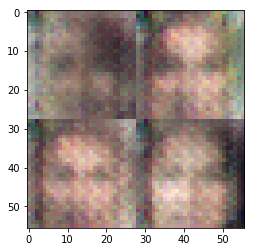

Epoch 1/1 Discriminator Loss: 1.3508 Generator loss: 0.9900
Epoch 1/1 Discriminator Loss: 2.1951 Generator loss: 0.1921
Epoch 1/1 Discriminator Loss: 1.7708 Generator loss: 3.9696
Epoch 1/1 Discriminator Loss: 0.4845 Generator loss: 2.8698
Epoch 1/1 Discriminator Loss: 0.4103 Generator loss: 4.8451
Epoch 1/1 Discriminator Loss: 0.5094 Generator loss: 2.7067
Epoch 1/1 Discriminator Loss: 0.4779 Generator loss: 3.7285
Epoch 1/1 Discriminator Loss: 0.9660 Generator loss: 0.9795
Epoch 1/1 Discriminator Loss: 1.0984 Generator loss: 4.9562
Epoch 1/1 Discriminator Loss: 3.5314 Generator loss: 0.0554
Epoch 1/1 Discriminator Loss: 2.7345 Generator loss: 2.7829
Epoch 1/1 Discriminator Loss: 1.2158 Generator loss: 0.9209
Epoch 1/1 Discriminator Loss: 1.0260 Generator loss: 0.9540
Epoch 1/1 Discriminator Loss: 0.6539 Generator loss: 4.3483
Epoch 1/1 Discriminator Loss: 0.7356 Generator loss: 1.3928
Epoch 1/1 Discriminator Loss: 0.4938 Generator loss: 2.4504
Epoch 1/1 Discriminator Loss: 0.5108 Gen

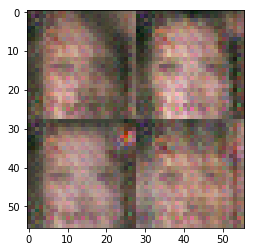

Epoch 1/1 Discriminator Loss: 0.3823 Generator loss: 3.7437
Epoch 1/1 Discriminator Loss: 0.3696 Generator loss: 4.3179
Epoch 1/1 Discriminator Loss: 0.8111 Generator loss: 1.3161
Epoch 1/1 Discriminator Loss: 0.3639 Generator loss: 5.4293
Epoch 1/1 Discriminator Loss: 1.4945 Generator loss: 0.4455
Epoch 1/1 Discriminator Loss: 3.5039 Generator loss: 7.2654
Epoch 1/1 Discriminator Loss: 0.6723 Generator loss: 2.9925
Epoch 1/1 Discriminator Loss: 1.8040 Generator loss: 0.7890
Epoch 1/1 Discriminator Loss: 1.1261 Generator loss: 2.3708
Epoch 1/1 Discriminator Loss: 1.1959 Generator loss: 1.0213
Epoch 1/1 Discriminator Loss: 0.4414 Generator loss: 3.8344
Epoch 1/1 Discriminator Loss: 0.6018 Generator loss: 1.6469
Epoch 1/1 Discriminator Loss: 0.4155 Generator loss: 3.1849
Epoch 1/1 Discriminator Loss: 0.5157 Generator loss: 2.3015
Epoch 1/1 Discriminator Loss: 0.6615 Generator loss: 1.5452
Epoch 1/1 Discriminator Loss: 5.0118 Generator loss: 7.1199
Epoch 1/1 Discriminator Loss: 1.3028 Gen

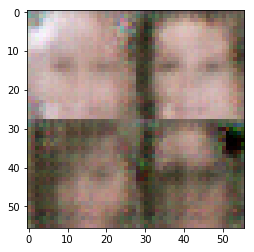

Epoch 1/1 Discriminator Loss: 3.6498 Generator loss: 7.1719
Epoch 1/1 Discriminator Loss: 1.3598 Generator loss: 0.4911
Epoch 1/1 Discriminator Loss: 0.7424 Generator loss: 1.7538
Epoch 1/1 Discriminator Loss: 0.6130 Generator loss: 2.0228
Epoch 1/1 Discriminator Loss: 0.7455 Generator loss: 1.2511
Epoch 1/1 Discriminator Loss: 0.6362 Generator loss: 1.5872
Epoch 1/1 Discriminator Loss: 0.4846 Generator loss: 3.2806
Epoch 1/1 Discriminator Loss: 0.4598 Generator loss: 2.3245
Epoch 1/1 Discriminator Loss: 0.4259 Generator loss: 2.6055
Epoch 1/1 Discriminator Loss: 0.5509 Generator loss: 1.8294
Epoch 1/1 Discriminator Loss: 0.4687 Generator loss: 2.3256
Epoch 1/1 Discriminator Loss: 0.5410 Generator loss: 2.0569
Epoch 1/1 Discriminator Loss: 0.6645 Generator loss: 1.8604
Epoch 1/1 Discriminator Loss: 0.5359 Generator loss: 1.7594
Epoch 1/1 Discriminator Loss: 0.3464 Generator loss: 4.4751
Epoch 1/1 Discriminator Loss: 0.4704 Generator loss: 2.1900
Epoch 1/1 Discriminator Loss: 0.5202 Gen

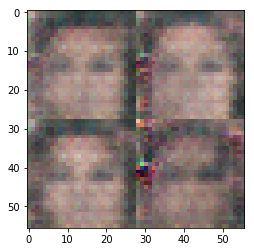

Epoch 1/1 Discriminator Loss: 1.4141 Generator loss: 0.7571
Epoch 1/1 Discriminator Loss: 1.4209 Generator loss: 0.7787
Epoch 1/1 Discriminator Loss: 1.3459 Generator loss: 0.9424
Epoch 1/1 Discriminator Loss: 1.4570 Generator loss: 0.5631
Epoch 1/1 Discriminator Loss: 1.5079 Generator loss: 1.4945
Epoch 1/1 Discriminator Loss: 1.4044 Generator loss: 0.5166
Epoch 1/1 Discriminator Loss: 0.7888 Generator loss: 5.3796
Epoch 1/1 Discriminator Loss: 0.3820 Generator loss: 3.8425
Epoch 1/1 Discriminator Loss: 0.5581 Generator loss: 1.7415
Epoch 1/1 Discriminator Loss: 0.6813 Generator loss: 1.3419
Epoch 1/1 Discriminator Loss: 0.6792 Generator loss: 1.6933
Epoch 1/1 Discriminator Loss: 0.6676 Generator loss: 1.6207
Epoch 1/1 Discriminator Loss: 0.5893 Generator loss: 1.9423
Epoch 1/1 Discriminator Loss: 0.5917 Generator loss: 1.8617
Epoch 1/1 Discriminator Loss: 1.3930 Generator loss: 0.5195
Epoch 1/1 Discriminator Loss: 0.9784 Generator loss: 3.2750
Epoch 1/1 Discriminator Loss: 0.4723 Gen

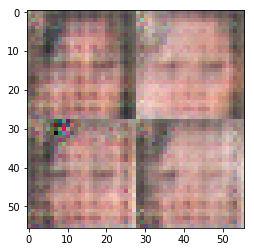

Epoch 1/1 Discriminator Loss: 2.3166 Generator loss: 1.7311
Epoch 1/1 Discriminator Loss: 1.8732 Generator loss: 0.3350
Epoch 1/1 Discriminator Loss: 1.5860 Generator loss: 0.7380
Epoch 1/1 Discriminator Loss: 1.3739 Generator loss: 1.1122
Epoch 1/1 Discriminator Loss: 1.3893 Generator loss: 0.7391
Epoch 1/1 Discriminator Loss: 1.4469 Generator loss: 0.6388
Epoch 1/1 Discriminator Loss: 1.2468 Generator loss: 1.1159
Epoch 1/1 Discriminator Loss: 1.3422 Generator loss: 0.6480
Epoch 1/1 Discriminator Loss: 1.2233 Generator loss: 1.6130
Epoch 1/1 Discriminator Loss: 1.2558 Generator loss: 0.6131
Epoch 1/1 Discriminator Loss: 1.4033 Generator loss: 1.2065
Epoch 1/1 Discriminator Loss: 1.6320 Generator loss: 0.3889
Epoch 1/1 Discriminator Loss: 1.6790 Generator loss: 1.7007
Epoch 1/1 Discriminator Loss: 1.9801 Generator loss: 0.2440
Epoch 1/1 Discriminator Loss: 1.5178 Generator loss: 1.7698
Epoch 1/1 Discriminator Loss: 1.8387 Generator loss: 0.3022
Epoch 1/1 Discriminator Loss: 1.5356 Gen

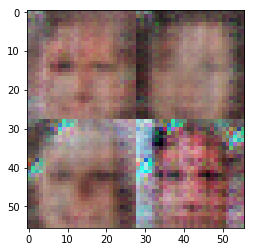

Epoch 1/1 Discriminator Loss: 1.0743 Generator loss: 0.7379
Epoch 1/1 Discriminator Loss: 0.9003 Generator loss: 1.8942
Epoch 1/1 Discriminator Loss: 0.7335 Generator loss: 1.3573
Epoch 1/1 Discriminator Loss: 0.7140 Generator loss: 1.3665
Epoch 1/1 Discriminator Loss: 0.8010 Generator loss: 1.3437
Epoch 1/1 Discriminator Loss: 0.4134 Generator loss: 5.0944
Epoch 1/1 Discriminator Loss: 0.5737 Generator loss: 1.7809
Epoch 1/1 Discriminator Loss: 0.5740 Generator loss: 1.7322
Epoch 1/1 Discriminator Loss: 0.8408 Generator loss: 1.1220
Epoch 1/1 Discriminator Loss: 0.8813 Generator loss: 3.4724
Epoch 1/1 Discriminator Loss: 0.7976 Generator loss: 1.2025
Epoch 1/1 Discriminator Loss: 0.3859 Generator loss: 3.4707
Epoch 1/1 Discriminator Loss: 0.5381 Generator loss: 1.9515
Epoch 1/1 Discriminator Loss: 0.5781 Generator loss: 1.8368
Epoch 1/1 Discriminator Loss: 0.5894 Generator loss: 2.7183
Epoch 1/1 Discriminator Loss: 0.9448 Generator loss: 0.8363
Epoch 1/1 Discriminator Loss: 2.2488 Gen

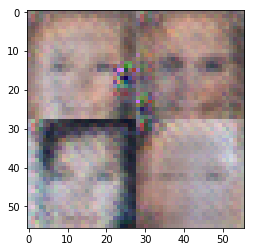

Epoch 1/1 Discriminator Loss: 1.6177 Generator loss: 0.5811
Epoch 1/1 Discriminator Loss: 1.6786 Generator loss: 0.8203
Epoch 1/1 Discriminator Loss: 1.7025 Generator loss: 0.4310
Epoch 1/1 Discriminator Loss: 1.4378 Generator loss: 1.1529
Epoch 1/1 Discriminator Loss: 1.4981 Generator loss: 0.4764
Epoch 1/1 Discriminator Loss: 1.5609 Generator loss: 0.7483
Epoch 1/1 Discriminator Loss: 1.7570 Generator loss: 0.5178
Epoch 1/1 Discriminator Loss: 1.7093 Generator loss: 0.6968
Epoch 1/1 Discriminator Loss: 1.3641 Generator loss: 0.7302
Epoch 1/1 Discriminator Loss: 1.2009 Generator loss: 1.0457
Epoch 1/1 Discriminator Loss: 1.2584 Generator loss: 0.8615
Epoch 1/1 Discriminator Loss: 1.3053 Generator loss: 0.8046
Epoch 1/1 Discriminator Loss: 1.2894 Generator loss: 0.7993
Epoch 1/1 Discriminator Loss: 1.3013 Generator loss: 1.0432
Epoch 1/1 Discriminator Loss: 1.4241 Generator loss: 0.7434
Epoch 1/1 Discriminator Loss: 1.4782 Generator loss: 0.8448
Epoch 1/1 Discriminator Loss: 1.5015 Gen

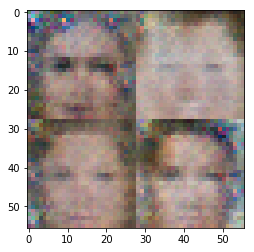

Epoch 1/1 Discriminator Loss: 1.2891 Generator loss: 0.7487
Epoch 1/1 Discriminator Loss: 1.1983 Generator loss: 0.9537
Epoch 1/1 Discriminator Loss: 1.3233 Generator loss: 0.8479
Epoch 1/1 Discriminator Loss: 1.3400 Generator loss: 0.7956
Epoch 1/1 Discriminator Loss: 1.4153 Generator loss: 0.6577
Epoch 1/1 Discriminator Loss: 1.3678 Generator loss: 1.0545
Epoch 1/1 Discriminator Loss: 1.2292 Generator loss: 0.8045
Epoch 1/1 Discriminator Loss: 1.2942 Generator loss: 0.8103
Epoch 1/1 Discriminator Loss: 1.2441 Generator loss: 0.8019
Epoch 1/1 Discriminator Loss: 1.3251 Generator loss: 1.2555
Epoch 1/1 Discriminator Loss: 1.3744 Generator loss: 0.5393
Epoch 1/1 Discriminator Loss: 1.4489 Generator loss: 1.1357
Epoch 1/1 Discriminator Loss: 1.5319 Generator loss: 0.4828
Epoch 1/1 Discriminator Loss: 1.4575 Generator loss: 1.3003
Epoch 1/1 Discriminator Loss: 1.5483 Generator loss: 0.5155
Epoch 1/1 Discriminator Loss: 1.3841 Generator loss: 0.9952
Epoch 1/1 Discriminator Loss: 1.3671 Gen

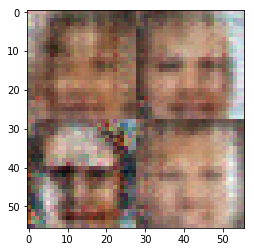

Epoch 1/1 Discriminator Loss: 1.4526 Generator loss: 0.5895
Epoch 1/1 Discriminator Loss: 1.6180 Generator loss: 1.0187
Epoch 1/1 Discriminator Loss: 1.5785 Generator loss: 0.4383
Epoch 1/1 Discriminator Loss: 1.2491 Generator loss: 1.1742
Epoch 1/1 Discriminator Loss: 1.3476 Generator loss: 0.7119
Epoch 1/1 Discriminator Loss: 1.4800 Generator loss: 0.5748
Epoch 1/1 Discriminator Loss: 1.3413 Generator loss: 1.0952
Epoch 1/1 Discriminator Loss: 1.6869 Generator loss: 0.3930
Epoch 1/1 Discriminator Loss: 1.5451 Generator loss: 1.5394
Epoch 1/1 Discriminator Loss: 1.3706 Generator loss: 0.5645
Epoch 1/1 Discriminator Loss: 1.2633 Generator loss: 0.8011
Epoch 1/1 Discriminator Loss: 1.2687 Generator loss: 0.8294
Epoch 1/1 Discriminator Loss: 1.2776 Generator loss: 1.0341
Epoch 1/1 Discriminator Loss: 1.4987 Generator loss: 0.4758
Epoch 1/1 Discriminator Loss: 1.7033 Generator loss: 1.7462
Epoch 1/1 Discriminator Loss: 1.8088 Generator loss: 0.3345
Epoch 1/1 Discriminator Loss: 1.5487 Gen

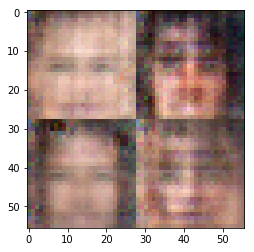

Epoch 1/1 Discriminator Loss: 1.4196 Generator loss: 1.0758
Epoch 1/1 Discriminator Loss: 1.5158 Generator loss: 0.4731
Epoch 1/1 Discriminator Loss: 1.4038 Generator loss: 1.1978
Epoch 1/1 Discriminator Loss: 1.4773 Generator loss: 0.5436
Epoch 1/1 Discriminator Loss: 1.2506 Generator loss: 1.7181
Epoch 1/1 Discriminator Loss: 1.4725 Generator loss: 0.5034
Epoch 1/1 Discriminator Loss: 1.2896 Generator loss: 0.9924
Epoch 1/1 Discriminator Loss: 1.4730 Generator loss: 0.7057
Epoch 1/1 Discriminator Loss: 1.5684 Generator loss: 0.5251
Epoch 1/1 Discriminator Loss: 1.3720 Generator loss: 1.4604
Epoch 1/1 Discriminator Loss: 1.4839 Generator loss: 0.5774
Epoch 1/1 Discriminator Loss: 1.3280 Generator loss: 0.6954
Epoch 1/1 Discriminator Loss: 1.3036 Generator loss: 1.2270
Epoch 1/1 Discriminator Loss: 1.3349 Generator loss: 0.6575
Epoch 1/1 Discriminator Loss: 1.3766 Generator loss: 0.7608
Epoch 1/1 Discriminator Loss: 1.4951 Generator loss: 0.6255
Epoch 1/1 Discriminator Loss: 1.4227 Gen

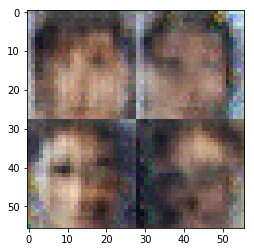

Epoch 1/1 Discriminator Loss: 1.3903 Generator loss: 0.7237
Epoch 1/1 Discriminator Loss: 1.2899 Generator loss: 1.1394
Epoch 1/1 Discriminator Loss: 1.4149 Generator loss: 0.5026
Epoch 1/1 Discriminator Loss: 1.4882 Generator loss: 1.5938
Epoch 1/1 Discriminator Loss: 1.4381 Generator loss: 0.5925
Epoch 1/1 Discriminator Loss: 1.2156 Generator loss: 1.0221
Epoch 1/1 Discriminator Loss: 1.2656 Generator loss: 0.7963
Epoch 1/1 Discriminator Loss: 1.2768 Generator loss: 0.8339
Epoch 1/1 Discriminator Loss: 1.2827 Generator loss: 0.9045
Epoch 1/1 Discriminator Loss: 1.3302 Generator loss: 0.6817
Epoch 1/1 Discriminator Loss: 1.4139 Generator loss: 0.6869
Epoch 1/1 Discriminator Loss: 1.2978 Generator loss: 0.9457
Epoch 1/1 Discriminator Loss: 1.3765 Generator loss: 0.5715
Epoch 1/1 Discriminator Loss: 1.4860 Generator loss: 1.4365
Epoch 1/1 Discriminator Loss: 1.5959 Generator loss: 0.4088
Epoch 1/1 Discriminator Loss: 1.3971 Generator loss: 1.3066
Epoch 1/1 Discriminator Loss: 1.3101 Gen

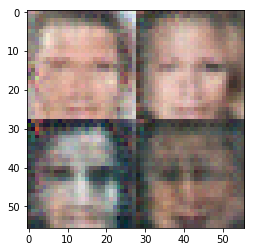

Epoch 1/1 Discriminator Loss: 1.7251 Generator loss: 1.2694
Epoch 1/1 Discriminator Loss: 1.7627 Generator loss: 0.3251
Epoch 1/1 Discriminator Loss: 1.4999 Generator loss: 1.6008
Epoch 1/1 Discriminator Loss: 1.4258 Generator loss: 0.5791
Epoch 1/1 Discriminator Loss: 1.2852 Generator loss: 0.9977
Epoch 1/1 Discriminator Loss: 1.1748 Generator loss: 0.8441
Epoch 1/1 Discriminator Loss: 1.3063 Generator loss: 0.8824
Epoch 1/1 Discriminator Loss: 1.4242 Generator loss: 0.7539
Epoch 1/1 Discriminator Loss: 1.3158 Generator loss: 0.7472
Epoch 1/1 Discriminator Loss: 1.3675 Generator loss: 0.8365
Epoch 1/1 Discriminator Loss: 1.3378 Generator loss: 0.6598
Epoch 1/1 Discriminator Loss: 1.3449 Generator loss: 1.0470
Epoch 1/1 Discriminator Loss: 1.3813 Generator loss: 0.6145
Epoch 1/1 Discriminator Loss: 1.3889 Generator loss: 0.9726
Epoch 1/1 Discriminator Loss: 1.3509 Generator loss: 0.6281
Epoch 1/1 Discriminator Loss: 1.2794 Generator loss: 0.8824
Epoch 1/1 Discriminator Loss: 1.1900 Gen

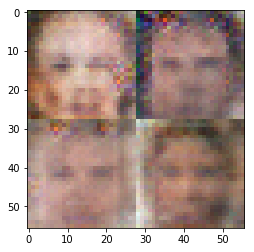

Epoch 1/1 Discriminator Loss: 1.1927 Generator loss: 1.0275
Epoch 1/1 Discriminator Loss: 1.3669 Generator loss: 0.6633
Epoch 1/1 Discriminator Loss: 1.2913 Generator loss: 0.8566
Epoch 1/1 Discriminator Loss: 1.3628 Generator loss: 0.8165
Epoch 1/1 Discriminator Loss: 1.4925 Generator loss: 0.4909
Epoch 1/1 Discriminator Loss: 1.4844 Generator loss: 1.2373
Epoch 1/1 Discriminator Loss: 1.3452 Generator loss: 0.6190
Epoch 1/1 Discriminator Loss: 1.3315 Generator loss: 0.8991
Epoch 1/1 Discriminator Loss: 1.5091 Generator loss: 0.5297
Epoch 1/1 Discriminator Loss: 1.5274 Generator loss: 1.0652
Epoch 1/1 Discriminator Loss: 1.6515 Generator loss: 0.4475
Epoch 1/1 Discriminator Loss: 1.3099 Generator loss: 1.1347
Epoch 1/1 Discriminator Loss: 1.3074 Generator loss: 0.6339
Epoch 1/1 Discriminator Loss: 1.2318 Generator loss: 1.1077
Epoch 1/1 Discriminator Loss: 1.5642 Generator loss: 0.5076
Epoch 1/1 Discriminator Loss: 1.3077 Generator loss: 0.9271
Epoch 1/1 Discriminator Loss: 1.4052 Gen

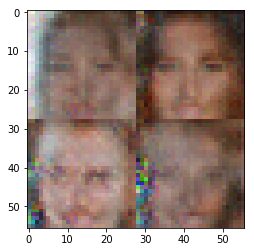

Epoch 1/1 Discriminator Loss: 1.3536 Generator loss: 0.8927
Epoch 1/1 Discriminator Loss: 1.4422 Generator loss: 0.5976
Epoch 1/1 Discriminator Loss: 1.4454 Generator loss: 1.0399
Epoch 1/1 Discriminator Loss: 1.5098 Generator loss: 0.5297
Epoch 1/1 Discriminator Loss: 1.3971 Generator loss: 1.0162
Epoch 1/1 Discriminator Loss: 1.2287 Generator loss: 0.7778
Epoch 1/1 Discriminator Loss: 1.2797 Generator loss: 0.7908
Epoch 1/1 Discriminator Loss: 1.3005 Generator loss: 1.0495
Epoch 1/1 Discriminator Loss: 1.5042 Generator loss: 0.4587
Epoch 1/1 Discriminator Loss: 1.2875 Generator loss: 1.0845
Epoch 1/1 Discriminator Loss: 1.3410 Generator loss: 0.8245
Epoch 1/1 Discriminator Loss: 1.2959 Generator loss: 0.6408
Epoch 1/1 Discriminator Loss: 1.2709 Generator loss: 1.0871
Epoch 1/1 Discriminator Loss: 1.3988 Generator loss: 0.6193
Epoch 1/1 Discriminator Loss: 1.4162 Generator loss: 0.7718
Epoch 1/1 Discriminator Loss: 1.3796 Generator loss: 0.6518
Epoch 1/1 Discriminator Loss: 1.4926 Gen

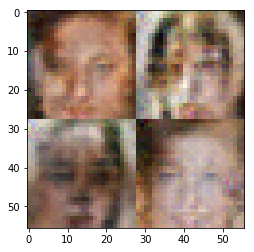

Epoch 1/1 Discriminator Loss: 1.3713 Generator loss: 1.0699
Epoch 1/1 Discriminator Loss: 1.3163 Generator loss: 0.7044
Epoch 1/1 Discriminator Loss: 1.2644 Generator loss: 0.7310
Epoch 1/1 Discriminator Loss: 1.3149 Generator loss: 1.0506
Epoch 1/1 Discriminator Loss: 1.4457 Generator loss: 0.5523
Epoch 1/1 Discriminator Loss: 1.4901 Generator loss: 1.2995
Epoch 1/1 Discriminator Loss: 1.4081 Generator loss: 0.5109
Epoch 1/1 Discriminator Loss: 1.3338 Generator loss: 1.0445
Epoch 1/1 Discriminator Loss: 1.2553 Generator loss: 0.7475
Epoch 1/1 Discriminator Loss: 1.4669 Generator loss: 0.8376
Epoch 1/1 Discriminator Loss: 1.4103 Generator loss: 0.6385
Epoch 1/1 Discriminator Loss: 1.3893 Generator loss: 0.8710
Epoch 1/1 Discriminator Loss: 1.3173 Generator loss: 0.7861
Epoch 1/1 Discriminator Loss: 1.5485 Generator loss: 0.5223
Epoch 1/1 Discriminator Loss: 1.4089 Generator loss: 1.1129
Epoch 1/1 Discriminator Loss: 1.2593 Generator loss: 0.6437
Epoch 1/1 Discriminator Loss: 1.4441 Gen

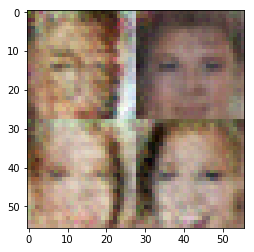

Epoch 1/1 Discriminator Loss: 1.3323 Generator loss: 0.9050
Epoch 1/1 Discriminator Loss: 1.3134 Generator loss: 0.6691
Epoch 1/1 Discriminator Loss: 1.4619 Generator loss: 0.8938
Epoch 1/1 Discriminator Loss: 1.6124 Generator loss: 0.4618
Epoch 1/1 Discriminator Loss: 1.5108 Generator loss: 1.3789
Epoch 1/1 Discriminator Loss: 1.3752 Generator loss: 0.5775
Epoch 1/1 Discriminator Loss: 1.3746 Generator loss: 0.9958
Epoch 1/1 Discriminator Loss: 1.3059 Generator loss: 0.7249
Epoch 1/1 Discriminator Loss: 1.3604 Generator loss: 0.7345
Epoch 1/1 Discriminator Loss: 1.2552 Generator loss: 0.9549
Epoch 1/1 Discriminator Loss: 1.2980 Generator loss: 0.6957
Epoch 1/1 Discriminator Loss: 1.3726 Generator loss: 0.7950
Epoch 1/1 Discriminator Loss: 1.2199 Generator loss: 0.9399
Epoch 1/1 Discriminator Loss: 1.3835 Generator loss: 0.5985
Epoch 1/1 Discriminator Loss: 1.3882 Generator loss: 1.4742
Epoch 1/1 Discriminator Loss: 1.4860 Generator loss: 0.4642
Epoch 1/1 Discriminator Loss: 1.3426 Gen

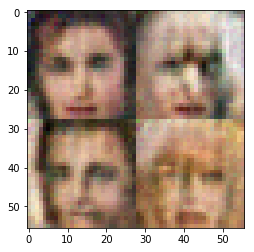

Epoch 1/1 Discriminator Loss: 1.2942 Generator loss: 0.8683
Epoch 1/1 Discriminator Loss: 1.5804 Generator loss: 0.4842
Epoch 1/1 Discriminator Loss: 1.5103 Generator loss: 1.0581
Epoch 1/1 Discriminator Loss: 1.4153 Generator loss: 0.6374
Epoch 1/1 Discriminator Loss: 1.4131 Generator loss: 0.8479
Epoch 1/1 Discriminator Loss: 1.3394 Generator loss: 0.6265
Epoch 1/1 Discriminator Loss: 1.3285 Generator loss: 0.9862
Epoch 1/1 Discriminator Loss: 1.4933 Generator loss: 0.5125
Epoch 1/1 Discriminator Loss: 1.4124 Generator loss: 1.3479
Epoch 1/1 Discriminator Loss: 1.4426 Generator loss: 0.5196
Epoch 1/1 Discriminator Loss: 1.3591 Generator loss: 1.0421
Epoch 1/1 Discriminator Loss: 1.3823 Generator loss: 0.7601
Epoch 1/1 Discriminator Loss: 1.4571 Generator loss: 0.6310
Epoch 1/1 Discriminator Loss: 1.4087 Generator loss: 0.9349
Epoch 1/1 Discriminator Loss: 1.3313 Generator loss: 0.6534
Epoch 1/1 Discriminator Loss: 1.3281 Generator loss: 0.9461
Epoch 1/1 Discriminator Loss: 1.3709 Gen

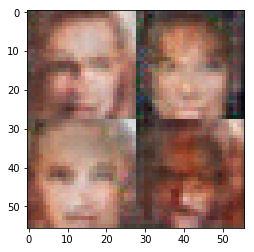

Epoch 1/1 Discriminator Loss: 1.3612 Generator loss: 0.9242
Epoch 1/1 Discriminator Loss: 1.3055 Generator loss: 0.7325
Epoch 1/1 Discriminator Loss: 1.3410 Generator loss: 0.7924
Epoch 1/1 Discriminator Loss: 1.3515 Generator loss: 0.6103
Epoch 1/1 Discriminator Loss: 1.4538 Generator loss: 1.1199
Epoch 1/1 Discriminator Loss: 1.5971 Generator loss: 0.4066
Epoch 1/1 Discriminator Loss: 1.2775 Generator loss: 1.1819
Epoch 1/1 Discriminator Loss: 1.3355 Generator loss: 0.7537
Epoch 1/1 Discriminator Loss: 1.3628 Generator loss: 0.6566
Epoch 1/1 Discriminator Loss: 1.2840 Generator loss: 0.9884
Epoch 1/1 Discriminator Loss: 1.2675 Generator loss: 0.8258
Epoch 1/1 Discriminator Loss: 1.2463 Generator loss: 0.8361
Epoch 1/1 Discriminator Loss: 1.3671 Generator loss: 0.6905
Epoch 1/1 Discriminator Loss: 1.3537 Generator loss: 0.8425
Epoch 1/1 Discriminator Loss: 1.3197 Generator loss: 0.6846
Epoch 1/1 Discriminator Loss: 1.3420 Generator loss: 0.9130
Epoch 1/1 Discriminator Loss: 1.4540 Gen

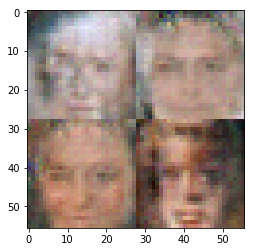

Epoch 1/1 Discriminator Loss: 1.3034 Generator loss: 0.8772
Epoch 1/1 Discriminator Loss: 1.2763 Generator loss: 0.7759
Epoch 1/1 Discriminator Loss: 1.3560 Generator loss: 0.7760
Epoch 1/1 Discriminator Loss: 1.3741 Generator loss: 0.7522
Epoch 1/1 Discriminator Loss: 1.3501 Generator loss: 1.0282
Epoch 1/1 Discriminator Loss: 1.4887 Generator loss: 0.4882
Epoch 1/1 Discriminator Loss: 1.5058 Generator loss: 1.3755
Epoch 1/1 Discriminator Loss: 1.4888 Generator loss: 0.4696
Epoch 1/1 Discriminator Loss: 1.2217 Generator loss: 1.2222
Epoch 1/1 Discriminator Loss: 1.2321 Generator loss: 0.7594
Epoch 1/1 Discriminator Loss: 1.2860 Generator loss: 0.8714
Epoch 1/1 Discriminator Loss: 1.1853 Generator loss: 0.9048
Epoch 1/1 Discriminator Loss: 1.3201 Generator loss: 0.8341
Epoch 1/1 Discriminator Loss: 1.5511 Generator loss: 0.4894
Epoch 1/1 Discriminator Loss: 1.4556 Generator loss: 1.0219
Epoch 1/1 Discriminator Loss: 1.5104 Generator loss: 0.4924
Epoch 1/1 Discriminator Loss: 1.4112 Gen

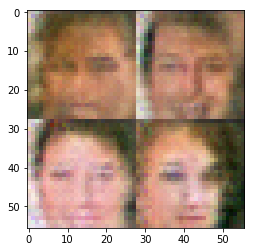

Epoch 1/1 Discriminator Loss: 1.2683 Generator loss: 0.6984
Epoch 1/1 Discriminator Loss: 1.3565 Generator loss: 1.1473
Epoch 1/1 Discriminator Loss: 1.4806 Generator loss: 0.5304
Epoch 1/1 Discriminator Loss: 1.3229 Generator loss: 0.9200
Epoch 1/1 Discriminator Loss: 1.4989 Generator loss: 0.5673
Epoch 1/1 Discriminator Loss: 1.3658 Generator loss: 0.8642
Epoch 1/1 Discriminator Loss: 1.3650 Generator loss: 0.7526
Epoch 1/1 Discriminator Loss: 1.3040 Generator loss: 0.6663
Epoch 1/1 Discriminator Loss: 1.2214 Generator loss: 1.0298
Epoch 1/1 Discriminator Loss: 1.3389 Generator loss: 0.6319
Epoch 1/1 Discriminator Loss: 1.3714 Generator loss: 0.7196
Epoch 1/1 Discriminator Loss: 1.4060 Generator loss: 0.7526
Epoch 1/1 Discriminator Loss: 1.4246 Generator loss: 0.8329
Epoch 1/1 Discriminator Loss: 1.4502 Generator loss: 0.6512
Epoch 1/1 Discriminator Loss: 1.2745 Generator loss: 0.9526
Epoch 1/1 Discriminator Loss: 1.3307 Generator loss: 0.7265
Epoch 1/1 Discriminator Loss: 1.3494 Gen

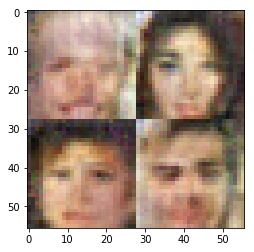

Epoch 1/1 Discriminator Loss: 1.2965 Generator loss: 0.8398
Epoch 1/1 Discriminator Loss: 1.5043 Generator loss: 0.4613
Epoch 1/1 Discriminator Loss: 1.4709 Generator loss: 0.9364
Epoch 1/1 Discriminator Loss: 1.3310 Generator loss: 0.6631
Epoch 1/1 Discriminator Loss: 1.3746 Generator loss: 0.7160
Epoch 1/1 Discriminator Loss: 1.2794 Generator loss: 1.0391
Epoch 1/1 Discriminator Loss: 1.3119 Generator loss: 0.6963
Epoch 1/1 Discriminator Loss: 1.3176 Generator loss: 0.7355
Epoch 1/1 Discriminator Loss: 1.4112 Generator loss: 0.7225
Epoch 1/1 Discriminator Loss: 1.3474 Generator loss: 0.9917
Epoch 1/1 Discriminator Loss: 1.5026 Generator loss: 0.4780
Epoch 1/1 Discriminator Loss: 1.3320 Generator loss: 1.1367
Epoch 1/1 Discriminator Loss: 1.4143 Generator loss: 0.5580
Epoch 1/1 Discriminator Loss: 1.2930 Generator loss: 0.9836
Epoch 1/1 Discriminator Loss: 1.3464 Generator loss: 0.6371
Epoch 1/1 Discriminator Loss: 1.4012 Generator loss: 0.8190
Epoch 1/1 Discriminator Loss: 1.3040 Gen

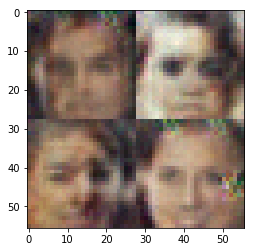

Epoch 1/1 Discriminator Loss: 1.3426 Generator loss: 0.6890
Epoch 1/1 Discriminator Loss: 1.2887 Generator loss: 0.8671
Epoch 1/1 Discriminator Loss: 1.2885 Generator loss: 0.6969
Epoch 1/1 Discriminator Loss: 1.3213 Generator loss: 0.8159
Epoch 1/1 Discriminator Loss: 1.3579 Generator loss: 0.7783
Epoch 1/1 Discriminator Loss: 1.4549 Generator loss: 0.5377
Epoch 1/1 Discriminator Loss: 1.4101 Generator loss: 1.0292
Epoch 1/1 Discriminator Loss: 1.3907 Generator loss: 0.5775
Epoch 1/1 Discriminator Loss: 1.3501 Generator loss: 0.8100
Epoch 1/1 Discriminator Loss: 1.4101 Generator loss: 0.6670
Epoch 1/1 Discriminator Loss: 1.3157 Generator loss: 0.7742
Epoch 1/1 Discriminator Loss: 1.3069 Generator loss: 0.7537
Epoch 1/1 Discriminator Loss: 1.3408 Generator loss: 0.7606
Epoch 1/1 Discriminator Loss: 1.4718 Generator loss: 0.6581
Epoch 1/1 Discriminator Loss: 1.2214 Generator loss: 1.0334
Epoch 1/1 Discriminator Loss: 1.5200 Generator loss: 0.4704
Epoch 1/1 Discriminator Loss: 1.5052 Gen

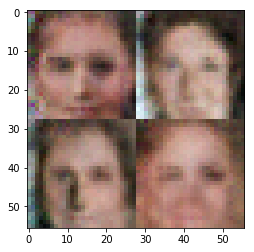

Epoch 1/1 Discriminator Loss: 1.2697 Generator loss: 1.2505
Epoch 1/1 Discriminator Loss: 1.4932 Generator loss: 0.4990
Epoch 1/1 Discriminator Loss: 1.4470 Generator loss: 0.9637
Epoch 1/1 Discriminator Loss: 1.4162 Generator loss: 0.6640
Epoch 1/1 Discriminator Loss: 1.3165 Generator loss: 0.8475
Epoch 1/1 Discriminator Loss: 1.4109 Generator loss: 0.6995
Epoch 1/1 Discriminator Loss: 1.3632 Generator loss: 0.6882
Epoch 1/1 Discriminator Loss: 1.3000 Generator loss: 1.0612
Epoch 1/1 Discriminator Loss: 1.2416 Generator loss: 0.7155
Epoch 1/1 Discriminator Loss: 1.2804 Generator loss: 0.8960
Epoch 1/1 Discriminator Loss: 1.2522 Generator loss: 0.8157
Epoch 1/1 Discriminator Loss: 1.2826 Generator loss: 0.7484
Epoch 1/1 Discriminator Loss: 1.3025 Generator loss: 0.9430
Epoch 1/1 Discriminator Loss: 1.5257 Generator loss: 0.4493
Epoch 1/1 Discriminator Loss: 1.4234 Generator loss: 1.2469
Epoch 1/1 Discriminator Loss: 1.5752 Generator loss: 0.4295
Epoch 1/1 Discriminator Loss: 1.3786 Gen

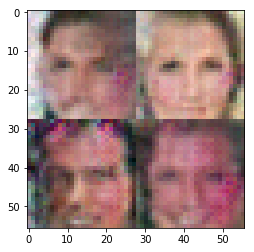

Epoch 1/1 Discriminator Loss: 1.4296 Generator loss: 0.7903
Epoch 1/1 Discriminator Loss: 1.5406 Generator loss: 0.5423
Epoch 1/1 Discriminator Loss: 1.3931 Generator loss: 0.8572
Epoch 1/1 Discriminator Loss: 1.3429 Generator loss: 0.7959
Epoch 1/1 Discriminator Loss: 1.3490 Generator loss: 0.7606
Epoch 1/1 Discriminator Loss: 1.3215 Generator loss: 0.7856
Epoch 1/1 Discriminator Loss: 1.2575 Generator loss: 0.8551
Epoch 1/1 Discriminator Loss: 1.2420 Generator loss: 0.8113
Epoch 1/1 Discriminator Loss: 1.3583 Generator loss: 0.7804
Epoch 1/1 Discriminator Loss: 1.4065 Generator loss: 0.5978
Epoch 1/1 Discriminator Loss: 1.3269 Generator loss: 1.0606
Epoch 1/1 Discriminator Loss: 1.5128 Generator loss: 0.4977
Epoch 1/1 Discriminator Loss: 1.3192 Generator loss: 0.8822
Epoch 1/1 Discriminator Loss: 1.4327 Generator loss: 0.6752
Epoch 1/1 Discriminator Loss: 1.4053 Generator loss: 0.7055
Epoch 1/1 Discriminator Loss: 1.3825 Generator loss: 0.6065
Epoch 1/1 Discriminator Loss: 1.3167 Gen

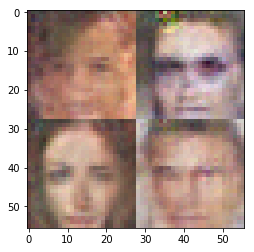

Epoch 1/1 Discriminator Loss: 1.3797 Generator loss: 0.7805
Epoch 1/1 Discriminator Loss: 1.3245 Generator loss: 0.8124
Epoch 1/1 Discriminator Loss: 1.4593 Generator loss: 0.5818
Epoch 1/1 Discriminator Loss: 1.4867 Generator loss: 0.7447
Epoch 1/1 Discriminator Loss: 1.3887 Generator loss: 0.7389
Epoch 1/1 Discriminator Loss: 1.2255 Generator loss: 0.8002
Epoch 1/1 Discriminator Loss: 1.5062 Generator loss: 0.5443
Epoch 1/1 Discriminator Loss: 1.3508 Generator loss: 0.9134
Epoch 1/1 Discriminator Loss: 1.4643 Generator loss: 0.5653
Epoch 1/1 Discriminator Loss: 1.3874 Generator loss: 0.7289
Epoch 1/1 Discriminator Loss: 1.4296 Generator loss: 0.6129
Epoch 1/1 Discriminator Loss: 1.4643 Generator loss: 1.4728
Epoch 1/1 Discriminator Loss: 1.6790 Generator loss: 0.3554
Epoch 1/1 Discriminator Loss: 1.1995 Generator loss: 1.3094
Epoch 1/1 Discriminator Loss: 1.3188 Generator loss: 0.7599
Epoch 1/1 Discriminator Loss: 1.3080 Generator loss: 0.6426
Epoch 1/1 Discriminator Loss: 1.3261 Gen

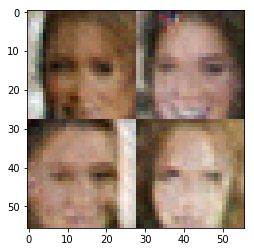

Epoch 1/1 Discriminator Loss: 1.3199 Generator loss: 0.6761
Epoch 1/1 Discriminator Loss: 1.2506 Generator loss: 0.9194
Epoch 1/1 Discriminator Loss: 1.3576 Generator loss: 0.6459
Epoch 1/1 Discriminator Loss: 1.4290 Generator loss: 0.6869
Epoch 1/1 Discriminator Loss: 1.3831 Generator loss: 0.8601
Epoch 1/1 Discriminator Loss: 1.3432 Generator loss: 0.7508
Epoch 1/1 Discriminator Loss: 1.3630 Generator loss: 0.5864
Epoch 1/1 Discriminator Loss: 1.3297 Generator loss: 1.0742
Epoch 1/1 Discriminator Loss: 1.2591 Generator loss: 0.6923
Epoch 1/1 Discriminator Loss: 1.3402 Generator loss: 0.7188
Epoch 1/1 Discriminator Loss: 1.4936 Generator loss: 0.7242
Epoch 1/1 Discriminator Loss: 1.3576 Generator loss: 0.6340
Epoch 1/1 Discriminator Loss: 1.2205 Generator loss: 0.8788
Epoch 1/1 Discriminator Loss: 1.2911 Generator loss: 0.8116
Epoch 1/1 Discriminator Loss: 1.4560 Generator loss: 0.5680
Epoch 1/1 Discriminator Loss: 1.3612 Generator loss: 0.9580
Epoch 1/1 Discriminator Loss: 1.4253 Gen

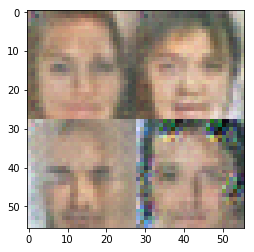

Epoch 1/1 Discriminator Loss: 1.4570 Generator loss: 0.5186
Epoch 1/1 Discriminator Loss: 1.3537 Generator loss: 0.9739
Epoch 1/1 Discriminator Loss: 1.4470 Generator loss: 0.7413
Epoch 1/1 Discriminator Loss: 1.3307 Generator loss: 0.6810
Epoch 1/1 Discriminator Loss: 1.4492 Generator loss: 0.7159
Epoch 1/1 Discriminator Loss: 1.3453 Generator loss: 0.8374
Epoch 1/1 Discriminator Loss: 1.4418 Generator loss: 0.7302
Epoch 1/1 Discriminator Loss: 1.5088 Generator loss: 0.7684
Epoch 1/1 Discriminator Loss: 1.3370 Generator loss: 0.7410
Epoch 1/1 Discriminator Loss: 1.4419 Generator loss: 0.7307
Epoch 1/1 Discriminator Loss: 1.3282 Generator loss: 0.7086
Epoch 1/1 Discriminator Loss: 1.2896 Generator loss: 0.9991
Epoch 1/1 Discriminator Loss: 1.3490 Generator loss: 0.6615
Epoch 1/1 Discriminator Loss: 1.2644 Generator loss: 1.0579
Epoch 1/1 Discriminator Loss: 1.3757 Generator loss: 0.6468
Epoch 1/1 Discriminator Loss: 1.3837 Generator loss: 0.7042
Epoch 1/1 Discriminator Loss: 1.4252 Gen

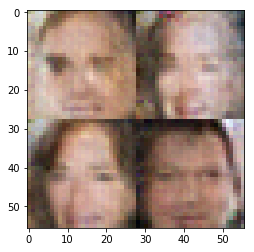

Epoch 1/1 Discriminator Loss: 1.3483 Generator loss: 0.6198
Epoch 1/1 Discriminator Loss: 1.2741 Generator loss: 1.2401
Epoch 1/1 Discriminator Loss: 1.4247 Generator loss: 0.5067
Epoch 1/1 Discriminator Loss: 1.4478 Generator loss: 0.6694
Epoch 1/1 Discriminator Loss: 1.3556 Generator loss: 0.9286
Epoch 1/1 Discriminator Loss: 1.3031 Generator loss: 0.7283
Epoch 1/1 Discriminator Loss: 1.4011 Generator loss: 0.6689
Epoch 1/1 Discriminator Loss: 1.4187 Generator loss: 0.9390
Epoch 1/1 Discriminator Loss: 1.4527 Generator loss: 0.5301
Epoch 1/1 Discriminator Loss: 1.3053 Generator loss: 0.8075
Epoch 1/1 Discriminator Loss: 1.4322 Generator loss: 0.6900
Epoch 1/1 Discriminator Loss: 1.4645 Generator loss: 0.5759
Epoch 1/1 Discriminator Loss: 1.4308 Generator loss: 0.8128
Epoch 1/1 Discriminator Loss: 1.4513 Generator loss: 0.5204
Epoch 1/1 Discriminator Loss: 1.4380 Generator loss: 0.9188
Epoch 1/1 Discriminator Loss: 1.4845 Generator loss: 0.4865
Epoch 1/1 Discriminator Loss: 1.4287 Gen

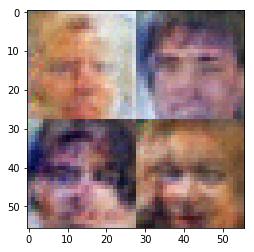

Epoch 1/1 Discriminator Loss: 1.4011 Generator loss: 0.6032
Epoch 1/1 Discriminator Loss: 1.3602 Generator loss: 0.6263
Epoch 1/1 Discriminator Loss: 1.4487 Generator loss: 1.1429
Epoch 1/1 Discriminator Loss: 1.4386 Generator loss: 0.5304
Epoch 1/1 Discriminator Loss: 1.3306 Generator loss: 0.9447
Epoch 1/1 Discriminator Loss: 1.4570 Generator loss: 0.5695
Epoch 1/1 Discriminator Loss: 1.3196 Generator loss: 1.0481
Epoch 1/1 Discriminator Loss: 1.2803 Generator loss: 0.6799
Epoch 1/1 Discriminator Loss: 1.4014 Generator loss: 0.8220
Epoch 1/1 Discriminator Loss: 1.2689 Generator loss: 0.7443
Epoch 1/1 Discriminator Loss: 1.3554 Generator loss: 0.6906
Epoch 1/1 Discriminator Loss: 1.3182 Generator loss: 0.9015
Epoch 1/1 Discriminator Loss: 1.4255 Generator loss: 0.5326
Epoch 1/1 Discriminator Loss: 1.3872 Generator loss: 1.1442
Epoch 1/1 Discriminator Loss: 1.2792 Generator loss: 0.7411
Epoch 1/1 Discriminator Loss: 1.3521 Generator loss: 0.7458
Epoch 1/1 Discriminator Loss: 1.2460 Gen

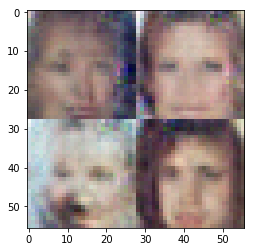

Epoch 1/1 Discriminator Loss: 1.3121 Generator loss: 0.6594
Epoch 1/1 Discriminator Loss: 1.2722 Generator loss: 0.9383
Epoch 1/1 Discriminator Loss: 1.3337 Generator loss: 0.6371
Epoch 1/1 Discriminator Loss: 1.4928 Generator loss: 0.7924
Epoch 1/1 Discriminator Loss: 1.2388 Generator loss: 0.8595
Epoch 1/1 Discriminator Loss: 1.2031 Generator loss: 0.8089
Epoch 1/1 Discriminator Loss: 1.3661 Generator loss: 0.7556
Epoch 1/1 Discriminator Loss: 1.4062 Generator loss: 0.6792
Epoch 1/1 Discriminator Loss: 1.3250 Generator loss: 0.8001
Epoch 1/1 Discriminator Loss: 1.3267 Generator loss: 0.7126
Epoch 1/1 Discriminator Loss: 1.3167 Generator loss: 0.7398
Epoch 1/1 Discriminator Loss: 1.2142 Generator loss: 0.8080
Epoch 1/1 Discriminator Loss: 1.3424 Generator loss: 0.6361
Epoch 1/1 Discriminator Loss: 1.2692 Generator loss: 0.9549
Epoch 1/1 Discriminator Loss: 1.5791 Generator loss: 0.4699
Epoch 1/1 Discriminator Loss: 1.3697 Generator loss: 0.7860
Epoch 1/1 Discriminator Loss: 1.3661 Gen

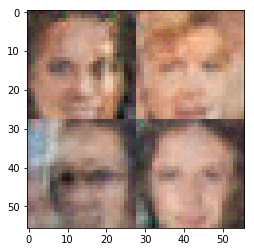

Epoch 1/1 Discriminator Loss: 1.5132 Generator loss: 0.4425
Epoch 1/1 Discriminator Loss: 1.4128 Generator loss: 1.1540
Epoch 1/1 Discriminator Loss: 1.4541 Generator loss: 0.5156
Epoch 1/1 Discriminator Loss: 1.5037 Generator loss: 0.6978
Epoch 1/1 Discriminator Loss: 1.3375 Generator loss: 0.7452
Epoch 1/1 Discriminator Loss: 1.4095 Generator loss: 0.5987
Epoch 1/1 Discriminator Loss: 1.4315 Generator loss: 1.0339
Epoch 1/1 Discriminator Loss: 1.4110 Generator loss: 0.5161
Epoch 1/1 Discriminator Loss: 1.3280 Generator loss: 1.0016
Epoch 1/1 Discriminator Loss: 1.3136 Generator loss: 0.7254
Epoch 1/1 Discriminator Loss: 1.4461 Generator loss: 0.6263
Epoch 1/1 Discriminator Loss: 1.3612 Generator loss: 0.8693
Epoch 1/1 Discriminator Loss: 1.3016 Generator loss: 0.7348
Epoch 1/1 Discriminator Loss: 1.3745 Generator loss: 1.0752
Epoch 1/1 Discriminator Loss: 1.5214 Generator loss: 0.4726
Epoch 1/1 Discriminator Loss: 1.3423 Generator loss: 0.9387
Epoch 1/1 Discriminator Loss: 1.4534 Gen

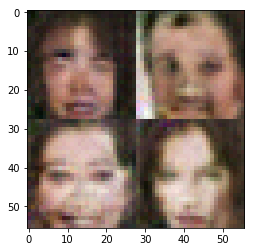

Epoch 1/1 Discriminator Loss: 1.2733 Generator loss: 0.9139
Epoch 1/1 Discriminator Loss: 1.3411 Generator loss: 0.6339
Epoch 1/1 Discriminator Loss: 1.4147 Generator loss: 0.9206
Epoch 1/1 Discriminator Loss: 1.1627 Generator loss: 1.0411
Epoch 1/1 Discriminator Loss: 1.6125 Generator loss: 0.3993
Epoch 1/1 Discriminator Loss: 1.3462 Generator loss: 0.9799
Epoch 1/1 Discriminator Loss: 1.2358 Generator loss: 0.7856
Epoch 1/1 Discriminator Loss: 1.4833 Generator loss: 0.6778
Epoch 1/1 Discriminator Loss: 1.4125 Generator loss: 0.6445
Epoch 1/1 Discriminator Loss: 1.2802 Generator loss: 0.7461
Epoch 1/1 Discriminator Loss: 1.2734 Generator loss: 0.8362
Epoch 1/1 Discriminator Loss: 1.3344 Generator loss: 0.7312
Epoch 1/1 Discriminator Loss: 1.3342 Generator loss: 0.8028
Epoch 1/1 Discriminator Loss: 1.3355 Generator loss: 0.6525
Epoch 1/1 Discriminator Loss: 1.4633 Generator loss: 0.7885
Epoch 1/1 Discriminator Loss: 1.3885 Generator loss: 0.6239
Epoch 1/1 Discriminator Loss: 1.2756 Gen

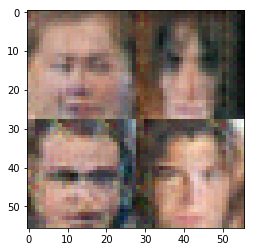

Epoch 1/1 Discriminator Loss: 1.3396 Generator loss: 0.6930
Epoch 1/1 Discriminator Loss: 1.3638 Generator loss: 0.7434
Epoch 1/1 Discriminator Loss: 1.2936 Generator loss: 0.8853
Epoch 1/1 Discriminator Loss: 1.2229 Generator loss: 0.8468
Epoch 1/1 Discriminator Loss: 1.4754 Generator loss: 0.5901
Epoch 1/1 Discriminator Loss: 1.3220 Generator loss: 1.0269
Epoch 1/1 Discriminator Loss: 1.2931 Generator loss: 0.6695
Epoch 1/1 Discriminator Loss: 1.3208 Generator loss: 0.7280
Epoch 1/1 Discriminator Loss: 1.3231 Generator loss: 0.8941
Epoch 1/1 Discriminator Loss: 1.1970 Generator loss: 0.8338
Epoch 1/1 Discriminator Loss: 1.3641 Generator loss: 0.6196
Epoch 1/1 Discriminator Loss: 1.3864 Generator loss: 0.8265
Epoch 1/1 Discriminator Loss: 1.3885 Generator loss: 0.6392
Epoch 1/1 Discriminator Loss: 1.3604 Generator loss: 0.7295
Epoch 1/1 Discriminator Loss: 1.4090 Generator loss: 0.6354
Epoch 1/1 Discriminator Loss: 1.4366 Generator loss: 0.6887
Epoch 1/1 Discriminator Loss: 1.2333 Gen

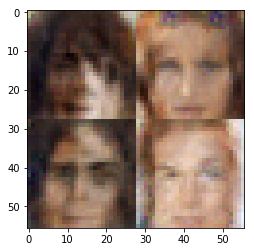

Epoch 1/1 Discriminator Loss: 1.3719 Generator loss: 0.8269
Epoch 1/1 Discriminator Loss: 1.4445 Generator loss: 0.7763
Epoch 1/1 Discriminator Loss: 1.3829 Generator loss: 0.6638
Epoch 1/1 Discriminator Loss: 1.2624 Generator loss: 0.9950
Epoch 1/1 Discriminator Loss: 1.3193 Generator loss: 0.6595
Epoch 1/1 Discriminator Loss: 1.3481 Generator loss: 0.9062
Epoch 1/1 Discriminator Loss: 1.4160 Generator loss: 0.5849
Epoch 1/1 Discriminator Loss: 1.3539 Generator loss: 0.7766
Epoch 1/1 Discriminator Loss: 1.3184 Generator loss: 0.7418
Epoch 1/1 Discriminator Loss: 1.4873 Generator loss: 0.7724
Epoch 1/1 Discriminator Loss: 1.2728 Generator loss: 0.7606
Epoch 1/1 Discriminator Loss: 1.2654 Generator loss: 0.8596
Epoch 1/1 Discriminator Loss: 1.2576 Generator loss: 0.8511
Epoch 1/1 Discriminator Loss: 1.3247 Generator loss: 0.6870
Epoch 1/1 Discriminator Loss: 1.3642 Generator loss: 0.8585
Epoch 1/1 Discriminator Loss: 1.3797 Generator loss: 0.5894
Epoch 1/1 Discriminator Loss: 1.4533 Gen

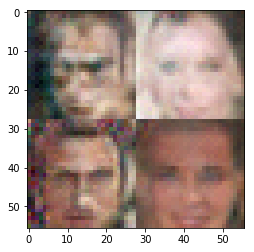

Epoch 1/1 Discriminator Loss: 1.2390 Generator loss: 0.7944
Epoch 1/1 Discriminator Loss: 1.3428 Generator loss: 0.6881
Epoch 1/1 Discriminator Loss: 1.2963 Generator loss: 1.0074
Epoch 1/1 Discriminator Loss: 1.3978 Generator loss: 0.5505
Epoch 1/1 Discriminator Loss: 1.3575 Generator loss: 1.0438
Epoch 1/1 Discriminator Loss: 1.3922 Generator loss: 0.6039
Epoch 1/1 Discriminator Loss: 1.1664 Generator loss: 1.0114
Epoch 1/1 Discriminator Loss: 1.3237 Generator loss: 0.5961
Epoch 1/1 Discriminator Loss: 1.3897 Generator loss: 0.7220
Epoch 1/1 Discriminator Loss: 1.1525 Generator loss: 1.0132
Epoch 1/1 Discriminator Loss: 1.2888 Generator loss: 0.7799
Epoch 1/1 Discriminator Loss: 1.4612 Generator loss: 0.5174
Epoch 1/1 Discriminator Loss: 1.3245 Generator loss: 0.8812
Epoch 1/1 Discriminator Loss: 1.1132 Generator loss: 0.9441
Epoch 1/1 Discriminator Loss: 1.3933 Generator loss: 0.5256
Epoch 1/1 Discriminator Loss: 1.3400 Generator loss: 1.0248
Epoch 1/1 Discriminator Loss: 1.2486 Gen

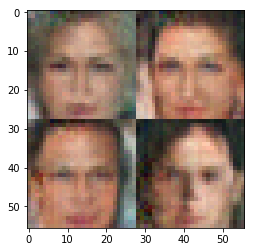

Epoch 1/1 Discriminator Loss: 1.4848 Generator loss: 0.5081
Epoch 1/1 Discriminator Loss: 1.4933 Generator loss: 1.0783
Epoch 1/1 Discriminator Loss: 1.2690 Generator loss: 0.7833
Epoch 1/1 Discriminator Loss: 1.4665 Generator loss: 0.5742
Epoch 1/1 Discriminator Loss: 1.3637 Generator loss: 0.8839
Epoch 1/1 Discriminator Loss: 1.3312 Generator loss: 0.7051
Epoch 1/1 Discriminator Loss: 1.1914 Generator loss: 1.0018
Epoch 1/1 Discriminator Loss: 1.2938 Generator loss: 0.6714
Epoch 1/1 Discriminator Loss: 1.2646 Generator loss: 0.9644
Epoch 1/1 Discriminator Loss: 1.2422 Generator loss: 0.7398
Epoch 1/1 Discriminator Loss: 1.1730 Generator loss: 0.9651
Epoch 1/1 Discriminator Loss: 1.2198 Generator loss: 0.7745
Epoch 1/1 Discriminator Loss: 1.4321 Generator loss: 0.6023
Epoch 1/1 Discriminator Loss: 1.4805 Generator loss: 0.6473
Epoch 1/1 Discriminator Loss: 1.3326 Generator loss: 0.9818
Epoch 1/1 Discriminator Loss: 1.3934 Generator loss: 0.5497
Epoch 1/1 Discriminator Loss: 1.4059 Gen

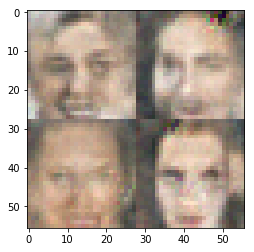

Epoch 1/1 Discriminator Loss: 1.4905 Generator loss: 0.7035
Epoch 1/1 Discriminator Loss: 1.3592 Generator loss: 0.8544
Epoch 1/1 Discriminator Loss: 1.4579 Generator loss: 0.5314
Epoch 1/1 Discriminator Loss: 1.4572 Generator loss: 0.6509
Epoch 1/1 Discriminator Loss: 1.4186 Generator loss: 0.8684
Epoch 1/1 Discriminator Loss: 1.2751 Generator loss: 0.7540
Epoch 1/1 Discriminator Loss: 1.2527 Generator loss: 0.9390
Epoch 1/1 Discriminator Loss: 1.2332 Generator loss: 0.8073
Epoch 1/1 Discriminator Loss: 1.1965 Generator loss: 0.8489
Epoch 1/1 Discriminator Loss: 1.3856 Generator loss: 0.5917
Epoch 1/1 Discriminator Loss: 1.1766 Generator loss: 1.0352
Epoch 1/1 Discriminator Loss: 1.2010 Generator loss: 0.7725
Epoch 1/1 Discriminator Loss: 1.4269 Generator loss: 0.5831
Epoch 1/1 Discriminator Loss: 1.2053 Generator loss: 1.2812
Epoch 1/1 Discriminator Loss: 1.2440 Generator loss: 0.7363
Epoch 1/1 Discriminator Loss: 1.3137 Generator loss: 0.7666
Epoch 1/1 Discriminator Loss: 1.3487 Gen

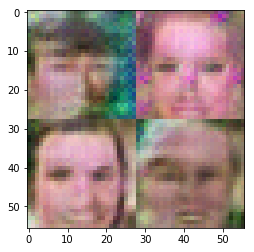

Epoch 1/1 Discriminator Loss: 0.9352 Generator loss: 0.9461
Epoch 1/1 Discriminator Loss: 0.6168 Generator loss: 1.7186
Epoch 1/1 Discriminator Loss: 0.8536 Generator loss: 1.3117
Epoch 1/1 Discriminator Loss: 0.7119 Generator loss: 1.3206
Epoch 1/1 Discriminator Loss: 1.0967 Generator loss: 0.7197
Epoch 1/1 Discriminator Loss: 0.7508 Generator loss: 2.7528
Epoch 1/1 Discriminator Loss: 1.3800 Generator loss: 0.4883
Epoch 1/1 Discriminator Loss: 1.0476 Generator loss: 2.2938
Epoch 1/1 Discriminator Loss: 0.3975 Generator loss: 4.0915
Epoch 1/1 Discriminator Loss: 0.9328 Generator loss: 0.9811
Epoch 1/1 Discriminator Loss: 0.7673 Generator loss: 1.2726
Epoch 1/1 Discriminator Loss: 3.4402 Generator loss: 2.5372
Epoch 1/1 Discriminator Loss: 1.4387 Generator loss: 0.4728
Epoch 1/1 Discriminator Loss: 1.9941 Generator loss: 1.6922
Epoch 1/1 Discriminator Loss: 2.1770 Generator loss: 0.4017
Epoch 1/1 Discriminator Loss: 1.9961 Generator loss: 0.9047
Epoch 1/1 Discriminator Loss: 1.7046 Gen

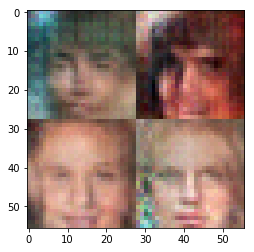

Epoch 1/1 Discriminator Loss: 1.5912 Generator loss: 0.6962
Epoch 1/1 Discriminator Loss: 1.4932 Generator loss: 0.7406
Epoch 1/1 Discriminator Loss: 1.3889 Generator loss: 0.7377
Epoch 1/1 Discriminator Loss: 1.3901 Generator loss: 0.9071
Epoch 1/1 Discriminator Loss: 1.4177 Generator loss: 0.6784
Epoch 1/1 Discriminator Loss: 1.4491 Generator loss: 0.7122
Epoch 1/1 Discriminator Loss: 1.3059 Generator loss: 0.8124
Epoch 1/1 Discriminator Loss: 1.3786 Generator loss: 0.7308
Epoch 1/1 Discriminator Loss: 1.3660 Generator loss: 0.6303
Epoch 1/1 Discriminator Loss: 1.3057 Generator loss: 0.9572
Epoch 1/1 Discriminator Loss: 1.3668 Generator loss: 0.6837
Epoch 1/1 Discriminator Loss: 1.4644 Generator loss: 0.5921
Epoch 1/1 Discriminator Loss: 1.3837 Generator loss: 0.7651
Epoch 1/1 Discriminator Loss: 1.1935 Generator loss: 0.9185
Epoch 1/1 Discriminator Loss: 1.6274 Generator loss: 0.4036
Epoch 1/1 Discriminator Loss: 1.5080 Generator loss: 1.0228
Epoch 1/1 Discriminator Loss: 1.6312 Gen

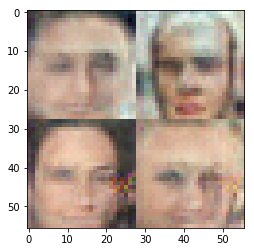

Epoch 1/1 Discriminator Loss: 1.3102 Generator loss: 0.5949
Epoch 1/1 Discriminator Loss: 1.1992 Generator loss: 1.1866
Epoch 1/1 Discriminator Loss: 1.3190 Generator loss: 0.6268
Epoch 1/1 Discriminator Loss: 1.2391 Generator loss: 1.0067
Epoch 1/1 Discriminator Loss: 1.3142 Generator loss: 0.6554
Epoch 1/1 Discriminator Loss: 1.2563 Generator loss: 0.8732
Epoch 1/1 Discriminator Loss: 1.2876 Generator loss: 0.7977
Epoch 1/1 Discriminator Loss: 1.3053 Generator loss: 0.7213
Epoch 1/1 Discriminator Loss: 1.2588 Generator loss: 0.9665
Epoch 1/1 Discriminator Loss: 1.4731 Generator loss: 0.5213
Epoch 1/1 Discriminator Loss: 1.2620 Generator loss: 1.0693
Epoch 1/1 Discriminator Loss: 1.3535 Generator loss: 0.5943
Epoch 1/1 Discriminator Loss: 1.2085 Generator loss: 1.0245
Epoch 1/1 Discriminator Loss: 1.4155 Generator loss: 0.6260
Epoch 1/1 Discriminator Loss: 1.2379 Generator loss: 0.8791
Epoch 1/1 Discriminator Loss: 1.7486 Generator loss: 0.3527
Epoch 1/1 Discriminator Loss: 1.4191 Gen

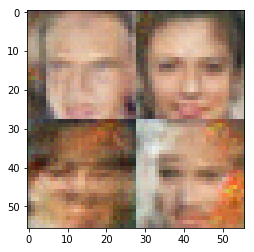

Epoch 1/1 Discriminator Loss: 1.2582 Generator loss: 0.7928
Epoch 1/1 Discriminator Loss: 1.4024 Generator loss: 0.6093
Epoch 1/1 Discriminator Loss: 1.2789 Generator loss: 1.2874
Epoch 1/1 Discriminator Loss: 1.4510 Generator loss: 0.4875
Epoch 1/1 Discriminator Loss: 1.3603 Generator loss: 0.7269
Epoch 1/1 Discriminator Loss: 1.3486 Generator loss: 0.7445
Epoch 1/1 Discriminator Loss: 1.0375 Generator loss: 1.0950
Epoch 1/1 Discriminator Loss: 1.2355 Generator loss: 0.7295
Epoch 1/1 Discriminator Loss: 1.2003 Generator loss: 1.2265
Epoch 1/1 Discriminator Loss: 1.3496 Generator loss: 0.5921
Epoch 1/1 Discriminator Loss: 1.4636 Generator loss: 0.5687
Epoch 1/1 Discriminator Loss: 1.3153 Generator loss: 1.3179
Epoch 1/1 Discriminator Loss: 1.4154 Generator loss: 0.5581
Epoch 1/1 Discriminator Loss: 1.3096 Generator loss: 0.6449
Epoch 1/1 Discriminator Loss: 1.2621 Generator loss: 0.7512
Epoch 1/1 Discriminator Loss: 1.2232 Generator loss: 1.0568
Epoch 1/1 Discriminator Loss: 1.5373 Gen

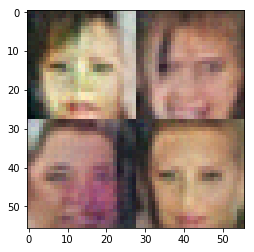

Epoch 1/1 Discriminator Loss: 1.5479 Generator loss: 0.5455
Epoch 1/1 Discriminator Loss: 1.2737 Generator loss: 1.0693
Epoch 1/1 Discriminator Loss: 1.1980 Generator loss: 0.7457
Epoch 1/1 Discriminator Loss: 1.8585 Generator loss: 0.2846
Epoch 1/1 Discriminator Loss: 1.4182 Generator loss: 0.8326
Epoch 1/1 Discriminator Loss: 1.5331 Generator loss: 0.6967
Epoch 1/1 Discriminator Loss: 1.3978 Generator loss: 0.5903
Epoch 1/1 Discriminator Loss: 1.3177 Generator loss: 0.9351
Epoch 1/1 Discriminator Loss: 1.1600 Generator loss: 0.8074
Epoch 1/1 Discriminator Loss: 1.2024 Generator loss: 0.7807
Epoch 1/1 Discriminator Loss: 1.2234 Generator loss: 0.9052
Epoch 1/1 Discriminator Loss: 1.3999 Generator loss: 0.5563
Epoch 1/1 Discriminator Loss: 1.0920 Generator loss: 1.1882
Epoch 1/1 Discriminator Loss: 1.0695 Generator loss: 0.9125
Epoch 1/1 Discriminator Loss: 1.2574 Generator loss: 0.6533
Epoch 1/1 Discriminator Loss: 1.4033 Generator loss: 0.6901
Epoch 1/1 Discriminator Loss: 1.5157 Gen

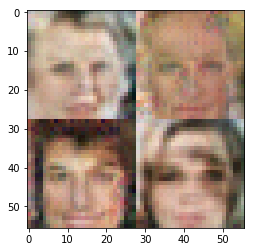

Epoch 1/1 Discriminator Loss: 1.3364 Generator loss: 0.6466
Epoch 1/1 Discriminator Loss: 1.1742 Generator loss: 1.0250
Epoch 1/1 Discriminator Loss: 1.5253 Generator loss: 0.5451
Epoch 1/1 Discriminator Loss: 1.4869 Generator loss: 0.6665
Epoch 1/1 Discriminator Loss: 1.4370 Generator loss: 0.6550
Epoch 1/1 Discriminator Loss: 1.4664 Generator loss: 0.6371
Epoch 1/1 Discriminator Loss: 1.2991 Generator loss: 0.8366
Epoch 1/1 Discriminator Loss: 1.4144 Generator loss: 0.5571
Epoch 1/1 Discriminator Loss: 1.3855 Generator loss: 0.7573
Epoch 1/1 Discriminator Loss: 1.4106 Generator loss: 0.5905
Epoch 1/1 Discriminator Loss: 1.3392 Generator loss: 0.8732
Epoch 1/1 Discriminator Loss: 1.2258 Generator loss: 0.8464
Epoch 1/1 Discriminator Loss: 1.3206 Generator loss: 0.6686
Epoch 1/1 Discriminator Loss: 1.3955 Generator loss: 0.7693
Epoch 1/1 Discriminator Loss: 1.3787 Generator loss: 0.6348
Epoch 1/1 Discriminator Loss: 1.1995 Generator loss: 0.9725
Epoch 1/1 Discriminator Loss: 1.5510 Gen

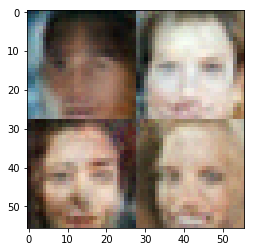

Epoch 1/1 Discriminator Loss: 1.2876 Generator loss: 0.7771
Epoch 1/1 Discriminator Loss: 1.1088 Generator loss: 0.9192
Epoch 1/1 Discriminator Loss: 1.2624 Generator loss: 0.7999
Epoch 1/1 Discriminator Loss: 1.5227 Generator loss: 0.5456
Epoch 1/1 Discriminator Loss: 1.7294 Generator loss: 0.8098
Epoch 1/1 Discriminator Loss: 1.2921 Generator loss: 0.7266
Epoch 1/1 Discriminator Loss: 1.6504 Generator loss: 0.4081
Epoch 1/1 Discriminator Loss: 1.4613 Generator loss: 0.8102
Epoch 1/1 Discriminator Loss: 1.4100 Generator loss: 0.8259
Epoch 1/1 Discriminator Loss: 1.3481 Generator loss: 0.5942
Epoch 1/1 Discriminator Loss: 1.3707 Generator loss: 1.0560
Epoch 1/1 Discriminator Loss: 1.4268 Generator loss: 0.5954
Epoch 1/1 Discriminator Loss: 1.3368 Generator loss: 0.6777
Epoch 1/1 Discriminator Loss: 1.3020 Generator loss: 1.0967
Epoch 1/1 Discriminator Loss: 1.4470 Generator loss: 0.4953
Epoch 1/1 Discriminator Loss: 1.3241 Generator loss: 1.0526
Epoch 1/1 Discriminator Loss: 1.2718 Gen

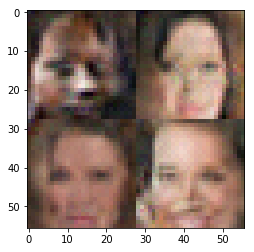

Epoch 1/1 Discriminator Loss: 1.4229 Generator loss: 1.2133
Epoch 1/1 Discriminator Loss: 1.4009 Generator loss: 0.5691
Epoch 1/1 Discriminator Loss: 1.3499 Generator loss: 0.6257
Epoch 1/1 Discriminator Loss: 1.3717 Generator loss: 0.9839
Epoch 1/1 Discriminator Loss: 1.2878 Generator loss: 0.8290
Epoch 1/1 Discriminator Loss: 1.5156 Generator loss: 0.4605
Epoch 1/1 Discriminator Loss: 1.3112 Generator loss: 0.9301
Epoch 1/1 Discriminator Loss: 1.3933 Generator loss: 0.6533
Epoch 1/1 Discriminator Loss: 1.3572 Generator loss: 0.7808
Epoch 1/1 Discriminator Loss: 1.3822 Generator loss: 0.6882
Epoch 1/1 Discriminator Loss: 1.3779 Generator loss: 0.9501
Epoch 1/1 Discriminator Loss: 1.3841 Generator loss: 0.6830
Epoch 1/1 Discriminator Loss: 1.2528 Generator loss: 0.8643
Epoch 1/1 Discriminator Loss: 1.3587 Generator loss: 0.6652
Epoch 1/1 Discriminator Loss: 1.3195 Generator loss: 0.7212
Epoch 1/1 Discriminator Loss: 1.3206 Generator loss: 0.9053
Epoch 1/1 Discriminator Loss: 1.3473 Gen

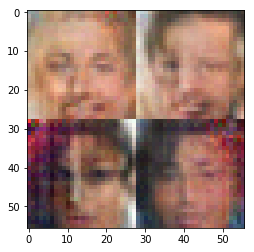

Epoch 1/1 Discriminator Loss: 1.2988 Generator loss: 0.7381
Epoch 1/1 Discriminator Loss: 1.3827 Generator loss: 0.5747
Epoch 1/1 Discriminator Loss: 1.4332 Generator loss: 1.0068
Epoch 1/1 Discriminator Loss: 1.4672 Generator loss: 0.5479
Epoch 1/1 Discriminator Loss: 1.4625 Generator loss: 1.0123
Epoch 1/1 Discriminator Loss: 1.3085 Generator loss: 0.6713
Epoch 1/1 Discriminator Loss: 1.2701 Generator loss: 0.9037
Epoch 1/1 Discriminator Loss: 1.3692 Generator loss: 0.6619
Epoch 1/1 Discriminator Loss: 1.3667 Generator loss: 0.7320
Epoch 1/1 Discriminator Loss: 1.4459 Generator loss: 0.6878
Epoch 1/1 Discriminator Loss: 1.3725 Generator loss: 0.7142
Epoch 1/1 Discriminator Loss: 1.4280 Generator loss: 0.6870
Epoch 1/1 Discriminator Loss: 1.3930 Generator loss: 0.6756
Epoch 1/1 Discriminator Loss: 1.3847 Generator loss: 0.9244
Epoch 1/1 Discriminator Loss: 1.3859 Generator loss: 0.5981
Epoch 1/1 Discriminator Loss: 1.3335 Generator loss: 0.8527
Epoch 1/1 Discriminator Loss: 1.3151 Gen

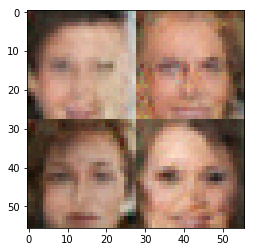

Epoch 1/1 Discriminator Loss: 1.6003 Generator loss: 0.9239
Epoch 1/1 Discriminator Loss: 1.6240 Generator loss: 0.4713
Epoch 1/1 Discriminator Loss: 1.4310 Generator loss: 0.5912
Epoch 1/1 Discriminator Loss: 1.5464 Generator loss: 0.7665
Epoch 1/1 Discriminator Loss: 1.3034 Generator loss: 0.7326
Epoch 1/1 Discriminator Loss: 1.4844 Generator loss: 0.5114
Epoch 1/1 Discriminator Loss: 1.4124 Generator loss: 0.8347
Epoch 1/1 Discriminator Loss: 1.3783 Generator loss: 0.6959
Epoch 1/1 Discriminator Loss: 1.3689 Generator loss: 0.6568
Epoch 1/1 Discriminator Loss: 1.2554 Generator loss: 0.8534
Epoch 1/1 Discriminator Loss: 1.4351 Generator loss: 0.6730
Epoch 1/1 Discriminator Loss: 1.2830 Generator loss: 1.0226
Epoch 1/1 Discriminator Loss: 1.3978 Generator loss: 0.5880
Epoch 1/1 Discriminator Loss: 1.3289 Generator loss: 0.7379
Epoch 1/1 Discriminator Loss: 1.4575 Generator loss: 0.7848
Epoch 1/1 Discriminator Loss: 1.1260 Generator loss: 0.9483
Epoch 1/1 Discriminator Loss: 1.2812 Gen

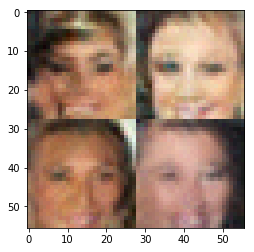

Epoch 1/1 Discriminator Loss: 1.3430 Generator loss: 0.7387
Epoch 1/1 Discriminator Loss: 1.3857 Generator loss: 0.6718
Epoch 1/1 Discriminator Loss: 1.3399 Generator loss: 0.7649
Epoch 1/1 Discriminator Loss: 1.2999 Generator loss: 0.6934
Epoch 1/1 Discriminator Loss: 1.2914 Generator loss: 0.8921
Epoch 1/1 Discriminator Loss: 1.3749 Generator loss: 0.5952
Epoch 1/1 Discriminator Loss: 1.4262 Generator loss: 0.8191
Epoch 1/1 Discriminator Loss: 1.0636 Generator loss: 0.9040
Epoch 1/1 Discriminator Loss: 1.5506 Generator loss: 0.4783
Epoch 1/1 Discriminator Loss: 1.4723 Generator loss: 0.8584
Epoch 1/1 Discriminator Loss: 1.4563 Generator loss: 0.5756
Epoch 1/1 Discriminator Loss: 1.4639 Generator loss: 0.8831
Epoch 1/1 Discriminator Loss: 1.3501 Generator loss: 0.7466
Epoch 1/1 Discriminator Loss: 1.3764 Generator loss: 0.6615
Epoch 1/1 Discriminator Loss: 1.3342 Generator loss: 0.7797
Epoch 1/1 Discriminator Loss: 1.6977 Generator loss: 0.3889
Epoch 1/1 Discriminator Loss: 1.7064 Gen

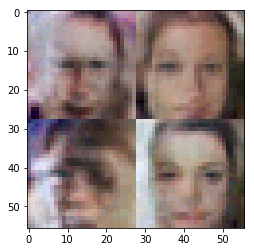

Epoch 1/1 Discriminator Loss: 1.3879 Generator loss: 0.6516
Epoch 1/1 Discriminator Loss: 1.3792 Generator loss: 0.7832
Epoch 1/1 Discriminator Loss: 1.4802 Generator loss: 0.5964
Epoch 1/1 Discriminator Loss: 1.2935 Generator loss: 0.7983
Epoch 1/1 Discriminator Loss: 1.4305 Generator loss: 0.7507
Epoch 1/1 Discriminator Loss: 1.5002 Generator loss: 0.4853
Epoch 1/1 Discriminator Loss: 1.5573 Generator loss: 1.0068
Epoch 1/1 Discriminator Loss: 1.4135 Generator loss: 0.6242
Epoch 1/1 Discriminator Loss: 1.2228 Generator loss: 0.7723
Epoch 1/1 Discriminator Loss: 1.4028 Generator loss: 0.6475
Epoch 1/1 Discriminator Loss: 1.3881 Generator loss: 0.8466
Epoch 1/1 Discriminator Loss: 1.5562 Generator loss: 0.4921
Epoch 1/1 Discriminator Loss: 1.4205 Generator loss: 0.7212
Epoch 1/1 Discriminator Loss: 1.4384 Generator loss: 0.6227
Epoch 1/1 Discriminator Loss: 1.3802 Generator loss: 0.6929
Epoch 1/1 Discriminator Loss: 1.3829 Generator loss: 0.8107
Epoch 1/1 Discriminator Loss: 1.3607 Gen

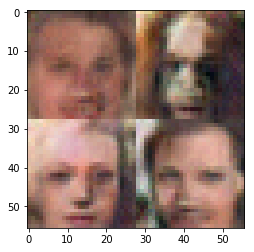

Epoch 1/1 Discriminator Loss: 1.3941 Generator loss: 0.6179
Epoch 1/1 Discriminator Loss: 1.2827 Generator loss: 1.0690
Epoch 1/1 Discriminator Loss: 1.1284 Generator loss: 1.0526
Epoch 1/1 Discriminator Loss: 1.3823 Generator loss: 0.5293
Epoch 1/1 Discriminator Loss: 1.1930 Generator loss: 1.1444
Epoch 1/1 Discriminator Loss: 1.1816 Generator loss: 0.8547
Epoch 1/1 Discriminator Loss: 1.2536 Generator loss: 0.9090
Epoch 1/1 Discriminator Loss: 1.3136 Generator loss: 0.6412
Epoch 1/1 Discriminator Loss: 1.3577 Generator loss: 0.9841
Epoch 1/1 Discriminator Loss: 1.5183 Generator loss: 0.4891
Epoch 1/1 Discriminator Loss: 1.4477 Generator loss: 0.9843
Epoch 1/1 Discriminator Loss: 1.4905 Generator loss: 0.5766
Epoch 1/1 Discriminator Loss: 1.3766 Generator loss: 0.6738
Epoch 1/1 Discriminator Loss: 1.3133 Generator loss: 0.9296
Epoch 1/1 Discriminator Loss: 1.3831 Generator loss: 0.5637
Epoch 1/1 Discriminator Loss: 1.4195 Generator loss: 0.9542
Epoch 1/1 Discriminator Loss: 1.4925 Gen

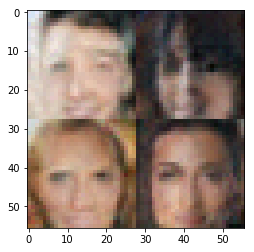

Epoch 1/1 Discriminator Loss: 1.3439 Generator loss: 0.6920
Epoch 1/1 Discriminator Loss: 1.4166 Generator loss: 0.6904
Epoch 1/1 Discriminator Loss: 1.3839 Generator loss: 1.0043
Epoch 1/1 Discriminator Loss: 1.4179 Generator loss: 0.5251
Epoch 1/1 Discriminator Loss: 1.4004 Generator loss: 0.8119
Epoch 1/1 Discriminator Loss: 1.3696 Generator loss: 0.6630
Epoch 1/1 Discriminator Loss: 1.3075 Generator loss: 0.8698
Epoch 1/1 Discriminator Loss: 1.3344 Generator loss: 0.6810
Epoch 1/1 Discriminator Loss: 1.2966 Generator loss: 0.9389
Epoch 1/1 Discriminator Loss: 1.3748 Generator loss: 0.6759
Epoch 1/1 Discriminator Loss: 1.4328 Generator loss: 0.6747
Epoch 1/1 Discriminator Loss: 1.4638 Generator loss: 0.6252
Epoch 1/1 Discriminator Loss: 1.3755 Generator loss: 0.9622
Epoch 1/1 Discriminator Loss: 1.4540 Generator loss: 0.5813
Epoch 1/1 Discriminator Loss: 1.2827 Generator loss: 0.8311
Epoch 1/1 Discriminator Loss: 1.4431 Generator loss: 0.6727
Epoch 1/1 Discriminator Loss: 1.4332 Gen

In [44]:
batch_size = 65
z_dim = 100
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.